In [1]:
#Load the data using pandas
#Import all the required packages
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt

wineRed = pd.read_csv('winequality-red .csv',header = 0,delimiter = ';')

print("wineRed\n\n",wineRed.describe())


wineRed

        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.00000

In [2]:
#Checking for na values in any rows
print("NA's present : ",wineRed.isnull().any().any())

NA's present :  False


In [3]:
#3. Split the data into test and train
#Generate a random list of true and false and assign train and test based on those values
redSplit = np.random.rand(wineRed.shape[0]) < 0.8
#Assign train to true
trainRed = wineRed[redSplit]
#Assign test to false
testRed = wineRed[~redSplit]

print("Red Wine\n")
print("Train shape : ",trainRed.shape,"\nTest shape : ",testRed.shape)

#RedWine
xTrain = trainRed.loc[:,trainRed.columns != 'quality']
yTrain = trainRed.loc[:,trainRed.columns == 'quality']
xTest = testRed.loc[:,testRed.columns != 'quality']
yTest = testRed.loc[:,testRed.columns == 'quality']

Red Wine

Train shape :  (1279, 12) 
Test shape :  (320, 12)


In [4]:
#Normalizing the data
for each in xTrain.columns.values:
    xTrain[each] = (xTrain[each] - xTrain[each].min())/(xTrain[each].max()-xTrain[each].min())
    
for each in xTest.columns.values:
    xTest[each] = (xTest[each] - xTest[each].min())/(xTest[each].max()-xTest[each].min())
#xTest = np.column_stack([xTest,np.ones(len(xTest))])    

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#Adding y data to train dataset, to avoid mismatch during shuffling
train = xTrain.copy()
train['quality'] = yTrain
#print(train)

In [6]:
#Shuffling the data each time mini-batch is called and splitting into respective train ans test data
def shuffleAndSplit(trainS,splits):
    trainS.sample(frac=1)
    batch = np.array_split(trainS, splits)
    return(batch)

In [7]:
#Loss function
def loss(x,y,beta):
    yPredicted = np.array(x.dot(beta))
    leastSquareLoss = (np.square(y-yPredicted)).sum()
    return(leastSquareLoss)

In [8]:
#Splitting data to trian and test
def trainSplit(trainSp):
    x = trainSp.loc[:,trainSp.columns != 'quality']
    #x = np.column_stack([x,np.ones(len(x))])
    y = trainSp.loc[:,trainSp.columns == 'quality']
    return(x,y)

In [9]:
#gradient
def gradient(x,y,beta,lamda):
    loss = -2 *(x.T.dot(y - np.matmul(x,beta)))
    regularization = 2*lamda*beta
    return(loss+regularization)

In [10]:
#Bold driver
def boldDriver(alpha,lossOld,lossNew):
    alphaPlus,alphaMinus = 1.2,0.9
    if float(lossNew < lossOld):
        return(alpha*alphaPlus)
    else:
        return(alpha*alphaMinus)

In [11]:
#Mini batch Gradient Descent
def mini_BGD(trainGd,xTest,yTest,alpha,lamda,batchsize,epoch):
    beta = np.zeros((trainGd.shape[1]-1,1))
    rmse,ii,rmseTest = [],[],[]
    #loop for epochs
    for each in range(epoch):
        minibatch = shuffleAndSplit(trainGd,int(trainGd.shape[0]/batchsize))
        #Loop for batches
        for every in minibatch:
            x,y = trainSplit(every)
            lossOld = loss(x,y,beta)
            betaNew = beta - alpha*gradient(x,y,beta,lamda)
            lossNew = loss(x,y,betaNew)
            #alpha = boldDriver(alpha,lossOld,lossNew)
            if float(lossOld-lossNew) < 0.00001:
                print("Optimal beta found : \n",betaNew)
                break
            if each == epoch :
                print("Did not converge")
            beta = betaNew
        ii.append(each)
        rmse.append(np.sqrt(lossNew/xTrain.shape[0]))
        temp = loss(xTest,yTest,beta)
        rmseTest.append(np.sqrt(temp/xTest.shape[0]))
    return (ii,rmse,rmseTest)

In [12]:
#Plot the RMSE
def plot(i,rmse,rmseTest):
    f, axes = plt.subplots(1,2)
    axes[0].plot(i, rmse,'blue')
    axes[0].set_ylabel('Train RMSE')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Epoch vs Train RMSE')
    axes[1].plot(i, rmseTest,'green')
    axes[1].set_ylabel('Test RMSE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Epoch vs Test RMSE')
    plt.show()

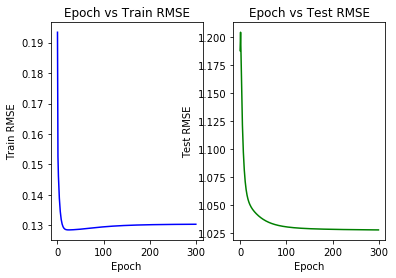

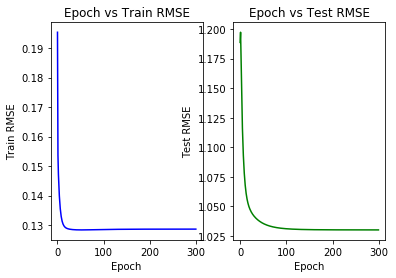

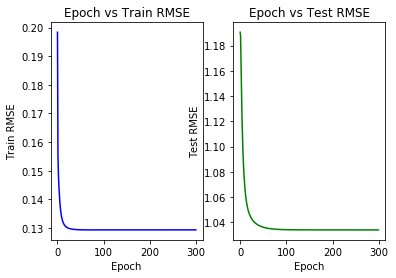

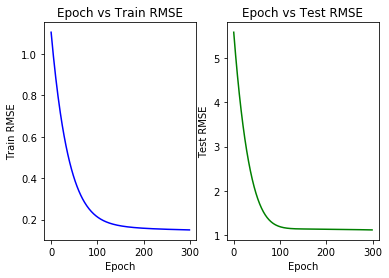

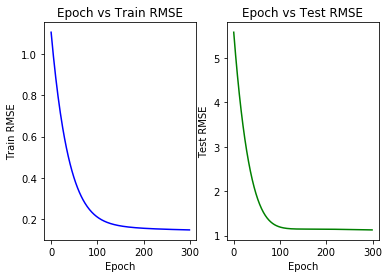

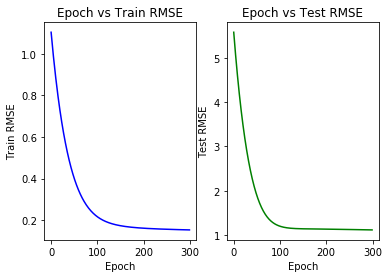

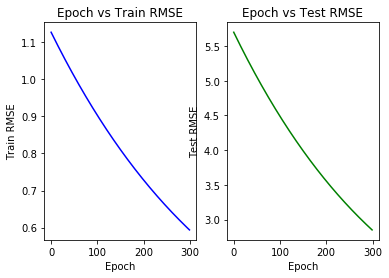

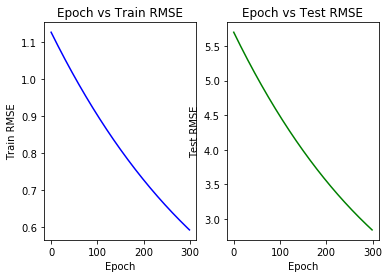

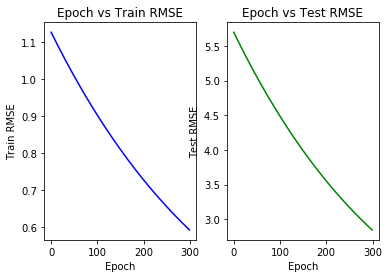

In [32]:
#Calling function for different combinations of alpha and lamda
ii_1,rmse_1,rmseTest_1 = mini_BGD(train,xTest,yTest,0.001,0.1,50,300)
ii_2,rmse_2,rmseTest_2 = mini_BGD(train,xTest,yTest,0.001,0.3,50,300)
ii_3,rmse_3,rmseTest_3 = mini_BGD(train,xTest,yTest,0.001,0.6,50,300)
ii_4,rmse_4,rmseTest_4 = mini_BGD(train,xTest,yTest,0.00001,0.3,50,300)
ii_5,rmse_5,rmseTest_5 = mini_BGD(train,xTest,yTest,0.00001,0.1,50,300)
ii_6,rmse_6,rmseTest_6 = mini_BGD(train,xTest,yTest,0.00001,0.6,50,300)
ii_7,rmse_7,rmseTest_7 = mini_BGD(train,xTest,yTest,0.000001,0.6,50,300)
ii_8,rmse_8,rmseTest_8 = mini_BGD(train,xTest,yTest,0.000001,0.1,50,300)
ii_9,rmse_9,rmseTest_9 = mini_BGD(train,xTest,yTest,0.000001,0.3,50,300)
plot(ii_1,rmse_1,rmseTest_1)
plot(ii_2,rmse_2,rmseTest_2)
plot(ii_3,rmse_3,rmseTest_3)
plot(ii_4,rmse_4,rmseTest_4)
plot(ii_5,rmse_5,rmseTest_5)
plot(ii_6,rmse_6,rmseTest_6)
plot(ii_7,rmse_7,rmseTest_7)
plot(ii_8,rmse_8,rmseTest_8)
plot(ii_9,rmse_9,rmseTest_9)

Exercise 2: Hyper-parameter tuning and Cross validation

In [14]:
#defining grid values for alpha and lambda
alphaGrid = np.arange(0.0001, 0.0021, 0.0002)
lamdaGrid = np.arange(0.1,1,0.1)
#alphaGrid = np.arange(0.0001, 0.0003, 0.0001)
#lamdaGrid = np.arange(0.1,1,0.1)
print("Alpha Grid : ",alphaGrid)
print("\n\nLambda Grid : ",lamdaGrid)

Alpha Grid :  [ 0.0001  0.0003  0.0005  0.0007  0.0009  0.0011  0.0013  0.0015  0.0017
  0.0019]


Lambda Grid :  [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]


In [15]:
#returns the test and train data for each fold of cross validation
def cvTestTrain(trainA,testFold,totalFolds):
    trainCv = pd.DataFrame([])
    testCv = pd.DataFrame([])
    #Extracting column names
    cols = trainA.columns.values
    #Removing colunm names
    trainA.columns = [''] * len(trainA.columns)
    #Data split to folds
    batch = np.array_split(trainA,totalFolds)
    key = 1
    trainDict = {}
    #Creating the test fold
    for each in batch:
        trainDict[key] = each
        key = key + 1
    testCv = trainDict[testFold]
    testCv.columns = cols
    #Creating train fold
    for key in range(1,6):
        if(key != testFold):
            trainCv = trainCv.append(trainDict[key])
    #Adding the column names to merged train datset
    trainCv.columns = cols
    return(trainCv,testCv)

In [18]:
#CrossValidation
def cv(trainCvalid,alphaGrid,lamdaGrid,totalFolds,batchsize,epoch):
    alpha,lamda,rmseCv = [],[],[]
    for eachAlpha in alphaGrid:
        for eachLamda in lamdaGrid:
            alpha.append(eachAlpha)
            lamda.append(eachLamda)
            eachFoldRmse = []
            for each in range(1,totalFolds+1):
                print("alpha,lambda",eachAlpha,eachLamda)
                trainC = trainCvalid.copy()
                trainCv,testCv = cvTestTrain(trainC,each,totalFolds)
                xTest = testRed.loc[:,testCv.columns != 'quality']
                yTest = testRed.loc[:,testCv.columns == 'quality']
                #print(trainCv.shape)
                ii,rmse,rmseTest = mini_BGD(trainCv,xTest,yTest,eachAlpha,eachLamda,batchsize,epoch)
                eachFoldRmse.append(np.mean(rmseTest))
            temp = (np.mean(eachFoldRmse))
            print(float(temp))
            rmseCv.append(float(temp))
            print(len(rmse))
    return(alpha,lamda,rmseCv)

In [20]:
#Calling function cv
alpha1,lamda1,rmse1 = cv(train,alphaGrid,lamdaGrid,5,50,100)    

alpha,lambda 0.0001 0.1
alpha,lambda 0.0001 0.1
alpha,lambda 0.0001 0.1
alpha,lambda 0.0001 0.1
alpha,lambda 0.0001 0.1
96.25841208430148
100
alpha,lambda 0.0001 0.2
alpha,lambda 0.0001 0.2
alpha,lambda 0.0001 0.2
alpha,lambda 0.0001 0.2
alpha,lambda 0.0001 0.2
96.14516028904725
100
alpha,lambda 0.0001 0.3
alpha,lambda 0.0001 0.3
alpha,lambda 0.0001 0.3
alpha,lambda 0.0001 0.3
alpha,lambda 0.0001 0.3
96.0309086561593
100
alpha,lambda 0.0001 0.4
alpha,lambda 0.0001 0.4
alpha,lambda 0.0001 0.4
alpha,lambda 0.0001 0.4
alpha,lambda 0.0001 0.4
95.91569118449237
100
alpha,lambda 0.0001 0.5
alpha,lambda 0.0001 0.5
alpha,lambda 0.0001 0.5
alpha,lambda 0.0001 0.5
alpha,lambda 0.0001 0.5
95.79954106977456
100
alpha,lambda 0.0001 0.6
alpha,lambda 0.0001 0.6
alpha,lambda 0.0001 0.6
alpha,lambda 0.0001 0.6
alpha,lambda 0.0001 0.6
95.68249071864784
100
alpha,lambda 0.0001 0.7
alpha,lambda 0.0001 0.7
alpha,lambda 0.0001 0.7
alpha,lambda 0.0001 0.7
alpha,lambda 0.0001 0.7
95.5645717628537
100
alpha,la

Optimal beta found : 
                        quality
fixed acidity         1.947067
volatile acidity      1.220301
citric acid           1.368181
residual sugar        0.171947
chlorides             0.577418
free sulfur dioxide   0.944974
total sulfur dioxide  0.267040
density               2.273332
pH                    3.430321
sulphates             1.377022
alcohol               3.250331
Optimal beta found : 
                        quality
fixed acidity         1.949082
volatile acidity      1.217027
citric acid           1.368349
residual sugar        0.171557
chlorides             0.577325
free sulfur dioxide   0.943036
total sulfur dioxide  0.264000
density               2.272169
pH                    3.431453
sulphates             1.376945
alcohol               3.254173
Optimal beta found : 
                        quality
fixed acidity         1.951076
volatile acidity      1.213803
citric acid           1.368484
residual sugar        0.171173
chlorides             0.577240
f

Optimal beta found : 
                        quality
fixed acidity         1.985064
volatile acidity      1.160570
citric acid           1.365962
residual sugar        0.164920
chlorides             0.577088
free sulfur dioxide   0.911966
total sulfur dioxide  0.213498
density               2.254856
pH                    3.452464
sulphates             1.375262
alcohol               3.315155
Optimal beta found : 
                        quality
fixed acidity         1.986668
volatile acidity      1.158132
citric acid           1.365616
residual sugar        0.164639
chlorides             0.577143
free sulfur dioxide   0.910740
total sulfur dioxide  0.211419
density               2.254228
pH                    3.453424
sulphates             1.375173
alcohol               3.317529
alpha,lambda 0.0003 0.5
alpha,lambda 0.0003 0.5
alpha,lambda 0.0003 0.5
91.61008489396397
100
alpha,lambda 0.0003 0.6
alpha,lambda 0.0003 0.6
Optimal beta found : 
                        quality
fixed acidity 

Optimal beta found : 
                        quality
fixed acidity         1.940744
volatile acidity      1.234199
citric acid           1.388270
residual sugar        0.219985
chlorides             0.587083
free sulfur dioxide   0.945102
total sulfur dioxide  0.281046
density               2.289188
pH                    3.396018
sulphates             1.354372
alcohol               3.200969
Optimal beta found : 
                        quality
fixed acidity         1.942576
volatile acidity      1.231163
citric acid           1.388293
residual sugar        0.219608
chlorides             0.586981
free sulfur dioxide   0.943348
total sulfur dioxide  0.278197
density               2.288060
pH                    3.397194
sulphates             1.354303
alcohol               3.204632
Optimal beta found : 
                        quality
fixed acidity         1.944386
volatile acidity      1.228172
citric acid           1.388287
residual sugar        0.219236
chlorides             0.586888
f

Optimal beta found : 
                        quality
fixed acidity         1.975109
volatile acidity      1.178993
citric acid           1.383918
residual sugar        0.213198
chlorides             0.586522
free sulfur dioxide   0.915453
total sulfur dioxide  0.231213
density               2.271193
pH                    3.418355
sulphates             1.352813
alcohol               3.262231
Optimal beta found : 
                        quality
fixed acidity         1.976554
volatile acidity      1.176753
citric acid           1.383515
residual sugar        0.212928
chlorides             0.586565
free sulfur dioxide   0.914365
total sulfur dioxide  0.229297
density               2.270583
pH                    3.419301
sulphates             1.352736
alcohol               3.264452
alpha,lambda 0.0003 0.6
alpha,lambda 0.0003 0.6
alpha,lambda 0.0003 0.6
91.78629778125372
100
alpha,lambda 0.0003 0.7
alpha,lambda 0.0003 0.7
Optimal beta found : 
                        quality
fixed acidity 

Optimal beta found : 
                        quality
fixed acidity         1.925573
volatile acidity      1.260806
citric acid           1.397806
residual sugar        0.250579
chlorides             0.593944
free sulfur dioxide   0.958511
total sulfur dioxide  0.309925
density               2.307343
pH                    3.362828
sulphates             1.340480
alcohol               3.138759
Optimal beta found : 
                        quality
fixed acidity         1.927412
volatile acidity      1.257707
citric acid           1.397976
residual sugar        0.250266
chlorides             0.593811
free sulfur dioxide   0.956657
total sulfur dioxide  0.306965
density               2.306124
pH                    3.363989
sulphates             1.340383
alcohol               3.142642
Optimal beta found : 
                        quality
fixed acidity         1.929227
volatile acidity      1.254660
citric acid           1.398115
residual sugar        0.249959
chlorides             0.593689
f

Optimal beta found : 
                        quality
fixed acidity         1.962490
volatile acidity      1.200717
citric acid           1.395337
residual sugar        0.244685
chlorides             0.592893
free sulfur dioxide   0.925148
total sulfur dioxide  0.254679
density               2.286708
pH                    3.386596
sulphates             1.338182
alcohol               3.207783
Optimal beta found : 
                        quality
fixed acidity         1.963873
volatile acidity      1.198555
citric acid           1.395003
residual sugar        0.244482
chlorides             0.592924
free sulfur dioxide   0.924068
total sulfur dioxide  0.252799
density               2.286095
pH                    3.387497
sulphates             1.338084
alcohol               3.209985
Optimal beta found : 
                        quality
fixed acidity         1.965240
volatile acidity      1.196425
citric acid           1.394657
residual sugar        0.244283
chlorides             0.592962
f

Optimal beta found : 
                        quality
fixed acidity         1.907928
volatile acidity      1.292128
citric acid           1.405499
residual sugar        0.279632
chlorides             0.601008
free sulfur dioxide   0.975636
total sulfur dioxide  0.344179
density               2.327962
pH                    3.328282
sulphates             1.327660
alcohol               3.069301
Optimal beta found : 
                        quality
fixed acidity         1.909836
volatile acidity      1.288824
citric acid           1.405877
residual sugar        0.279340
chlorides             0.600815
free sulfur dioxide   0.973571
total sulfur dioxide  0.340947
density               2.326542
pH                    3.329484
sulphates             1.327547
alcohol               3.073684
Optimal beta found : 
                        quality
fixed acidity         1.911716
volatile acidity      1.285578
citric acid           1.406217
residual sugar        0.279053
chlorides             0.600633
f

Optimal beta found : 
                        quality
fixed acidity         1.942884
volatile acidity      1.233533
citric acid           1.406945
residual sugar        0.274627
chlorides             0.598882
free sulfur dioxide   0.941182
total sulfur dioxide  0.288570
density               2.305506
pH                    3.350866
sulphates             1.325225
alcohol               3.141522
Optimal beta found : 
                        quality
fixed acidity         1.944315
volatile acidity      1.231226
citric acid           1.406753
residual sugar        0.274440
chlorides             0.598865
free sulfur dioxide   0.939938
total sulfur dioxide  0.286476
density               2.304753
pH                    3.351807
sulphates             1.325110
alcohol               3.144090
Optimal beta found : 
                        quality
fixed acidity         1.945727
volatile acidity      1.228957
citric acid           1.406543
residual sugar        0.274258
chlorides             0.598854
f

Optimal beta found : 
                        quality
fixed acidity         1.691561
volatile acidity      1.410302
citric acid           1.052122
residual sugar        0.238077
chlorides             0.636138
free sulfur dioxide   0.852211
total sulfur dioxide  0.319228
density               2.444755
pH                    3.469876
sulphates             1.408473
alcohol               2.533729
Optimal beta found : 
                        quality
fixed acidity         1.694153
volatile acidity      1.410439
citric acid           1.049768
residual sugar        0.238088
chlorides             0.635339
free sulfur dioxide   0.849484
total sulfur dioxide  0.318225
density               2.447868
pH                    3.470217
sulphates             1.406724
alcohol               2.529425
Optimal beta found : 
                        quality
fixed acidity         1.696737
volatile acidity      1.410579
citric acid           1.047441
residual sugar        0.238102
chlorides             0.634552
f

Optimal beta found : 
                        quality
fixed acidity         1.777569
volatile acidity      1.358974
citric acid           1.295409
residual sugar        0.360311
chlorides             0.699926
free sulfur dioxide   0.922871
total sulfur dioxide  0.357791
density               2.304142
pH                    3.361062
sulphates             1.335166
alcohol               2.876826
Optimal beta found : 
                        quality
fixed acidity         1.780491
volatile acidity      1.357285
citric acid           1.289588
residual sugar        0.356603
chlorides             0.699167
free sulfur dioxide   0.919311
total sulfur dioxide  0.352944
density               2.304390
pH                    3.366847
sulphates             1.335481
alcohol               2.878979
Optimal beta found : 
                        quality
fixed acidity         1.783374
volatile acidity      1.355528
citric acid           1.283936
residual sugar        0.352956
chlorides             0.698429
f

Optimal beta found : 
                        quality
fixed acidity         1.874792
volatile acidity      1.351115
citric acid           1.400797
residual sugar        0.301430
chlorides             0.609002
free sulfur dioxide   1.013706
total sulfur dioxide  0.406790
density               2.360941
pH                    3.290142
sulphates             1.320092
alcohol               2.963577
Optimal beta found : 
                        quality
fixed acidity         1.876905
volatile acidity      1.346798
citric acid           1.401747
residual sugar        0.301087
chlorides             0.608580
free sulfur dioxide   1.010783
total sulfur dioxide  0.402534
density               2.358626
pH                    3.291131
sulphates             1.319834
alcohol               2.969354
Optimal beta found : 
                        quality
fixed acidity         1.879046
volatile acidity      1.342621
citric acid           1.402688
residual sugar        0.300775
chlorides             0.608201
f

Optimal beta found : 
                        quality
fixed acidity         1.915658
volatile acidity      1.278589
citric acid           1.412910
residual sugar        0.296755
chlorides             0.604230
free sulfur dioxide   0.966919
total sulfur dioxide  0.335613
density               2.328318
pH                    3.313433
sulphates             1.316659
alcohol               3.060419
Optimal beta found : 
                        quality
fixed acidity         1.917312
volatile acidity      1.275825
citric acid           1.413073
residual sugar        0.296600
chlorides             0.604127
free sulfur dioxide   0.965253
total sulfur dioxide  0.332974
density               2.327258
pH                    3.314448
sulphates             1.316508
alcohol               3.063848
Optimal beta found : 
                        quality
fixed acidity         1.918942
volatile acidity      1.273111
citric acid           1.413208
residual sugar        0.296449
chlorides             0.604033
f

Optimal beta found : 
                        quality
fixed acidity         1.945813
volatile acidity      1.229700
citric acid           1.411506
residual sugar        0.294295
chlorides             0.603555
free sulfur dioxide   0.939345
total sulfur dioxide  0.290515
density               2.311758
pH                    3.332328
sulphates             1.313613
alcohol               3.116464
Optimal beta found : 
                        quality
fixed acidity         1.947039
volatile acidity      1.227782
citric acid           1.411250
residual sugar        0.294213
chlorides             0.603586
free sulfur dioxide   0.938360
total sulfur dioxide  0.288831
density               2.311212
pH                    3.333109
sulphates             1.313478
alcohol               3.118436
Optimal beta found : 
                        quality
fixed acidity         1.948248
volatile acidity      1.225895
citric acid           1.410981
residual sugar        0.294134
chlorides             0.603622
f

Optimal beta found : 
                        quality
fixed acidity         1.700890
volatile acidity      1.470117
citric acid           1.070758
residual sugar        0.306877
chlorides             0.631040
free sulfur dioxide   0.873249
total sulfur dioxide  0.385673
density               2.513456
pH                    3.364259
sulphates             1.337462
alcohol               2.391510
Optimal beta found : 
                        quality
fixed acidity         1.703278
volatile acidity      1.470113
citric acid           1.068328
residual sugar        0.306688
chlorides             0.630276
free sulfur dioxide   0.870387
total sulfur dioxide  0.384434
density               2.516286
pH                    3.365153
sulphates             1.335987
alcohol               2.387927
Optimal beta found : 
                        quality
fixed acidity         1.705655
volatile acidity      1.470106
citric acid           1.065921
residual sugar        0.306501
chlorides             0.629522
f

Optimal beta found : 
                        quality
fixed acidity         1.752329
volatile acidity      1.468808
citric acid           1.020014
residual sugar        0.302719
chlorides             0.615630
free sulfur dioxide   0.812951
total sulfur dioxide  0.361320
density               2.574019
pH                    3.383596
sulphates             1.307056
alcohol               2.315362
Optimal beta found : 
                        quality
fixed acidity         1.754392
volatile acidity      1.468688
citric acid           1.018023
residual sugar        0.302542
chlorides             0.615048
free sulfur dioxide   0.810566
total sulfur dioxide  0.360434
density               2.576426
pH                    3.384364
sulphates             1.305878
alcohol               2.312323
Optimal beta found : 
                        quality
fixed acidity         1.756441
volatile acidity      1.468563
citric acid           1.016047
residual sugar        0.302365
chlorides             0.614473
f

Optimal beta found : 
                        quality
fixed acidity         1.803586
volatile acidity      1.425513
citric acid           1.313484
residual sugar        0.419980
chlorides             0.683930
free sulfur dioxide   0.957607
total sulfur dioxide  0.431972
density               2.415875
pH                    3.236800
sulphates             1.278233
alcohol               2.678391
Optimal beta found : 
                        quality
fixed acidity         1.805525
volatile acidity      1.426360
citric acid           1.307604
residual sugar        0.418551
chlorides             0.682257
free sulfur dioxide   0.954845
total sulfur dioxide  0.429489
density               2.418491
pH                    3.237723
sulphates             1.275930
alcohol               2.673899
Optimal beta found : 
                        quality
fixed acidity         1.807523
volatile acidity      1.427257
citric acid           1.301818
residual sugar        0.417150
chlorides             0.680628
f

Optimal beta found : 
                        quality
fixed acidity         1.849685
volatile acidity      1.388167
citric acid           1.204174
residual sugar        0.350440
chlorides             0.663241
free sulfur dioxide   0.890463
total sulfur dioxide  0.337801
density               2.404700
pH                    3.352361
sulphates             1.282850
alcohol               2.747218
Optimal beta found : 
                        quality
fixed acidity         1.851770
volatile acidity      1.389008
citric acid           1.199244
residual sugar        0.349287
chlorides             0.661934
free sulfur dioxide   0.888311
total sulfur dioxide  0.336047
density               2.407608
pH                    3.352658
sulphates             1.280963
alcohol               2.742355
Optimal beta found : 
                        quality
fixed acidity         1.853894
volatile acidity      1.389884
citric acid           1.194385
residual sugar        0.348154
chlorides             0.660661
f

Optimal beta found : 
                        quality
fixed acidity         2.052072
volatile acidity      1.069723
citric acid           1.296741
residual sugar        0.035648
chlorides             0.561288
free sulfur dioxide   0.909708
total sulfur dioxide  0.162104
density               2.227932
pH                    3.531710
sulphates             1.427324
alcohol               3.427790
Optimal beta found : 
                        quality
fixed acidity         2.056772
volatile acidity      1.063341
citric acid           1.293125
residual sugar        0.031550
chlorides             0.561428
free sulfur dioxide   0.909106
total sulfur dioxide  0.158495
density               2.227080
pH                    3.534322
sulphates             1.428531
alcohol               3.431614
Optimal beta found : 
                        quality
fixed acidity         2.063476
volatile acidity      1.054523
citric acid           1.286210
residual sugar        0.023407
chlorides             0.561474
f

Optimal beta found : 
                        quality
fixed acidity         1.952225
volatile acidity      1.231841
citric acid           1.393971
residual sugar        0.215613
chlorides             0.586850
free sulfur dioxide   0.937795
total sulfur dioxide  0.278516
density               2.292897
pH                    3.416705
sulphates             1.359269
alcohol               3.229656
Optimal beta found : 
                        quality
fixed acidity         1.955277
volatile acidity      1.226262
citric acid           1.393671
residual sugar        0.214452
chlorides             0.586442
free sulfur dioxide   0.934760
total sulfur dioxide  0.273120
density               2.290325
pH                    3.419247
sulphates             1.359263
alcohol               3.237128
Optimal beta found : 
                        quality
fixed acidity         1.958281
volatile acidity      1.220814
citric acid           1.393299
residual sugar        0.213313
chlorides             0.586067
f

Optimal beta found : 
                        quality
fixed acidity         2.007525
volatile acidity      1.137461
citric acid           1.376905
residual sugar        0.195423
chlorides             0.583764
free sulfur dioxide   0.893047
total sulfur dioxide  0.193288
density               2.257189
pH                    3.460963
sulphates             1.359006
alcohol               3.339744
Optimal beta found : 
                        quality
fixed acidity         2.009767
volatile acidity      1.133924
citric acid           1.375737
residual sugar        0.194650
chlorides             0.583837
free sulfur dioxide   0.891696
total sulfur dioxide  0.190414
density               2.256204
pH                    3.462652
sulphates             1.358995
alcohol               3.343100
Optimal beta found : 
                        quality
fixed acidity         2.011980
volatile acidity      1.130456
citric acid           1.374552
residual sugar        0.193892
chlorides             0.583925
f

Optimal beta found : 
                        quality
fixed acidity         2.049037
volatile acidity      1.075319
citric acid           1.350476
residual sugar        0.181854
chlorides             0.587705
free sulfur dioxide   0.873705
total sulfur dioxide  0.147622
density               2.243896
pH                    3.490439
sulphates             1.358869
alcohol               3.389099
Optimal beta found : 
                        quality
fixed acidity         2.050756
volatile acidity      1.072888
citric acid           1.349190
residual sugar        0.181329
chlorides             0.587986
free sulfur dioxide   0.873152
total sulfur dioxide  0.146071
density               2.243547
pH                    3.491573
sulphates             1.358868
alcohol               3.390599
Optimal beta found : 
                        quality
fixed acidity         2.052454
volatile acidity      1.070496
citric acid           1.347906
residual sugar        0.180813
chlorides             0.588272
f

Optimal beta found : 
                        quality
fixed acidity         1.922045
volatile acidity      1.292651
citric acid           1.412372
residual sugar        0.271378
chlorides             0.601055
free sulfur dioxide   0.968470
total sulfur dioxide  0.340572
density               2.333945
pH                    3.360521
sulphates             1.338002
alcohol               3.110462
Optimal beta found : 
                        quality
fixed acidity         1.925218
volatile acidity      1.286210
citric acid           1.412535
residual sugar        0.269991
chlorides             0.600309
free sulfur dioxide   0.964643
total sulfur dioxide  0.333947
density               2.330296
pH                    3.363605
sulphates             1.338024
alcohol               3.120373
Optimal beta found : 
                        quality
fixed acidity         1.928335
volatile acidity      1.279939
citric acid           1.412600
residual sugar        0.268634
chlorides             0.599608
f

Optimal beta found : 
                        quality
fixed acidity         1.978794
volatile acidity      1.186497
citric acid           1.401220
residual sugar        0.247601
chlorides             0.592896
free sulfur dioxide   0.912457
total sulfur dioxide  0.237522
density               2.283275
pH                    3.412884
sulphates             1.338283
alcohol               3.254861
Optimal beta found : 
                        quality
fixed acidity         1.981061
volatile acidity      1.182648
citric acid           1.400201
residual sugar        0.246705
chlorides             0.592807
free sulfur dioxide   0.910781
total sulfur dioxide  0.234118
density               2.281872
pH                    3.414820
sulphates             1.338296
alcohol               3.259192
Optimal beta found : 
                        quality
fixed acidity         1.983294
volatile acidity      1.178883
citric acid           1.399160
residual sugar        0.245828
chlorides             0.592738
f

Optimal beta found : 
                        quality
fixed acidity         2.020255
volatile acidity      1.120450
citric acid           1.376972
residual sugar        0.232073
chlorides             0.594241
free sulfur dioxide   0.888522
total sulfur dioxide  0.184207
density               2.264219
pH                    3.445863
sulphates             1.338640
alcohol               3.317875
Optimal beta found : 
                        quality
fixed acidity         2.021948
volatile acidity      1.117938
citric acid           1.375760
residual sugar        0.231481
chlorides             0.594429
free sulfur dioxide   0.887838
total sulfur dioxide  0.182431
density               2.263711
pH                    3.447093
sulphates             1.338662
alcohol               3.319760
Optimal beta found : 
                        quality
fixed acidity         2.023617
volatile acidity      1.115473
citric acid           1.374549
residual sugar        0.230900
chlorides             0.594625
f

Optimal beta found : 
                        quality
fixed acidity         2.051544
volatile acidity      1.076043
citric acid           1.352434
residual sugar        0.221719
chlorides             0.599399
free sulfur dioxide   0.879232
total sulfur dioxide  0.156256
density               2.257513
pH                    3.467058
sulphates             1.339137
alcohol               3.345232
alpha,lambda 0.0005 0.6
alpha,lambda 0.0005 0.6
alpha,lambda 0.0005 0.6
89.31755904633174
100
alpha,lambda 0.0005 0.7
alpha,lambda 0.0005 0.7
Optimal beta found : 
                        quality
fixed acidity         1.878057
volatile acidity      1.390713
citric acid           1.414000
residual sugar        0.320887
chlorides             0.621051
free sulfur dioxide   1.029622
total sulfur dioxide  0.448186
density               2.404499
pH                    3.290024
sulphates             1.322893
alcohol               2.917703
Optimal beta found : 
                        quality
fixed acidity 

Optimal beta found : 
                        quality
fixed acidity         1.942976
volatile acidity      1.251810
citric acid           1.421326
residual sugar        0.291381
chlorides             0.602642
free sulfur dioxide   0.944459
total sulfur dioxide  0.302308
density               2.319376
pH                    3.357723
sulphates             1.322942
alcohol               3.142514
Optimal beta found : 
                        quality
fixed acidity         1.945501
volatile acidity      1.247015
citric acid           1.420741
residual sugar        0.290301
chlorides             0.602248
free sulfur dioxide   0.941921
total sulfur dioxide  0.297602
density               2.317027
pH                    3.360179
sulphates             1.322942
alcohol               3.149155
Optimal beta found : 
                        quality
fixed acidity         1.947984
volatile acidity      1.242342
citric acid           1.420107
residual sugar        0.289245
chlorides             0.601886
f

Optimal beta found : 
                        quality
fixed acidity         1.991880
volatile acidity      1.166485
citric acid           1.400083
residual sugar        0.271662
chlorides             0.599602
free sulfur dioxide   0.906055
total sulfur dioxide  0.225140
density               2.285655
pH                    3.401614
sulphates             1.323084
alcohol               3.243593
Optimal beta found : 
                        quality
fixed acidity         1.993636
volatile acidity      1.163703
citric acid           1.398973
residual sugar        0.271006
chlorides             0.599675
free sulfur dioxide   0.905093
total sulfur dioxide  0.222924
density               2.284874
pH                    3.403030
sulphates             1.323099
alcohol               3.246186
Optimal beta found : 
                        quality
fixed acidity         1.995367
volatile acidity      1.160979
citric acid           1.397860
residual sugar        0.270364
chlorides             0.599760
f

Optimal beta found : 
                        quality
fixed acidity         2.023877
volatile acidity      1.118506
citric acid           1.376973
residual sugar        0.260386
chlorides             0.602938
free sulfur dioxide   0.892790
total sulfur dioxide  0.190763
density               2.275281
pH                    3.425481
sulphates             1.323484
alcohol               3.280835
Optimal beta found : 
                        quality
fixed acidity         2.025174
volatile acidity      1.116675
citric acid           1.375924
residual sugar        0.259961
chlorides             0.603162
free sulfur dioxide   0.892434
total sulfur dioxide  0.189634
density               2.275014
pH                    3.426361
sulphates             1.323506
alcohol               3.281928
Optimal beta found : 
                        quality
fixed acidity         2.026452
volatile acidity      1.114878
citric acid           1.374883
residual sugar        0.259545
chlorides             0.603389
f

Optimal beta found : 
                        quality
fixed acidity         1.899486
volatile acidity      1.340372
citric acid           1.429801
residual sugar        0.331930
chlorides             0.617325
free sulfur dioxide   0.996693
total sulfur dioxide  0.397550
density               2.375962
pH                    3.292454
sulphates             1.311276
alcohol               2.979216
Optimal beta found : 
                        quality
fixed acidity         1.902577
volatile acidity      1.333599
citric acid           1.430309
residual sugar        0.330543
chlorides             0.616355
free sulfur dioxide   0.992424
total sulfur dioxide  0.390310
density               2.371641
pH                    3.295814
sulphates             1.311247
alcohol               2.990564
Optimal beta found : 
                        quality
fixed acidity         1.905605
volatile acidity      1.327030
citric acid           1.430702
residual sugar        0.329191
chlorides             0.615441
f

Optimal beta found : 
                        quality
fixed acidity         1.953395
volatile acidity      1.232454
citric acid           1.423839
residual sugar        0.308894
chlorides             0.605957
free sulfur dioxide   0.935481
total sulfur dioxide  0.287889
density               2.316995
pH                    3.347623
sulphates             1.310703
alcohol               3.140743
Optimal beta found : 
                        quality
fixed acidity         1.955483
volatile acidity      1.228711
citric acid           1.423014
residual sugar        0.308061
chlorides             0.605766
free sulfur dioxide   0.933701
total sulfur dioxide  0.284398
density               2.315403
pH                    3.349575
sulphates             1.310685
alcohol               3.145426
Optimal beta found : 
                        quality
fixed acidity         1.957535
volatile acidity      1.225062
citric acid           1.422163
residual sugar        0.307248
chlorides             0.605598
f

Optimal beta found : 
                        quality
fixed acidity         1.993578
volatile acidity      1.165806
citric acid           1.401495
residual sugar        0.293874
chlorides             0.605753
free sulfur dioxide   0.909131
total sulfur dioxide  0.231257
density               2.294581
pH                    3.382051
sulphates             1.310569
alcohol               3.211076
Optimal beta found : 
                        quality
fixed acidity         1.995006
volatile acidity      1.163635
citric acid           1.400479
residual sugar        0.293383
chlorides             0.605882
free sulfur dioxide   0.908496
total sulfur dioxide  0.229657
density               2.294078
pH                    3.383145
sulphates             1.310574
alcohol               3.212845
Optimal beta found : 
                        quality
fixed acidity         1.996412
volatile acidity      1.161511
citric acid           1.399466
residual sugar        0.292903
chlorides             0.606019
f

Optimal beta found : 
                        quality
fixed acidity         2.019347
volatile acidity      1.128511
citric acid           1.381379
residual sugar        0.285542
chlorides             0.609540
free sulfur dioxide   0.900635
total sulfur dioxide  0.206695
density               2.288022
pH                    3.400311
sulphates             1.310772
alcohol               3.236149
Optimal beta found : 
                        quality
fixed acidity         2.020378
volatile acidity      1.127097
citric acid           1.380506
residual sugar        0.285233
chlorides             0.609757
free sulfur dioxide   0.900419
total sulfur dioxide  0.205900
density               2.287858
pH                    3.400977
sulphates             1.310785
alcohol               3.236871
Optimal beta found : 
                        quality
fixed acidity         2.021393
volatile acidity      1.125710
citric acid           1.379642
residual sugar        0.284931
chlorides             0.609974
f

Optimal beta found : 
                        quality
fixed acidity         1.745520
volatile acidity      1.392751
citric acid           0.999676
residual sugar        0.217608
chlorides             0.623019
free sulfur dioxide   0.792863
total sulfur dioxide  0.287945
density               2.490176
pH                    3.499715
sulphates             1.390681
alcohol               2.476012
Optimal beta found : 
                        quality
fixed acidity         1.749353
volatile acidity      1.392992
citric acid           0.996471
residual sugar        0.217777
chlorides             0.621992
free sulfur dioxide   0.789148
total sulfur dioxide  0.286975
density               2.494888
pH                    3.500082
sulphates             1.388158
alcohol               2.469516
Optimal beta found : 
                        quality
fixed acidity         1.753142
volatile acidity      1.393218
citric acid           0.993304
residual sugar        0.217942
chlorides             0.620981
f

alpha,lambda 0.0005 0.8
Optimal beta found : 
                        quality
fixed acidity         1.772526
volatile acidity      1.341484
citric acid           1.313335
residual sugar        0.352046
chlorides             0.708262
free sulfur dioxide   0.924035
total sulfur dioxide  0.352412
density               2.280921
pH                    3.384690
sulphates             1.351613
alcohol               2.928635
Optimal beta found : 
                        quality
fixed acidity         1.776490
volatile acidity      1.343204
citric acid           1.303907
residual sugar        0.349992
chlorides             0.705570
free sulfur dioxide   0.919841
total sulfur dioxide  0.348748
density               2.286192
pH                    3.385141
sulphates             1.347664
alcohol               2.919722
Optimal beta found : 
                        quality
fixed acidity         1.780587
volatile acidity      1.345043
citric acid           1.294709
residual sugar        0.348002
chloride

89.852983587768
100
alpha,lambda 0.0005 0.9
alpha,lambda 0.0005 0.9
Optimal beta found : 
                        quality
fixed acidity         1.860352
volatile acidity      1.433063
citric acid           1.423568
residual sugar        0.370900
chlorides             0.637192
free sulfur dioxide   1.058893
total sulfur dioxide  0.503441
density               2.447603
pH                    3.226438
sulphates             1.300659
alcohol               2.786486
Optimal beta found : 
                        quality
fixed acidity         1.863961
volatile acidity      1.423585
citric acid           1.425606
residual sugar        0.369059
chlorides             0.635393
free sulfur dioxide   1.052301
total sulfur dioxide  0.492912
density               2.440310
pH                    3.230722
sulphates             1.300543
alcohol               2.804112
Optimal beta found : 
                        quality
fixed acidity         1.867549
volatile acidity      1.414483
citric acid           1.42

Optimal beta found : 
                        quality
fixed acidity         1.923579
volatile acidity      1.288796
citric acid           1.437240
residual sugar        0.341587
chlorides             0.614828
free sulfur dioxide   0.965895
total sulfur dioxide  0.347436
density               2.350805
pH                    3.298474
sulphates             1.299559
alcohol               3.035940
Optimal beta found : 
                        quality
fixed acidity         1.925964
volatile acidity      1.284028
citric acid           1.436847
residual sugar        0.340558
chlorides             0.614327
free sulfur dioxide   0.963208
total sulfur dioxide  0.342588
density               2.348212
pH                    3.300984
sulphates             1.299519
alcohol               3.043059
Optimal beta found : 
                        quality
fixed acidity         1.928302
volatile acidity      1.279399
citric acid           1.436400
residual sugar        0.339554
chlorides             0.613862
f

Optimal beta found : 
                        quality
fixed acidity         1.965304
volatile acidity      1.212152
citric acid           1.421818
residual sugar        0.324597
chlorides             0.610004
free sulfur dioxide   0.928141
total sulfur dioxide  0.274659
density               2.316083
pH                    3.339025
sulphates             1.299023
alcohol               3.136045
Optimal beta found : 
                        quality
fixed acidity         1.966920
volatile acidity      1.209467
citric acid           1.420887
residual sugar        0.323988
chlorides             0.609990
free sulfur dioxide   0.927078
total sulfur dioxide  0.272372
density               2.315173
pH                    3.340435
sulphates             1.299013
alcohol               3.138894
Optimal beta found : 
                        quality
fixed acidity         1.968507
volatile acidity      1.206848
citric acid           1.419950
residual sugar        0.323394
chlorides             0.609990
f

Optimal beta found : 
                        quality
fixed acidity         1.993974
volatile acidity      1.167374
citric acid           1.402295
residual sugar        0.314446
chlorides             0.611750
free sulfur dioxide   0.913635
total sulfur dioxide  0.240107
density               2.304154
pH                    3.362025
sulphates             1.299007
alcohol               3.176043
Optimal beta found : 
                        quality
fixed acidity         1.995099
volatile acidity      1.165736
citric acid           1.401414
residual sugar        0.314078
chlorides             0.611906
free sulfur dioxide   0.913249
total sulfur dioxide  0.239012
density               2.303852
pH                    3.362837
sulphates             1.299014
alcohol               3.177178
Optimal beta found : 
                        quality
fixed acidity         1.996205
volatile acidity      1.164133
citric acid           1.400541
residual sugar        0.313719
chlorides             0.612065
f

Optimal beta found : 
                        quality
fixed acidity         1.679697
volatile acidity      1.457719
citric acid           1.084477
residual sugar        0.292230
chlorides             0.638179
free sulfur dioxide   0.889365
total sulfur dioxide  0.385626
density               2.475951
pH                    3.378794
sulphates             1.362306
alcohol               2.448069
Optimal beta found : 
                        quality
fixed acidity         1.683653
volatile acidity      1.457602
citric acid           1.080033
residual sugar        0.291934
chlorides             0.636679
free sulfur dioxide   0.884229
total sulfur dioxide  0.383340
density               2.480601
pH                    3.379669
sulphates             1.359366
alcohol               2.441193
Optimal beta found : 
                        quality
fixed acidity         1.687656
volatile acidity      1.457548
citric acid           1.075725
residual sugar        0.291670
chlorides             0.635247
f

Optimal beta found : 
                        quality
fixed acidity         1.765948
volatile acidity      1.456510
citric acid           1.000893
residual sugar        0.287619
chlorides             0.612248
free sulfur dioxide   0.790125
total sulfur dioxide  0.347381
density               2.578568
pH                    3.404123
sulphates             1.308674
alcohol               2.312680
Optimal beta found : 
                        quality
fixed acidity         1.769245
volatile acidity      1.456327
citric acid           0.997847
residual sugar        0.287431
chlorides             0.611371
free sulfur dioxide   0.786466
total sulfur dioxide  0.346189
density               2.582456
pH                    3.405131
sulphates             1.306764
alcohol               2.307612
Optimal beta found : 
                        quality
fixed acidity         1.772504
volatile acidity      1.456131
citric acid           0.994842
residual sugar        0.287243
chlorides             0.610511
f

Optimal beta found : 
                        quality
fixed acidity         1.819945
volatile acidity      1.419766
citric acid           0.942344
residual sugar        0.259310
chlorides             0.598142
free sulfur dioxide   0.725311
total sulfur dioxide  0.309519
density               2.612710
pH                    3.459663
sulphates             1.302090
alcohol               2.281506
Optimal beta found : 
                        quality
fixed acidity         1.822748
volatile acidity      1.419627
citric acid           0.940071
residual sugar        0.259322
chlorides             0.597569
free sulfur dioxide   0.722498
total sulfur dioxide  0.309060
density               2.616098
pH                    3.459935
sulphates             1.300443
alcohol               2.276687
Optimal beta found : 
                        quality
fixed acidity         1.825519
volatile acidity      1.419485
citric acid           0.937826
residual sugar        0.259332
chlorides             0.597008
f

Optimal beta found : 
                        quality
fixed acidity         1.818474
volatile acidity      1.422626
citric acid           1.254553
residual sugar        0.394328
chlorides             0.672122
free sulfur dioxide   0.922581
total sulfur dioxide  0.395752
density               2.424296
pH                    3.272253
sulphates             1.267685
alcohol               2.672100
Optimal beta found : 
                        quality
fixed acidity         1.822490
volatile acidity      1.424593
citric acid           1.246167
residual sugar        0.392360
chlorides             0.669955
free sulfur dioxide   0.918946
total sulfur dioxide  0.392581
density               2.429898
pH                    3.274483
sulphates             1.264755
alcohol               2.665143
Optimal beta found : 
                        quality
fixed acidity         1.826515
volatile acidity      1.426545
citric acid           1.237902
residual sugar        0.390411
chlorides             0.667831
f

Optimal beta found : 
                        quality
fixed acidity         1.870161
volatile acidity      1.381982
citric acid           1.098400
residual sugar        0.318164
chlorides             0.640770
free sulfur dioxide   0.825842
total sulfur dioxide  0.297273
density               2.437177
pH                    3.374496
sulphates             1.250778
alcohol               2.647721
Optimal beta found : 
                        quality
fixed acidity         1.869379
volatile acidity      1.381371
citric acid           1.090778
residual sugar        0.316875
chlorides             0.638798
free sulfur dioxide   0.820837
total sulfur dioxide  0.295446
density               2.438339
pH                    3.373093
sulphates             1.247451
alcohol               2.637002
Optimal beta found : 
                        quality
fixed acidity         1.869305
volatile acidity      1.381329
citric acid           1.083841
residual sugar        0.315834
chlorides             0.637168
f

alpha,lambda 0.0007 0.1
alpha,lambda 0.0007 0.1
alpha,lambda 0.0007 0.1
alpha,lambda 0.0007 0.1
85.35222368101861
100
alpha,lambda 0.0007 0.2
alpha,lambda 0.0007 0.2
alpha,lambda 0.0007 0.2
alpha,lambda 0.0007 0.2
alpha,lambda 0.0007 0.2
86.11716760481747
100
alpha,lambda 0.0007 0.3
alpha,lambda 0.0007 0.3
alpha,lambda 0.0007 0.3
alpha,lambda 0.0007 0.3
alpha,lambda 0.0007 0.3
86.82419144339417
100
alpha,lambda 0.0007 0.4
alpha,lambda 0.0007 0.4
alpha,lambda 0.0007 0.4
alpha,lambda 0.0007 0.4
alpha,lambda 0.0007 0.4
87.47633666759666
100
alpha,lambda 0.0007 0.5
alpha,lambda 0.0007 0.5
Optimal beta found : 
                        quality
fixed acidity         1.918783
volatile acidity      1.317290
citric acid           1.397514
residual sugar        0.238314
chlorides             0.599552
free sulfur dioxide   0.982063
total sulfur dioxide  0.370964
density               2.351060
pH                    3.380336
sulphates             1.358993
alcohol               3.097559
Optimal beta 

Optimal beta found : 
                        quality
fixed acidity         2.005020
volatile acidity      1.152990
citric acid           1.386507
residual sugar        0.203139
chlorides             0.584914
free sulfur dioxide   0.897637
total sulfur dioxide  0.210686
density               2.268803
pH                    3.457807
sulphates             1.357072
alcohol               3.327614
Optimal beta found : 
                        quality
fixed acidity         2.008267
volatile acidity      1.147559
citric acid           1.384887
residual sugar        0.201908
chlorides             0.584843
free sulfur dioxide   0.895551
total sulfur dioxide  0.206028
density               2.266932
pH                    3.460431
sulphates             1.356995
alcohol               3.333403
Optimal beta found : 
                        quality
fixed acidity         2.011456
volatile acidity      1.142281
citric acid           1.383227
residual sugar        0.200709
chlorides             0.584810
f

Optimal beta found : 
                        quality
fixed acidity         2.062644
volatile acidity      1.064270
citric acid           1.348605
residual sugar        0.182913
chlorides             0.589092
free sulfur dioxide   0.872153
total sulfur dioxide  0.143781
density               2.246760
pH                    3.500061
sulphates             1.356108
alcohol               3.402726
Optimal beta found : 
                        quality
fixed acidity         2.064916
volatile acidity      1.061070
citric acid           1.346785
residual sugar        0.182192
chlorides             0.589488
free sulfur dioxide   0.871612
total sulfur dioxide  0.141803
density               2.246302
pH                    3.501533
sulphates             1.356088
alcohol               3.404613
Optimal beta found : 
                        quality
fixed acidity         2.067152
volatile acidity      1.057940
citric acid           1.344976
residual sugar        0.181488
chlorides             0.589895
f

Optimal beta found : 
                        quality
fixed acidity         2.103600
volatile acidity      1.009388
citric acid           1.313445
residual sugar        0.170902
chlorides             0.598831
free sulfur dioxide   0.866774
total sulfur dioxide  0.115132
density               2.241609
pH                    3.524376
sulphates             1.355932
alcohol               3.427109
Optimal beta found : 
                        quality
fixed acidity         2.105238
volatile acidity      1.007304
citric acid           1.311959
residual sugar        0.170467
chlorides             0.599333
free sulfur dioxide   0.866728
total sulfur dioxide  0.114279
density               2.241508
pH                    3.525256
sulphates             1.355930
alcohol               3.427716
Optimal beta found : 
                        quality
fixed acidity         2.106852
volatile acidity      1.005260
citric acid           1.310491
residual sugar        0.170043
chlorides             0.599836
f

Optimal beta found : 
                        quality
fixed acidity         1.922484
volatile acidity      1.318119
citric acid           1.426374
residual sugar        0.296395
chlorides             0.610955
free sulfur dioxide   0.977169
total sulfur dioxide  0.371905
density               2.365108
pH                    3.345265
sulphates             1.332191
alcohol               3.061562
Optimal beta found : 
                        quality
fixed acidity         1.926757
volatile acidity      1.308208
citric acid           1.426504
residual sugar        0.293946
chlorides             0.609383
free sulfur dioxide   0.971346
total sulfur dioxide  0.361311
density               2.358471
pH                    3.350466
sulphates             1.332165
alcohol               3.078412
Optimal beta found : 
                        quality
fixed acidity         1.930940
volatile acidity      1.298667
citric acid           1.426438
residual sugar        0.291568
chlorides             0.607925
f

Optimal beta found : 
                        quality
fixed acidity         1.996503
volatile acidity      1.168835
citric acid           1.403645
residual sugar        0.257039
chlorides             0.595515
free sulfur dioxide   0.903273
total sulfur dioxide  0.224396
density               2.284532
pH                    3.424759
sulphates             1.332482
alcohol               3.277317
Optimal beta found : 
                        quality
fixed acidity         1.999351
volatile acidity      1.163963
citric acid           1.401882
residual sugar        0.255670
chlorides             0.595411
free sulfur dioxide   0.901528
total sulfur dioxide  0.220224
density               2.282746
pH                    3.427329
sulphates             1.332534
alcohol               3.282628
Optimal beta found : 
                        quality
fixed acidity         2.002148
volatile acidity      1.159233
citric acid           1.400102
residual sugar        0.254337
chlorides             0.595342
f

Optimal beta found : 
                        quality
fixed acidity         2.046970
volatile acidity      1.090090
citric acid           1.366080
residual sugar        0.234571
chlorides             0.598632
free sulfur dioxide   0.882656
total sulfur dioxide  0.165483
density               2.263572
pH                    3.464790
sulphates             1.333892
alcohol               3.345190
Optimal beta found : 
                        quality
fixed acidity         2.048947
volatile acidity      1.087295
citric acid           1.364392
residual sugar        0.233770
chlorides             0.598959
free sulfur dioxide   0.882250
total sulfur dioxide  0.163786
density               2.263136
pH                    3.466129
sulphates             1.333966
alcohol               3.346854
Optimal beta found : 
                        quality
fixed acidity         2.050890
volatile acidity      1.084566
citric acid           1.362720
residual sugar        0.232990
chlorides             0.599295
f

Optimal beta found : 
                        quality
fixed acidity         2.084952
volatile acidity      1.039389
citric acid           1.331989
residual sugar        0.220325
chlorides             0.607451
free sulfur dioxide   0.878988
total sulfur dioxide  0.139969
density               2.258447
pH                    3.487839
sulphates             1.335436
alcohol               3.367384
Optimal beta found : 
                        quality
fixed acidity         2.086293
volatile acidity      1.037704
citric acid           1.330739
residual sugar        0.219868
chlorides             0.607859
free sulfur dioxide   0.878996
total sulfur dioxide  0.139327
density               2.258360
pH                    3.488557
sulphates             1.335492
alcohol               3.367845
Optimal beta found : 
                        quality
fixed acidity         2.087612
volatile acidity      1.036053
citric acid           1.329508
residual sugar        0.219421
chlorides             0.608266
f

Optimal beta found : 
                        quality
fixed acidity         1.923100
volatile acidity      1.316234
citric acid           1.437009
residual sugar        0.323347
chlorides             0.615831
free sulfur dioxide   0.976372
total sulfur dioxide  0.372608
density               2.370115
pH                    3.323489
sulphates             1.317812
alcohol               3.038299
Optimal beta found : 
                        quality
fixed acidity         1.927001
volatile acidity      1.307135
citric acid           1.436794
residual sugar        0.321048
chlorides             0.614383
free sulfur dioxide   0.971099
total sulfur dioxide  0.362851
density               2.364006
pH                    3.328465
sulphates             1.317766
alcohol               3.053792
Optimal beta found : 
                        quality
fixed acidity         1.930817
volatile acidity      1.298388
citric acid           1.436417
residual sugar        0.318818
chlorides             0.613044
f

Optimal beta found : 
                        quality
fixed acidity         1.990179
volatile acidity      1.180795
citric acid           1.412181
residual sugar        0.286970
chlorides             0.601969
free sulfur dioxide   0.910690
total sulfur dioxide  0.238891
density               2.297050
pH                    3.397812
sulphates             1.317945
alcohol               3.233630
Optimal beta found : 
                        quality
fixed acidity         1.992727
volatile acidity      1.176451
citric acid           1.410503
residual sugar        0.285732
chlorides             0.601891
free sulfur dioxide   0.909189
total sulfur dioxide  0.235199
density               2.295471
pH                    3.400142
sulphates             1.317994
alcohol               3.238318
Optimal beta found : 
                        quality
fixed acidity         1.995226
volatile acidity      1.172240
citric acid           1.408816
residual sugar        0.284528
chlorides             0.601845
f

Optimal beta found : 
                        quality
fixed acidity         2.034701
volatile acidity      1.111575
citric acid           1.377853
residual sugar        0.266980
chlorides             0.604943
free sulfur dioxide   0.893358
total sulfur dioxide  0.187582
density               2.278766
pH                    3.433381
sulphates             1.319281
alcohol               3.292620
Optimal beta found : 
                        quality
fixed acidity         2.036413
volatile acidity      1.109166
citric acid           1.376365
residual sugar        0.266284
chlorides             0.605234
free sulfur dioxide   0.893034
total sulfur dioxide  0.186139
density               2.278395
pH                    3.434540
sulphates             1.319350
alcohol               3.294030
Optimal beta found : 
                        quality
fixed acidity         2.038092
volatile acidity      1.106818
citric acid           1.374896
residual sugar        0.265606
chlorides             0.605532
f

Optimal beta found : 
                        quality
fixed acidity         2.064694
volatile acidity      1.071532
citric acid           1.350713
residual sugar        0.255603
chlorides             0.611864
free sulfur dioxide   0.890599
total sulfur dioxide  0.167385
density               2.274596
pH                    3.451695
sulphates             1.320577
alcohol               3.310299
Optimal beta found : 
                        quality
fixed acidity         2.065850
volatile acidity      1.070074
citric acid           1.349633
residual sugar        0.255202
chlorides             0.612208
free sulfur dioxide   0.890602
total sulfur dioxide  0.166815
density               2.274513
pH                    3.452322
sulphates             1.320628
alcohol               3.310718
Optimal beta found : 
                        quality
fixed acidity         2.066984
volatile acidity      1.068649
citric acid           1.348572
residual sugar        0.254811
chlorides             0.612550
f

Optimal beta found : 
                        quality
fixed acidity         1.912505
volatile acidity      1.341885
citric acid           1.447040
residual sugar        0.356230
chlorides             0.625310
free sulfur dioxide   0.992390
total sulfur dioxide  0.403761
density               2.394685
pH                    3.286615
sulphates             1.304101
alcohol               2.966106
Optimal beta found : 
                        quality
fixed acidity         1.916286
volatile acidity      1.332446
citric acid           1.446977
residual sugar        0.353766
chlorides             0.623610
free sulfur dioxide   0.986705
total sulfur dioxide  0.393369
density               2.387843
pH                    3.292009
sulphates             1.304049
alcohol               2.983117
Optimal beta found : 
                        quality
fixed acidity         1.919982
volatile acidity      1.323396
citric acid           1.446740
residual sugar        0.351381
chlorides             0.622035
f

Optimal beta found : 
                        quality
fixed acidity         1.981761
volatile acidity      1.196119
citric acid           1.421207
residual sugar        0.315363
chlorides             0.607996
free sulfur dioxide   0.919374
total sulfur dioxide  0.256621
density               2.310406
pH                    3.369758
sulphates             1.304493
alcohol               3.186965
Optimal beta found : 
                        quality
fixed acidity         1.984080
volatile acidity      1.192125
citric acid           1.419610
residual sugar        0.314160
chlorides             0.607900
free sulfur dioxide   0.917995
total sulfur dioxide  0.253208
density               2.308904
pH                    3.371957
sulphates             1.304560
alcohol               3.191360
Optimal beta found : 
                        quality
fixed acidity         1.986353
volatile acidity      1.188261
citric acid           1.418012
residual sugar        0.312992
chlorides             0.607834
f

Optimal beta found : 
                        quality
fixed acidity         2.021762
volatile acidity      1.133523
citric acid           1.389546
residual sugar        0.296215
chlorides             0.610312
free sulfur dioxide   0.903709
total sulfur dioxide  0.210020
density               2.293217
pH                    3.402603
sulphates             1.306100
alcohol               3.241448
Optimal beta found : 
                        quality
fixed acidity         2.023271
volatile acidity      1.131394
citric acid           1.388215
residual sugar        0.295560
chlorides             0.610559
free sulfur dioxide   0.903424
total sulfur dioxide  0.208743
density               2.292875
pH                    3.403641
sulphates             1.306176
alcohol               3.242719
Optimal beta found : 
                        quality
fixed acidity         2.024750
volatile acidity      1.129322
citric acid           1.386904
residual sugar        0.294924
chlorides             0.610812
f

Optimal beta found : 
                        quality
fixed acidity         2.047792
volatile acidity      1.098740
citric acid           1.365774
residual sugar        0.285675
chlorides             0.616142
free sulfur dioxide   0.901330
total sulfur dioxide  0.192473
density               2.289407
pH                    3.418684
sulphates             1.307499
alcohol               3.257145
Optimal beta found : 
                        quality
fixed acidity         2.048773
volatile acidity      1.097503
citric acid           1.364852
residual sugar        0.285310
chlorides             0.616428
free sulfur dioxide   0.901333
total sulfur dioxide  0.191991
density               2.289332
pH                    3.419220
sulphates             1.307552
alcohol               3.257509
Optimal beta found : 
                        quality
fixed acidity         2.049736
volatile acidity      1.096296
citric acid           1.363948
residual sugar        0.284955
chlorides             0.616712
f

Optimal beta found : 
                        quality
fixed acidity         1.736573
volatile acidity      1.376102
citric acid           1.003878
residual sugar        0.200853
chlorides             0.627391
free sulfur dioxide   0.799509
total sulfur dioxide  0.281385
density               2.463128
pH                    3.514308
sulphates             1.409060
alcohol               2.515193
Optimal beta found : 
                        quality
fixed acidity         1.742085
volatile acidity      1.376654
citric acid           0.999290
residual sugar        0.201255
chlorides             0.625889
free sulfur dioxide   0.794245
total sulfur dioxide  0.280099
density               2.470055
pH                    3.514564
sulphates             1.405267
alcohol               2.505436
Optimal beta found : 
                        quality
fixed acidity         1.747515
volatile acidity      1.377181
citric acid           0.994785
residual sugar        0.201652
chlorides             0.624425
f

Optimal beta found : 
                        quality
fixed acidity         1.811177
volatile acidity      1.297275
citric acid           0.942689
residual sugar        0.147061
chlorides             0.620715
free sulfur dioxide   0.755673
total sulfur dioxide  0.237117
density               2.476670
pH                    3.612041
sulphates             1.436905
alcohol               2.526875
Optimal beta found : 
                        quality
fixed acidity         1.813470
volatile acidity      1.296169
citric acid           0.937002
residual sugar        0.147112
chlorides             0.618392
free sulfur dioxide   0.749743
total sulfur dioxide  0.235514
density               2.479219
pH                    3.607380
sulphates             1.431244
alcohol               2.514962
Optimal beta found : 
                        quality
fixed acidity         1.816614
volatile acidity      1.295864
citric acid           0.932133
residual sugar        0.147474
chlorides             0.616530
f

Optimal beta found : 
                        quality
fixed acidity         1.881412
volatile acidity      1.422941
citric acid           1.446535
residual sugar        0.392165
chlorides             0.644856
free sulfur dioxide   1.045777
total sulfur dioxide  0.499320
density               2.462743
pH                    3.222176
sulphates             1.295607
alcohol               2.787005
Optimal beta found : 
                        quality
fixed acidity         1.885732
volatile acidity      1.410479
citric acid           1.448148
residual sugar        0.389187
chlorides             0.642104
free sulfur dioxide   1.037463
total sulfur dioxide  0.484966
density               2.452315
pH                    3.229208
sulphates             1.295451
alcohol               2.812115
Optimal beta found : 
                        quality
fixed acidity         1.889932
volatile acidity      1.398583
citric acid           1.449442
residual sugar        0.386310
chlorides             0.639536
f

Optimal beta found : 
                        quality
fixed acidity         1.952902
volatile acidity      1.249032
citric acid           1.440397
residual sugar        0.347006
chlorides             0.614995
free sulfur dioxide   0.943688
total sulfur dioxide  0.310193
density               2.340007
pH                    3.322007
sulphates             1.294127
alcohol               3.094056
Optimal beta found : 
                        quality
fixed acidity         1.955505
volatile acidity      1.243945
citric acid           1.439049
residual sugar        0.345556
chlorides             0.614540
free sulfur dioxide   0.941391
total sulfur dioxide  0.305281
density               2.337425
pH                    3.324917
sulphates             1.294137
alcohol               3.101068
Optimal beta found : 
                        quality
fixed acidity         1.958050
volatile acidity      1.239048
citric acid           1.437671
residual sugar        0.344153
chlorides             0.614137
f

Optimal beta found : 
                        quality
fixed acidity         2.000187
volatile acidity      1.167786
citric acid           1.407728
residual sugar        0.323064
chlorides             0.613205
free sulfur dioxide   0.915821
total sulfur dioxide  0.241153
density               2.309327
pH                    3.366658
sulphates             1.295116
alcohol               3.183512
Optimal beta found : 
                        quality
fixed acidity         2.001742
volatile acidity      1.165471
citric acid           1.406419
residual sugar        0.322365
chlorides             0.613370
free sulfur dioxide   0.915364
total sulfur dioxide  0.239573
density               2.308818
pH                    3.367839
sulphates             1.295176
alcohol               3.185238
Optimal beta found : 
                        quality
fixed acidity         2.003262
volatile acidity      1.163227
citric acid           1.405129
residual sugar        0.321688
chlorides             0.613545
f

Optimal beta found : 
                        quality
fixed acidity         2.026529
volatile acidity      1.131043
citric acid           1.384328
residual sugar        0.312064
chlorides             0.617855
free sulfur dioxide   0.911343
total sulfur dioxide  0.219808
density               2.303707
pH                    3.384393
sulphates             1.296289
alcohol               3.204553
Optimal beta found : 
                        quality
fixed acidity         2.027501
volatile acidity      1.129781
citric acid           1.383426
residual sugar        0.311694
chlorides             0.618102
free sulfur dioxide   0.911299
total sulfur dioxide  0.219235
density               2.303601
pH                    3.384959
sulphates             1.296336
alcohol               3.205030
Optimal beta found : 
                        quality
fixed acidity         2.028451
volatile acidity      1.128553
citric acid           1.382543
residual sugar        0.311335
chlorides             0.618349
f

                        quality
fixed acidity         1.691003
volatile acidity      1.443117
citric acid           1.064955
residual sugar        0.274226
chlorides             0.634311
free sulfur dioxide   0.866315
total sulfur dioxide  0.367061
density               2.474937
pH                    3.402842
sulphates             1.366267
alcohol               2.454818
Optimal beta found : 
                        quality
fixed acidity         1.696606
volatile acidity      1.443169
citric acid           1.059316
residual sugar        0.274066
chlorides             0.632448
free sulfur dioxide   0.859712
total sulfur dioxide  0.364431
density               2.481684
pH                    3.403862
sulphates             1.362350
alcohol               2.445162
Optimal beta found : 
                        quality
fixed acidity         1.702216
volatile acidity      1.443278
citric acid           1.053863
residual sugar        0.273939
chlorides             0.630676
free sulfur dioxide   0

Optimal beta found : 
                        quality
fixed acidity         1.785284
volatile acidity      1.413452
citric acid           0.980165
residual sugar        0.246867
chlorides             0.612198
free sulfur dioxide   0.771232
total sulfur dioxide  0.314880
density               2.558956
pH                    3.484773
sulphates             1.345032
alcohol               2.385726
Optimal beta found : 
                        quality
fixed acidity         1.786731
volatile acidity      1.410689
citric acid           0.973844
residual sugar        0.245947
chlorides             0.609662
free sulfur dioxide   0.764583
total sulfur dioxide  0.312164
density               2.559559
pH                    3.480335
sulphates             1.339799
alcohol               2.375044
Optimal beta found : 
                        quality
fixed acidity         1.789272
volatile acidity      1.408954
citric acid           0.968541
residual sugar        0.245430
chlorides             0.607700
f

Optimal beta found : 
                        quality
fixed acidity         1.859244
volatile acidity      1.386352
citric acid           0.915945
residual sugar        0.233327
chlorides             0.595913
free sulfur dioxide   0.699288
total sulfur dioxide  0.293626
density               2.626498
pH                    3.513757
sulphates             1.314481
alcohol               2.293014
Optimal beta found : 
                        quality
fixed acidity         1.859863
volatile acidity      1.383878
citric acid           0.910916
residual sugar        0.232616
chlorides             0.593974
free sulfur dioxide   0.694111
total sulfur dioxide  0.291955
density               2.626375
pH                    3.509386
sulphates             1.310133
alcohol               2.284032
Optimal beta found : 
                        quality
fixed acidity         1.861474
volatile acidity      1.382331
citric acid           0.906786
residual sugar        0.232265
chlorides             0.592542
f

Optimal beta found : 
                        quality
fixed acidity         1.817100
volatile acidity      1.382209
citric acid           1.241506
residual sugar        0.357476
chlorides             0.678383
free sulfur dioxide   0.899443
total sulfur dioxide  0.351172
density               2.372465
pH                    3.341063
sulphates             1.294246
alcohol               2.775622
Optimal beta found : 
                        quality
fixed acidity         1.822886
volatile acidity      1.385034
citric acid           1.230091
residual sugar        0.354975
chlorides             0.675443
free sulfur dioxide   0.894700
total sulfur dioxide  0.347267
density               2.380642
pH                    3.342982
sulphates             1.290051
alcohol               2.764541
Optimal beta found : 
                        quality
fixed acidity         1.828704
volatile acidity      1.387857
citric acid           1.218917
residual sugar        0.352519
chlorides             0.672594
f

Optimal beta found : 
                        quality
fixed acidity         1.921256
volatile acidity      1.316377
citric acid           1.075567
residual sugar        0.257673
chlorides             0.650828
free sulfur dioxide   0.814959
total sulfur dioxide  0.245643
density               2.401175
pH                    3.452156
sulphates             1.288191
alcohol               2.753513
Optimal beta found : 
                        quality
fixed acidity         1.928144
volatile acidity      1.320750
citric acid           1.068017
residual sugar        0.256511
chlorides             0.649538
free sulfur dioxide   0.812952
total sulfur dioxide  0.244665
density               2.411893
pH                    3.455012
sulphates             1.286173
alcohol               2.743560
Optimal beta found : 
                        quality
fixed acidity         1.934632
volatile acidity      1.324679
citric acid           1.060293
residual sugar        0.255235
chlorides             0.648095
f

alpha,lambda 0.0009 0.1
alpha,lambda 0.0009 0.1
alpha,lambda 0.0009 0.1
alpha,lambda 0.0009 0.1
84.6172986521448
100
alpha,lambda 0.0009 0.2
alpha,lambda 0.0009 0.2
alpha,lambda 0.0009 0.2
alpha,lambda 0.0009 0.2
alpha,lambda 0.0009 0.2
85.43869729761005
100
alpha,lambda 0.0009 0.3
alpha,lambda 0.0009 0.3
alpha,lambda 0.0009 0.3
alpha,lambda 0.0009 0.3
alpha,lambda 0.0009 0.3
86.20622460011118
100
alpha,lambda 0.0009 0.4
alpha,lambda 0.0009 0.4
alpha,lambda 0.0009 0.4
alpha,lambda 0.0009 0.4
alpha,lambda 0.0009 0.4
86.91998527754518
100
alpha,lambda 0.0009 0.5
alpha,lambda 0.0009 0.5
Optimal beta found : 
                        quality
fixed acidity         1.944884
volatile acidity      1.273712
citric acid           1.384924
residual sugar        0.193240
chlorides             0.589765
free sulfur dioxide   0.960223
total sulfur dioxide  0.336386
density               2.329004
pH                    3.417503
sulphates             1.376317
alcohol               3.171655
Optimal beta f

Optimal beta found : 
                        quality
fixed acidity         2.046202
volatile acidity      1.098911
citric acid           1.361519
residual sugar        0.161236
chlorides             0.580906
free sulfur dioxide   0.884653
total sulfur dioxide  0.177929
density               2.258226
pH                    3.491922
sulphates             1.368836
alcohol               3.383956
Optimal beta found : 
                        quality
fixed acidity         2.049730
volatile acidity      1.093595
citric acid           1.359477
residual sugar        0.160670
chlorides             0.581249
free sulfur dioxide   0.883150
total sulfur dioxide  0.173870
density               2.257040
pH                    3.494164
sulphates             1.368372
alcohol               3.388270
Optimal beta found : 
                        quality
fixed acidity         2.053175
volatile acidity      1.088454
citric acid           1.357406
residual sugar        0.160129
chlorides             0.581625
f

Optimal beta found : 
                        quality
fixed acidity         2.105777
volatile acidity      1.015370
citric acid           1.318130
residual sugar        0.153479
chlorides             0.592599
free sulfur dioxide   0.870142
total sulfur dioxide  0.124193
density               2.246589
pH                    3.526817
sulphates             1.361551
alcohol               3.433613
Optimal beta found : 
                        quality
fixed acidity         2.107995
volatile acidity      1.012488
citric acid           1.316230
residual sugar        0.153270
chlorides             0.593279
free sulfur dioxide   0.870003
total sulfur dioxide  0.122784
density               2.246421
pH                    3.527982
sulphates             1.361307
alcohol               3.434631
Optimal beta found : 
                        quality
fixed acidity         2.110168
volatile acidity      1.009679
citric acid           1.314355
residual sugar        0.153071
chlorides             0.593963
f

Optimal beta found : 
                        quality
fixed acidity         2.147073
volatile acidity      0.963952
citric acid           1.281054
residual sugar        0.150671
chlorides             0.608206
free sulfur dioxide   0.870957
total sulfur dioxide  0.104362
density               2.244705
pH                    3.546910
sulphates             1.357298
alcohol               3.445656
Optimal beta found : 
                        quality
fixed acidity         2.148482
volatile acidity      0.962278
citric acid           1.279749
residual sugar        0.150618
chlorides             0.608850
free sulfur dioxide   0.871084
total sulfur dioxide  0.103914
density               2.244655
pH                    3.547540
sulphates             1.357161
alcohol               3.445856
Optimal beta found : 
                        quality
fixed acidity         2.149864
volatile acidity      0.960641
citric acid           1.278467
residual sugar        0.150570
chlorides             0.609489
f

Optimal beta found : 
                        quality
fixed acidity         1.678432
volatile acidity      1.221251
citric acid           1.393747
residual sugar        0.062848
chlorides             0.816978
free sulfur dioxide   0.972537
total sulfur dioxide  0.340904
density               2.032317
pH                    3.555153
sulphates             1.634096
alcohol               3.305535
Optimal beta found : 
                        quality
fixed acidity         1.681189
volatile acidity      1.210605
citric acid           1.391375
residual sugar        0.053359
chlorides             0.826927
free sulfur dioxide   0.969293
total sulfur dioxide  0.336792
density               2.026601
pH                    3.563551
sulphates             1.644371
alcohol               3.307913
Optimal beta found : 
                        quality
fixed acidity         1.685954
volatile acidity      1.198447
citric acid           1.386494
residual sugar        0.040091
chlorides             0.838195
f

Optimal beta found : 
                        quality
fixed acidity         1.963083
volatile acidity      1.247476
citric acid           1.426888
residual sugar        0.279016
chlorides             0.603121
free sulfur dioxide   0.935397
total sulfur dioxide  0.303386
density               2.330573
pH                    3.388410
sulphates             1.333566
alcohol               3.175758
Optimal beta found : 
                        quality
fixed acidity         1.967604
volatile acidity      1.237933
citric acid           1.425375
residual sugar        0.276521
chlorides             0.601945
free sulfur dioxide   0.930848
total sulfur dioxide  0.293796
density               2.325072
pH                    3.393508
sulphates             1.333389
alcohol               3.190038
Optimal beta found : 
                        quality
fixed acidity         1.972019
volatile acidity      1.228806
citric acid           1.423716
residual sugar        0.274114
chlorides             0.600900
f

Optimal beta found : 
                        quality
fixed acidity         2.039535
volatile acidity      1.110057
citric acid           1.380920
residual sugar        0.241221
chlorides             0.596778
free sulfur dioxide   0.887040
total sulfur dioxide  0.181843
density               2.272651
pH                    3.460169
sulphates             1.332361
alcohol               3.337808
Optimal beta found : 
                        quality
fixed acidity         2.042369
volatile acidity      1.105793
citric acid           1.378593
residual sugar        0.240005
chlorides             0.597055
free sulfur dioxide   0.886276
total sulfur dioxide  0.178859
density               2.271674
pH                    3.462256
sulphates             1.332386
alcohol               3.341054
Optimal beta found : 
                        quality
fixed acidity         2.045143
volatile acidity      1.101666
citric acid           1.376288
residual sugar        0.238827
chlorides             0.597359
f

Optimal beta found : 
                        quality
fixed acidity         2.087928
volatile acidity      1.043007
citric acid           1.338094
residual sugar        0.222313
chlorides             0.605921
free sulfur dioxide   0.881365
total sulfur dioxide  0.143222
density               2.262872
pH                    3.490991
sulphates             1.333266
alcohol               3.374570
Optimal beta found : 
                        quality
fixed acidity         2.089732
volatile acidity      1.040713
citric acid           1.336409
residual sugar        0.221687
chlorides             0.606436
free sulfur dioxide   0.881409
total sulfur dioxide  0.142249
density               2.262719
pH                    3.491960
sulphates             1.333312
alcohol               3.375303
Optimal beta found : 
                        quality
fixed acidity         2.091498
volatile acidity      1.038480
citric acid           1.334756
residual sugar        0.221080
chlorides             0.606953
f

Optimal beta found : 
                        quality
fixed acidity         2.119936
volatile acidity      1.004081
citric acid           1.307881
residual sugar        0.212146
chlorides             0.616912
free sulfur dioxide   0.883869
total sulfur dioxide  0.130339
density               2.261088
pH                    3.506670
sulphates             1.334029
alcohol               3.382994
Optimal beta found : 
                        quality
fixed acidity         2.121065
volatile acidity      1.002774
citric acid           1.306812
residual sugar        0.211827
chlorides             0.617373
free sulfur dioxide   0.884007
total sulfur dioxide  0.130047
density               2.261040
pH                    3.507171
sulphates             1.334050
alcohol               3.383145
Optimal beta found : 
                        quality
fixed acidity         2.122171
volatile acidity      1.001499
citric acid           1.305766
residual sugar        0.211517
chlorides             0.617830
f

Optimal beta found : 
                        quality
fixed acidity         1.668491
volatile acidity      1.245380
citric acid           1.420960
residual sugar        0.129188
chlorides             0.813503
free sulfur dioxide   0.975081
total sulfur dioxide  0.355182
density               2.050153
pH                    3.510678
sulphates             1.594202
alcohol               3.264230
Optimal beta found : 
                        quality
fixed acidity         1.669571
volatile acidity      1.238960
citric acid           1.419743
residual sugar        0.123864
chlorides             0.820312
free sulfur dioxide   0.972812
total sulfur dioxide  0.352244
density               2.046186
pH                    3.516997
sulphates             1.600713
alcohol               3.266468
Optimal beta found : 
                        quality
fixed acidity         1.670612
volatile acidity      1.232892
citric acid           1.418422
residual sugar        0.118939
chlorides             0.826749
f

Optimal beta found : 
                        quality
fixed acidity         1.694015
volatile acidity      1.171734
citric acid           1.399007
residual sugar        0.074292
chlorides             0.905887
free sulfur dioxide   0.955566
total sulfur dioxide  0.333946
density               2.011044
pH                    3.570680
sulphates             1.664733
alcohol               3.260528
Optimal beta found : 
                        quality
fixed acidity         1.694890
volatile acidity      1.170385
citric acid           1.398352
residual sugar        0.073497
chlorides             0.908089
free sulfur dioxide   0.955351
total sulfur dioxide  0.333888
density               2.010315
pH                    3.571632
sulphates             1.665926
alcohol               3.260017
Optimal beta found : 
                        quality
fixed acidity         1.695731
volatile acidity      1.169123
citric acid           1.397725
residual sugar        0.072769
chlorides             0.910178
f

Optimal beta found : 
                        quality
fixed acidity         1.953087
volatile acidity      1.268879
citric acid           1.440142
residual sugar        0.316614
chlorides             0.611879
free sulfur dioxide   0.947290
total sulfur dioxide  0.326825
density               2.349990
pH                    3.353975
sulphates             1.317221
alcohol               3.116050
Optimal beta found : 
                        quality
fixed acidity         1.957328
volatile acidity      1.259452
citric acid           1.438632
residual sugar        0.314009
chlorides             0.610544
free sulfur dioxide   0.942668
total sulfur dioxide  0.317108
density               2.344142
pH                    3.359277
sulphates             1.317066
alcohol               3.130915
Optimal beta found : 
                        quality
fixed acidity         1.961469
volatile acidity      1.250462
citric acid           1.436986
residual sugar        0.311501
chlorides             0.609351
f

Optimal beta found : 
                        quality
fixed acidity         2.024146
volatile acidity      1.136423
citric acid           1.396100
residual sugar        0.277867
chlorides             0.603383
free sulfur dioxide   0.898897
total sulfur dioxide  0.206367
density               2.289162
pH                    3.426163
sulphates             1.316678
alcohol               3.281682
Optimal beta found : 
                        quality
fixed acidity         2.026735
volatile acidity      1.132456
citric acid           1.393940
residual sugar        0.276651
chlorides             0.603582
free sulfur dioxide   0.898152
total sulfur dioxide  0.203514
density               2.288158
pH                    3.428164
sulphates             1.316734
alcohol               3.284891
Optimal beta found : 
                        quality
fixed acidity         2.029263
volatile acidity      1.128628
citric acid           1.391805
residual sugar        0.275477
chlorides             0.603806
f

Optimal beta found : 
                        quality
fixed acidity         2.067532
volatile acidity      1.075566
citric acid           1.357309
residual sugar        0.259307
chlorides             0.610796
free sulfur dioxide   0.893319
total sulfur dioxide  0.170235
density               2.279197
pH                    3.454828
sulphates             1.318065
alcohol               3.317383
Optimal beta found : 
                        quality
fixed acidity         2.069108
volatile acidity      1.073552
citric acid           1.355828
residual sugar        0.258708
chlorides             0.611223
free sulfur dioxide   0.893351
total sulfur dioxide  0.169356
density               2.279044
pH                    3.455693
sulphates             1.318127
alcohol               3.318072
Optimal beta found : 
                        quality
fixed acidity         2.070647
volatile acidity      1.071596
citric acid           1.354380
residual sugar        0.258128
chlorides             0.611652
f

Optimal beta found : 
                        quality
fixed acidity         2.093902
volatile acidity      1.043343
citric acid           1.332317
residual sugar        0.250048
chlorides             0.619422
free sulfur dioxide   0.895304
total sulfur dioxide  0.159098
density               2.277537
pH                    3.467977
sulphates             1.319056
alcohol               3.325024
Optimal beta found : 
                        quality
fixed acidity         2.094859
volatile acidity      1.042230
citric acid           1.331408
residual sugar        0.249746
chlorides             0.619797
free sulfur dioxide   0.895420
total sulfur dioxide  0.158833
density               2.277495
pH                    3.468407
sulphates             1.319086
alcohol               3.325170
Optimal beta found : 
                        quality
fixed acidity         2.095794
volatile acidity      1.041147
citric acid           1.330520
residual sugar        0.249453
chlorides             0.620166
f

Optimal beta found : 
                        quality
fixed acidity         1.668412
volatile acidity      1.278063
citric acid           1.433324
residual sugar        0.176213
chlorides             0.792357
free sulfur dioxide   0.991711
total sulfur dioxide  0.378862
density               2.082975
pH                    3.458779
sulphates             1.552797
alcohol               3.211316
Optimal beta found : 
                        quality
fixed acidity         1.667313
volatile acidity      1.273290
citric acid           1.436027
residual sugar        0.177358
chlorides             0.797424
free sulfur dioxide   0.987967
total sulfur dioxide  0.375742
density               2.078414
pH                    3.461587
sulphates             1.555467
alcohol               3.214958
Optimal beta found : 
                        quality
fixed acidity         1.666427
volatile acidity      1.268865
citric acid           1.438672
residual sugar        0.178543
chlorides             0.802434
f

Optimal beta found : 
                        quality
fixed acidity         1.676065
volatile acidity      1.208855
citric acid           1.429917
residual sugar        0.144011
chlorides             0.878436
free sulfur dioxide   0.961472
total sulfur dioxide  0.348022
density               2.035630
pH                    3.518338
sulphates             1.613515
alcohol               3.226741
Optimal beta found : 
                        quality
fixed acidity         1.677620
volatile acidity      1.207677
citric acid           1.427645
residual sugar        0.140988
chlorides             0.880607
free sulfur dioxide   0.962339
total sulfur dioxide  0.348342
density               2.035714
pH                    3.520301
sulphates             1.615655
alcohol               3.225301
Optimal beta found : 
                        quality
fixed acidity         1.678968
volatile acidity      1.206362
citric acid           1.425488
residual sugar        0.138139
chlorides             0.882585
f

Optimal beta found : 
                        quality
fixed acidity         1.899128
volatile acidity      1.415676
citric acid           1.455979
residual sugar        0.388340
chlorides             0.647529
free sulfur dioxide   1.033757
total sulfur dioxide  0.492537
density               2.470844
pH                    3.243874
sulphates             1.304009
alcohol               2.814540
Optimal beta found : 
                        quality
fixed acidity         1.904171
volatile acidity      1.399578
citric acid           1.457108
residual sugar        0.384037
chlorides             0.643609
free sulfur dioxide   1.023490
total sulfur dioxide  0.473799
density               2.456616
pH                    3.253508
sulphates             1.303631
alcohol               2.847827
Optimal beta found : 
                        quality
fixed acidity         1.909081
volatile acidity      1.384369
citric acid           1.457794
residual sugar        0.379907
chlorides             0.640011
f

Optimal beta found : 
                        quality
fixed acidity         1.983111
volatile acidity      1.206700
citric acid           1.430735
residual sugar        0.326372
chlorides             0.610507
free sulfur dioxide   0.923140
total sulfur dioxide  0.268113
density               2.322010
pH                    3.368499
sulphates             1.301561
alcohol               3.178798
Optimal beta found : 
                        quality
fixed acidity         1.986152
volatile acidity      1.201105
citric acid           1.428543
residual sugar        0.324510
chlorides             0.610164
free sulfur dioxide   0.921231
total sulfur dioxide  0.263098
density               2.319511
pH                    3.371679
sulphates             1.301626
alcohol               3.185633
Optimal beta found : 
                        quality
fixed acidity         1.989121
volatile acidity      1.195747
citric acid           1.426348
residual sugar        0.322718
chlorides             0.609887
f

Optimal beta found : 
                        quality
fixed acidity         2.033529
volatile acidity      1.125829
citric acid           1.388695
residual sugar        0.298653
chlorides             0.611890
free sulfur dioxide   0.905147
total sulfur dioxide  0.206594
density               2.296903
pH                    3.411409
sulphates             1.303676
alcohol               3.253552
Optimal beta found : 
                        quality
fixed acidity         2.035326
volatile acidity      1.123339
citric acid           1.387037
residual sugar        0.297786
chlorides             0.612196
free sulfur dioxide   0.904966
total sulfur dioxide  0.205167
density               2.296517
pH                    3.412593
sulphates             1.303783
alcohol               3.254952
Optimal beta found : 
                        quality
fixed acidity         2.037078
volatile acidity      1.120934
citric acid           1.385415
residual sugar        0.296949
chlorides             0.612511
f

Optimal beta found : 
                        quality
fixed acidity         2.063022
volatile acidity      1.087542
citric acid           1.360890
residual sugar        0.285507
chlorides             0.619005
free sulfur dioxide   0.905039
total sulfur dioxide  0.188882
density               2.293134
pH                    3.428399
sulphates             1.305506
alcohol               3.268849
Optimal beta found : 
                        quality
fixed acidity         2.064064
volatile acidity      1.086281
citric acid           1.359895
residual sugar        0.285088
chlorides             0.619338
free sulfur dioxide   0.905129
total sulfur dioxide  0.188468
density               2.293073
pH                    3.428913
sulphates             1.305569
alcohol               3.269135
Optimal beta found : 
                        quality
fixed acidity         2.065078
volatile acidity      1.085059
citric acid           1.358926
residual sugar        0.284683
chlorides             0.619669
f

Optimal beta found : 
                        quality
fixed acidity         2.080073
volatile acidity      1.067633
citric acid           1.344641
residual sugar        0.279105
chlorides             0.625243
free sulfur dioxide   0.906971
total sulfur dioxide  0.183873
density               2.292319
pH                    3.436219
sulphates             1.306424
alcohol               3.271971
Optimal beta found : 
                        quality
fixed acidity         2.080675
volatile acidity      1.066960
citric acid           1.344072
residual sugar        0.278899
chlorides             0.625496
free sulfur dioxide   0.907051
total sulfur dioxide  0.183766
density               2.292290
pH                    3.436473
sulphates             1.306449
alcohol               3.272029
Optimal beta found : 
                        quality
fixed acidity         2.081262
volatile acidity      1.066306
citric acid           1.343518
residual sugar        0.278700
chlorides             0.625744
f

Optimal beta found : 
                        quality
fixed acidity         1.809738
volatile acidity      1.310025
citric acid           0.936103
residual sugar        0.151947
chlorides             0.615841
free sulfur dioxide   0.742924
total sulfur dioxide  0.236545
density               2.486552
pH                    3.582423
sulphates             1.414673
alcohol               2.488575
Optimal beta found : 
                        quality
fixed acidity         1.815597
volatile acidity      1.311233
citric acid           0.931441
residual sugar        0.153019
chlorides             0.614395
free sulfur dioxide   0.737552
total sulfur dioxide  0.236326
density               2.494571
pH                    3.581393
sulphates             1.409989
alcohol               2.476302
Optimal beta found : 
                        quality
fixed acidity         1.821370
volatile acidity      1.312431
citric acid           0.926909
residual sugar        0.154085
chlorides             0.613010
f

Optimal beta found : 
                        quality
fixed acidity         1.862672
volatile acidity      1.266301
citric acid           0.892327
residual sugar        0.130360
chlorides             0.610806
free sulfur dioxide   0.716214
total sulfur dioxide  0.226661
density               2.505617
pH                    3.618167
sulphates             1.412633
alcohol               2.453246
Optimal beta found : 
                        quality
fixed acidity         1.867731
volatile acidity      1.267911
citric acid           0.888408
residual sugar        0.131674
chlorides             0.609627
free sulfur dioxide   0.711461
total sulfur dioxide  0.226973
density               2.513081
pH                    3.616584
sulphates             1.408138
alcohol               2.441566
Optimal beta found : 
                        quality
fixed acidity         1.872720
volatile acidity      1.269515
citric acid           0.884605
residual sugar        0.132981
chlorides             0.608504
f

Optimal beta found : 
                        quality
fixed acidity         1.607221
volatile acidity      1.304842
citric acid           1.357296
residual sugar        0.183724
chlorides             0.760228
free sulfur dioxide   0.957485
total sulfur dioxide  0.387240
density               2.083645
pH                    3.383335
sulphates             1.495953
alcohol               3.020585
Optimal beta found : 
                        quality
fixed acidity         1.596541
volatile acidity      1.300259
citric acid           1.353214
residual sugar        0.182192
chlorides             0.758443
free sulfur dioxide   0.953810
total sulfur dioxide  0.386033
density               2.077654
pH                    3.380398
sulphates             1.490504
alcohol               3.008993
Optimal beta found : 
                        quality
fixed acidity         1.591594
volatile acidity      1.297624
citric acid           1.349448
residual sugar        0.182345
chlorides             0.756879
f

Optimal beta found : 
                        quality
fixed acidity         1.600510
volatile acidity      1.299923
citric acid           1.342779
residual sugar        0.157140
chlorides             0.787342
free sulfur dioxide   0.923668
total sulfur dioxide  0.376189
density               2.091507
pH                    3.436034
sulphates             1.527650
alcohol               2.971256
Optimal beta found : 
                        quality
fixed acidity         1.590158
volatile acidity      1.295490
citric acid           1.339062
residual sugar        0.155756
chlorides             0.785578
free sulfur dioxide   0.920086
total sulfur dioxide  0.375069
density               2.085757
pH                    3.433104
sulphates             1.522193
alcohol               2.960048
Optimal beta found : 
                        quality
fixed acidity         1.585251
volatile acidity      1.292832
citric acid           1.335411
residual sugar        0.155972
chlorides             0.783968
f

Optimal beta found : 
                        quality
fixed acidity         1.876305
volatile acidity      1.490490
citric acid           1.453448
residual sugar        0.426756
chlorides             0.670906
free sulfur dioxide   1.085767
total sulfur dioxide  0.586025
density               2.546024
pH                    3.176168
sulphates             1.295058
alcohol               2.623998
Optimal beta found : 
                        quality
fixed acidity         1.882323
volatile acidity      1.471159
citric acid           1.457129
residual sugar        0.421881
chlorides             0.665697
free sulfur dioxide   1.072584
total sulfur dioxide  0.562404
density               2.527608
pH                    3.189316
sulphates             1.294939
alcohol               2.669338
Optimal beta found : 
                        quality
fixed acidity         1.887660
volatile acidity      1.452563
citric acid           1.459732
residual sugar        0.417052
chlorides             0.660705
f

Optimal beta found : 
                        quality
fixed acidity         1.964159
volatile acidity      1.242760
citric acid           1.445437
residual sugar        0.355375
chlorides             0.617349
free sulfur dioxide   0.940404
total sulfur dioxide  0.306163
density               2.345312
pH                    3.329645
sulphates             1.290877
alcohol               3.105603
Optimal beta found : 
                        quality
fixed acidity         1.967255
volatile acidity      1.236531
citric acid           1.443414
residual sugar        0.353304
chlorides             0.616701
free sulfur dioxide   0.937892
total sulfur dioxide  0.300160
density               2.341983
pH                    3.333334
sulphates             1.290902
alcohol               3.114324
Optimal beta found : 
                        quality
fixed acidity         1.970272
volatile acidity      1.230594
citric acid           1.441372
residual sugar        0.351317
chlorides             0.616140
f

Optimal beta found : 
                        quality
fixed acidity         2.014678
volatile acidity      1.156100
citric acid           1.405178
residual sugar        0.325313
chlorides             0.615197
free sulfur dioxide   0.916125
total sulfur dioxide  0.234326
density               2.312133
pH                    3.377751
sulphates             1.292641
alcohol               3.199296
Optimal beta found : 
                        quality
fixed acidity         2.016437
volatile acidity      1.153565
citric acid           1.403575
residual sugar        0.324404
chlorides             0.615418
free sulfur dioxide   0.915834
total sulfur dioxide  0.232726
density               2.311630
pH                    3.379007
sulphates             1.292744
alcohol               3.200994
Optimal beta found : 
                        quality
fixed acidity         2.018149
volatile acidity      1.151126
citric acid           1.402008
residual sugar        0.323530
chlorides             0.615652
f

Optimal beta found : 
                        quality
fixed acidity         2.042970
volatile acidity      1.118293
citric acid           1.378650
residual sugar        0.311850
chlorides             0.620991
free sulfur dioxide   0.914790
total sulfur dioxide  0.214888
density               2.307318
pH                    3.395153
sulphates             1.294455
alcohol               3.217524
Optimal beta found : 
                        quality
fixed acidity         2.043941
volatile acidity      1.117097
citric acid           1.377722
residual sugar        0.311434
chlorides             0.621275
free sulfur dioxide   0.914853
total sulfur dioxide  0.214449
density               2.307248
pH                    3.395653
sulphates             1.294518
alcohol               3.217854
Optimal beta found : 
                        quality
fixed acidity         2.044885
volatile acidity      1.115940
citric acid           1.376819
residual sugar        0.311032
chlorides             0.621557
f

Optimal beta found : 
                        quality
fixed acidity         2.058516
volatile acidity      1.099877
citric acid           1.363799
residual sugar        0.305627
chlorides             0.626293
free sulfur dioxide   0.916358
total sulfur dioxide  0.209631
density               2.306497
pH                    3.402515
sulphates             1.295386
alcohol               3.221072
Optimal beta found : 
                        quality
fixed acidity         2.059049
volatile acidity      1.099275
citric acid           1.363294
residual sugar        0.305433
chlorides             0.626505
free sulfur dioxide   0.916427
total sulfur dioxide  0.209520
density               2.306473
pH                    3.402745
sulphates             1.295412
alcohol               3.221137
Optimal beta found : 
                        quality
fixed acidity         2.059566
volatile acidity      1.098692
citric acid           1.362803
residual sugar        0.305246
chlorides             0.626714
f

Optimal beta found : 
                        quality
fixed acidity         1.779079
volatile acidity      1.439548
citric acid           0.981934
residual sugar        0.267300
chlorides             0.609587
free sulfur dioxide   0.766964
total sulfur dioxide  0.334363
density               2.577464
pH                    3.426392
sulphates             1.312514
alcohol               2.315061
Optimal beta found : 
                        quality
fixed acidity         1.784706
volatile acidity      1.439345
citric acid           0.976910
residual sugar        0.267215
chlorides             0.608170
free sulfur dioxide   0.760982
total sulfur dioxide  0.332760
density               2.584275
pH                    3.427713
sulphates             1.309120
alcohol               2.305840
Optimal beta found : 
                        quality
fixed acidity         1.790213
volatile acidity      1.439105
citric acid           0.972000
residual sugar        0.267125
chlorides             0.606799
f

Optimal beta found : 
                        quality
fixed acidity         1.862910
volatile acidity      1.373783
citric acid           0.914248
residual sugar        0.222488
chlorides             0.596776
free sulfur dioxide   0.699743
total sulfur dioxide  0.289888
density               2.616768
pH                    3.526596
sulphates             1.322282
alcohol               2.310660
Optimal beta found : 
                        quality
fixed acidity         1.863250
volatile acidity      1.370389
citric acid           0.907480
residual sugar        0.221562
chlorides             0.594072
free sulfur dioxide   0.692850
total sulfur dioxide  0.287603
density               2.616030
pH                    3.520078
sulphates             1.316241
alcohol               2.298437
Optimal beta found : 
                        quality
fixed acidity         1.865325
volatile acidity      1.368642
citric acid           0.902272
residual sugar        0.221271
chlorides             0.592272
f

Optimal beta found : 
                        quality
fixed acidity         1.893769
volatile acidity      1.335899
citric acid           0.887529
residual sugar        0.203750
chlorides             0.593647
free sulfur dioxide   0.680458
total sulfur dioxide  0.283087
density               2.619875
pH                    3.558313
sulphates             1.325972
alcohol               2.307992
Optimal beta found : 
                        quality
fixed acidity         1.893627
volatile acidity      1.332915
citric acid           0.881194
residual sugar        0.203051
chlorides             0.591116
free sulfur dioxide   0.673986
total sulfur dioxide  0.281149
density               2.618900
pH                    3.551133
sulphates             1.319948
alcohol               2.295683
Optimal beta found : 
                        quality
fixed acidity         1.895249
volatile acidity      1.331598
citric acid           0.876425
residual sugar        0.202993
chlorides             0.589495
f

Optimal beta found : 
                        quality
fixed acidity         1.825958
volatile acidity      1.315093
citric acid           1.005816
residual sugar        0.248115
chlorides             0.644389
free sulfur dioxide   0.761842
total sulfur dioxide  0.230604
density               2.357205
pH                    3.372149
sulphates             1.252530
alcohol               2.600052
Optimal beta found : 
                        quality
fixed acidity         1.893810
volatile acidity      1.348589
citric acid           1.074274
residual sugar        0.266326
chlorides             0.667616
free sulfur dioxide   0.799303
total sulfur dioxide  0.257277
density               2.437942
pH                    3.454548
sulphates             1.295477
alcohol               2.675701
Optimal beta found : 
                        quality
fixed acidity         1.887866
volatile acidity      1.343628
citric acid           1.057845
residual sugar        0.263186
chlorides             0.661604
f

Optimal beta found : 
                        quality
fixed acidity         1.660139
volatile acidity      1.283744
citric acid           1.418754
residual sugar        0.139318
chlorides             0.785749
free sulfur dioxide   0.975552
total sulfur dioxide  0.357016
density               2.061721
pH                    3.551934
sulphates             1.585514
alcohol               3.338060
Optimal beta found : 
                        quality
fixed acidity         1.656638
volatile acidity      1.275160
citric acid           1.419892
residual sugar        0.135903
chlorides             0.793832
free sulfur dioxide   0.969302
total sulfur dioxide  0.350381
density               2.051056
pH                    3.562414
sulphates             1.592894
alcohol               3.349625
Optimal beta found : 
                        quality
fixed acidity         1.653519
volatile acidity      1.266896
citric acid           1.421000
residual sugar        0.132638
chlorides             0.801818
f

Optimal beta found : 
                        quality
fixed acidity         1.634456
volatile acidity      1.155866
citric acid           1.432611
residual sugar        0.091541
chlorides             0.933923
free sulfur dioxide   0.889235
total sulfur dioxide  0.276075
density               1.936508
pH                    3.691960
sulphates             1.699095
alcohol               3.434165
Optimal beta found : 
                        quality
fixed acidity         1.634570
volatile acidity      1.151816
citric acid           1.432753
residual sugar        0.090185
chlorides             0.939851
free sulfur dioxide   0.886850
total sulfur dioxide  0.274264
density               1.933495
pH                    3.695973
sulphates             1.702834
alcohol               3.434608
Optimal beta found : 
                        quality
fixed acidity         1.634738
volatile acidity      1.147896
citric acid           1.432860
residual sugar        0.088888
chlorides             0.945681
f

Optimal beta found : 
                        quality
fixed acidity         1.651823
volatile acidity      1.086309
citric acid           1.424120
residual sugar        0.062094
chlorides             1.047595
free sulfur dioxide   0.858303
total sulfur dioxide  0.256441
density               1.891943
pH                    3.755887
sulphates             1.765076
alcohol               3.417465
Optimal beta found : 
                        quality
fixed acidity         1.652303
volatile acidity      1.084268
citric acid           1.423987
residual sugar        0.061857
chlorides             1.051595
free sulfur dioxide   0.857178
total sulfur dioxide  0.255959
density               1.890198
pH                    3.757872
sulphates             1.766897
alcohol               3.417123
Optimal beta found : 
                        quality
fixed acidity         1.652798
volatile acidity      1.082287
citric acid           1.423840
residual sugar        0.061639
chlorides             1.055528
f

Optimal beta found : 
                        quality
fixed acidity         1.675095
volatile acidity      1.049011
citric acid           1.410129
residual sugar        0.045385
chlorides             1.121531
free sulfur dioxide   0.847510
total sulfur dioxide  0.255450
density               1.865205
pH                    3.786919
sulphates             1.799200
alcohol               3.399500
Optimal beta found : 
                        quality
fixed acidity         1.675436
volatile acidity      1.047912
citric acid           1.410110
residual sugar        0.045760
chlorides             1.124276
free sulfur dioxide   0.846698
total sulfur dioxide  0.255275
density               1.863849
pH                    3.788065
sulphates             1.800050
alcohol               3.399461
Optimal beta found : 
                        quality
fixed acidity         1.675790
volatile acidity      1.046846
citric acid           1.410079
residual sugar        0.046135
chlorides             1.126977
f

Optimal beta found : 
                        quality
fixed acidity         1.640941
volatile acidity      1.254844
citric acid           1.446210
residual sugar        0.177735
chlorides             0.835644
free sulfur dioxide   0.952007
total sulfur dioxide  0.338555
density               2.028616
pH                    3.564191
sulphates             1.594099
alcohol               3.340913
Optimal beta found : 
                        quality
fixed acidity         1.639439
volatile acidity      1.248488
citric acid           1.446877
residual sugar        0.175131
chlorides             0.842500
free sulfur dioxide   0.947727
total sulfur dioxide  0.334217
density               2.022097
pH                    3.571300
sulphates             1.599665
alcohol               3.346590
Optimal beta found : 
                        quality
fixed acidity         1.638141
volatile acidity      1.242379
citric acid           1.447499
residual sugar        0.172643
chlorides             0.849240
f

Optimal beta found : 
                        quality
fixed acidity         1.634692
volatile acidity      1.161240
citric acid           1.451609
residual sugar        0.141683
chlorides             0.956249
free sulfur dioxide   0.894689
total sulfur dioxide  0.286903
density               1.949490
pH                    3.661054
sulphates             1.678211
alcohol               3.380623
Optimal beta found : 
                        quality
fixed acidity         1.635081
volatile acidity      1.158320
citric acid           1.451519
residual sugar        0.140681
chlorides             0.960864
free sulfur dioxide   0.893161
total sulfur dioxide  0.285797
density               1.947455
pH                    3.663863
sulphates             1.680902
alcohol               3.380393
Optimal beta found : 
                        quality
fixed acidity         1.635497
volatile acidity      1.155498
citric acid           1.451410
residual sugar        0.139724
chlorides             0.965388
f

Optimal beta found : 
                        quality
fixed acidity         1.645954
volatile acidity      1.116211
citric acid           1.447095
residual sugar        0.128078
chlorides             1.036093
free sulfur dioxide   0.873512
total sulfur dioxide  0.274492
density               1.918168
pH                    3.703375
sulphates             1.719665
alcohol               3.368529
Optimal beta found : 
                        quality
fixed acidity         1.646559
volatile acidity      1.114723
citric acid           1.446808
residual sugar        0.127722
chlorides             1.039114
free sulfur dioxide   0.872904
total sulfur dioxide  0.274273
density               1.917072
pH                    3.704739
sulphates             1.721016
alcohol               3.367849
Optimal beta found : 
                        quality
fixed acidity         1.647165
volatile acidity      1.113280
citric acid           1.446519
residual sugar        0.127386
chlorides             1.042075
f

Optimal beta found : 
                        quality
fixed acidity         1.658312
volatile acidity      1.092600
citric acid           1.441034
residual sugar        0.123705
chlorides             1.088302
free sulfur dioxide   0.864496
total sulfur dioxide  0.272872
density               1.899063
pH                    3.724808
sulphates             1.740589
alcohol               3.356121
Optimal beta found : 
                        quality
fixed acidity         1.658863
volatile acidity      1.091794
citric acid           1.440760
residual sugar        0.123618
chlorides             1.090278
free sulfur dioxide   0.864210
total sulfur dioxide  0.272895
density               1.898319
pH                    3.725532
sulphates             1.741273
alcohol               3.355643
Optimal beta found : 
                        quality
fixed acidity         1.659410
volatile acidity      1.091011
citric acid           1.440488
residual sugar        0.123538
chlorides             1.092215
f

Optimal beta found : 
                        quality
fixed acidity         1.652862
volatile acidity      1.292736
citric acid           1.455139
residual sugar        0.220491
chlorides             0.805945
free sulfur dioxide   0.979811
total sulfur dioxide  0.371946
density               2.078361
pH                    3.496049
sulphates             1.548306
alcohol               3.266911
Optimal beta found : 
                        quality
fixed acidity         1.650477
volatile acidity      1.285788
citric acid           1.455964
residual sugar        0.217776
chlorides             0.812814
free sulfur dioxide   0.975027
total sulfur dioxide  0.366741
density               2.070257
pH                    3.504248
sulphates             1.554180
alcohol               3.275187
Optimal beta found : 
                        quality
fixed acidity         1.648382
volatile acidity      1.279136
citric acid           1.456754
residual sugar        0.215195
chlorides             0.819555
f

Optimal beta found : 
                        quality
fixed acidity         1.637904
volatile acidity      1.194011
citric acid           1.463779
residual sugar        0.184398
chlorides             0.924337
free sulfur dioxide   0.917311
total sulfur dioxide  0.310936
density               1.986070
pH                    3.601672
sulphates             1.634091
alcohol               3.331004
Optimal beta found : 
                        quality
fixed acidity         1.638116
volatile acidity      1.191090
citric acid           1.463802
residual sugar        0.183454
chlorides             0.928732
free sulfur dioxide   0.915724
total sulfur dioxide  0.309656
density               1.983952
pH                    3.604518
sulphates             1.636710
alcohol               3.331136
Optimal beta found : 
                        quality
fixed acidity         1.638361
volatile acidity      1.188278
citric acid           1.463802
residual sugar        0.182556
chlorides             0.933029
f

Optimal beta found : 
                        quality
fixed acidity         1.647177
volatile acidity      1.147818
citric acid           1.460688
residual sugar        0.171474
chlorides             1.003715
free sulfur dioxide   0.895029
total sulfur dioxide  0.295928
density               1.953622
pH                    3.645429
sulphates             1.675613
alcohol               3.321998
Optimal beta found : 
                        quality
fixed acidity         1.647661
volatile acidity      1.146537
citric acid           1.460468
residual sugar        0.171206
chlorides             1.006295
free sulfur dioxide   0.894506
total sulfur dioxide  0.295699
density               1.952684
pH                    3.646609
sulphates             1.676752
alcohol               3.321437
Optimal beta found : 
                        quality
fixed acidity         1.648144
volatile acidity      1.145297
citric acid           1.460246
residual sugar        0.170954
chlorides             1.008816
f

Optimal beta found : 
                        quality
fixed acidity         1.656892
volatile acidity      1.128069
citric acid           1.456050
residual sugar        0.168405
chlorides             1.047067
free sulfur dioxide   0.887556
total sulfur dioxide  0.293926
density               1.937846
pH                    3.663415
sulphates             1.692740
alcohol               3.311860
Optimal beta found : 
                        quality
fixed acidity         1.657315
volatile acidity      1.127421
citric acid           1.455843
residual sugar        0.168355
chlorides             1.048650
free sulfur dioxide   0.887331
total sulfur dioxide  0.293924
density               1.937256
pH                    3.664000
sulphates             1.693278
alcohol               3.311478
Optimal beta found : 
                        quality
fixed acidity         1.657734
volatile acidity      1.126794
citric acid           1.455638
residual sugar        0.168311
chlorides             1.050196
f

Optimal beta found : 
                        quality
fixed acidity         2.001370
volatile acidity      1.185061
citric acid           1.403254
residual sugar        0.224148
chlorides             0.591806
free sulfur dioxide   0.911884
total sulfur dioxide  0.254463
density               2.302887
pH                    3.434983
sulphates             1.350409
alcohol               3.268017
Optimal beta found : 
                        quality
fixed acidity         2.006316
volatile acidity      1.176279
citric acid           1.401288
residual sugar        0.222897
chlorides             0.591385
free sulfur dioxide   0.908606
total sulfur dioxide  0.246448
density               2.299250
pH                    3.438840
sulphates             1.349625
alcohol               3.278437
Optimal beta found : 
                        quality
fixed acidity         2.011102
volatile acidity      1.167933
citric acid           1.399191
residual sugar        0.221711
chlorides             0.591077
f

Optimal beta found : 
                        quality
fixed acidity         2.079075
volatile acidity      1.064001
citric acid           1.352886
residual sugar        0.207966
chlorides             0.597351
free sulfur dioxide   0.883862
total sulfur dioxide  0.160346
density               2.270106
pH                    3.487722
sulphates             1.339760
alcohol               3.373661
Optimal beta found : 
                        quality
fixed acidity         2.081723
volatile acidity      1.060429
citric acid           1.350622
residual sugar        0.207558
chlorides             0.597996
free sulfur dioxide   0.883699
total sulfur dioxide  0.158293
density               2.269717
pH                    3.489196
sulphates             1.339469
alcohol               3.375370
Optimal beta found : 
                        quality
fixed acidity         2.084298
volatile acidity      1.056983
citric acid           1.348398
residual sugar        0.207171
chlorides             0.598652
f

Optimal beta found : 
                        quality
fixed acidity         2.121996
volatile acidity      1.009477
citric acid           1.314137
residual sugar        0.202701
chlorides             0.611520
free sulfur dioxide   0.885709
total sulfur dioxide  0.135421
density               2.266621
pH                    3.509118
sulphates             1.335561
alcohol               3.390932
Optimal beta found : 
                        quality
fixed acidity         2.123498
volatile acidity      1.007689
citric acid           1.312732
residual sugar        0.202574
chlorides             0.612162
free sulfur dioxide   0.885909
total sulfur dioxide  0.134856
density               2.266558
pH                    3.509779
sulphates             1.335430
alcohol               3.391208
Optimal beta found : 
                        quality
fixed acidity         2.124962
volatile acidity      1.005954
citric acid           1.311362
residual sugar        0.202454
chlorides             0.612798
f

Optimal beta found : 
                        quality
fixed acidity         2.146610
volatile acidity      0.981195
citric acid           1.291116
residual sugar        0.201213
chlorides             0.623423
free sulfur dioxide   0.889483
total sulfur dioxide  0.128636
density               2.265321
pH                    3.519383
sulphates             1.333422
alcohol               3.393640
Optimal beta found : 
                        quality
fixed acidity         2.147482
volatile acidity      0.980236
citric acid           1.290307
residual sugar        0.201187
chlorides             0.623903
free sulfur dioxide   0.889623
total sulfur dioxide  0.128493
density               2.265251
pH                    3.519728
sulphates             1.333344
alcohol               3.393678
Optimal beta found : 
                        quality
fixed acidity         2.148333
volatile acidity      0.979304
citric acid           1.289520
residual sugar        0.201163
chlorides             0.624374
f

Optimal beta found : 
                        quality
fixed acidity         1.668925
volatile acidity      1.330405
citric acid           1.462938
residual sugar        0.260385
chlorides             0.777755
free sulfur dioxide   1.007897
total sulfur dioxide  0.407317
density               2.133185
pH                    3.425857
sulphates             1.504159
alcohol               3.183866
Optimal beta found : 
                        quality
fixed acidity         1.665237
volatile acidity      1.322599
citric acid           1.463796
residual sugar        0.257371
chlorides             0.784739
free sulfur dioxide   1.002438
total sulfur dioxide  0.400936
density               2.122679
pH                    3.435800
sulphates             1.510569
alcohol               3.195937
Optimal beta found : 
                        quality
fixed acidity         1.661977
volatile acidity      1.315152
citric acid           1.464648
residual sugar        0.254520
chlorides             0.791583
f

Optimal beta found : 
                        quality
fixed acidity         1.642394
volatile acidity      1.223044
citric acid           1.474008
residual sugar        0.221766
chlorides             0.896059
free sulfur dioxide   0.937890
total sulfur dioxide  0.333829
density               2.020306
pH                    3.546370
sulphates             1.594590
alcohol               3.282470
Optimal beta found : 
                        quality
fixed acidity         1.642429
volatile acidity      1.220028
citric acid           1.474130
residual sugar        0.220809
chlorides             0.900330
free sulfur dioxide   0.936185
total sulfur dioxide  0.332329
density               2.017998
pH                    3.549356
sulphates             1.597221
alcohol               3.283064
Optimal beta found : 
                        quality
fixed acidity         1.642508
volatile acidity      1.217137
citric acid           1.474225
residual sugar        0.219903
chlorides             0.904494
f

Optimal beta found : 
                        quality
fixed acidity         1.648997
volatile acidity      1.177127
citric acid           1.472517
residual sugar        0.209084
chlorides             0.971027
free sulfur dioxide   0.914885
total sulfur dioxide  0.316326
density               1.987521
pH                    3.590312
sulphates             1.634924
alcohol               3.278463
Optimal beta found : 
                        quality
fixed acidity         1.649391
volatile acidity      1.175919
citric acid           1.472348
residual sugar        0.208834
chlorides             0.973371
free sulfur dioxide   0.914379
total sulfur dioxide  0.316052
density               1.986661
pH                    3.591430
sulphates             1.635979
alcohol               3.277996
Optimal beta found : 
                        quality
fixed acidity         1.649786
volatile acidity      1.174754
citric acid           1.472176
residual sugar        0.208600
chlorides             0.975654
f

Optimal beta found : 
                        quality
fixed acidity         1.656908
volatile acidity      1.159075
citric acid           1.468846
residual sugar        0.206291
chlorides             1.009324
free sulfur dioxide   0.907965
total sulfur dioxide  0.313662
density               1.973639
pH                    3.606805
sulphates             1.650348
alcohol               3.269854
Optimal beta found : 
                        quality
fixed acidity         1.657249
volatile acidity      1.158508
citric acid           1.468682
residual sugar        0.206248
chlorides             1.010671
free sulfur dioxide   0.907769
total sulfur dioxide  0.313636
density               1.973145
pH                    3.607317
sulphates             1.650813
alcohol               3.269531
Optimal beta found : 
                        quality
fixed acidity         1.657585
volatile acidity      1.157960
citric acid           1.468519
residual sugar        0.206209
chlorides             1.011984
f

Optimal beta found : 
                        quality
fixed acidity         1.940986
volatile acidity      1.318479
citric acid           1.448539
residual sugar        0.327889
chlorides             0.622596
free sulfur dioxide   0.969873
total sulfur dioxide  0.384397
density               2.393755
pH                    3.333563
sulphates             1.322401
alcohol               3.032774
Optimal beta found : 
                        quality
fixed acidity         1.946626
volatile acidity      1.303968
citric acid           1.447614
residual sugar        0.324174
chlorides             0.619794
free sulfur dioxide   0.962218
total sulfur dioxide  0.368652
density               2.383082
pH                    3.341571
sulphates             1.321743
alcohol               3.058499
Optimal beta found : 
                        quality
fixed acidity         1.952105
volatile acidity      1.290332
citric acid           1.446349
residual sugar        0.320635
chlorides             0.617298
f

Optimal beta found : 
                        quality
fixed acidity         2.031709
volatile acidity      1.134854
citric acid           1.398293
residual sugar        0.276988
chlorides             0.603490
free sulfur dioxide   0.899394
total sulfur dioxide  0.208410
density               2.294618
pH                    3.432544
sulphates             1.316571
alcohol               3.288565
Optimal beta found : 
                        quality
fixed acidity         2.034840
volatile acidity      1.130033
citric acid           1.395638
residual sugar        0.275557
chlorides             0.603698
free sulfur dioxide   0.898634
total sulfur dioxide  0.204891
density               2.293336
pH                    3.434916
sulphates             1.316533
alcohol               3.292549
Optimal beta found : 
                        quality
fixed acidity         2.037882
volatile acidity      1.125419
citric acid           1.393023
residual sugar        0.274186
chlorides             0.603949
f

Optimal beta found : 
                        quality
fixed acidity         2.081838
volatile acidity      1.065382
citric acid           1.352745
residual sugar        0.256559
chlorides             0.612515
free sulfur dioxide   0.896088
total sulfur dioxide  0.167627
density               2.283383
pH                    3.464021
sulphates             1.316795
alcohol               3.328212
Optimal beta found : 
                        quality
fixed acidity         2.083550
volatile acidity      1.063257
citric acid           1.351120
residual sugar        0.255957
chlorides             0.613030
free sulfur dioxide   0.896245
total sulfur dioxide  0.166768
density               2.283249
pH                    3.464881
sulphates             1.316822
alcohol               3.328831
Optimal beta found : 
                        quality
fixed acidity         2.085212
volatile acidity      1.061206
citric acid           1.349539
residual sugar        0.255380
chlorides             0.613543
f

Optimal beta found : 
                        quality
fixed acidity         2.109145
volatile acidity      1.033052
citric acid           1.326761
residual sugar        0.247847
chlorides             0.622422
free sulfur dioxide   0.899754
total sulfur dioxide  0.157639
density               2.281897
pH                    3.476459
sulphates             1.317164
alcohol               3.334398
Optimal beta found : 
                        quality
fixed acidity         2.110076
volatile acidity      1.032008
citric acid           1.325880
residual sugar        0.247587
chlorides             0.622828
free sulfur dioxide   0.899907
total sulfur dioxide  0.157436
density               2.281851
pH                    3.476841
sulphates             1.317170
alcohol               3.334495
Optimal beta found : 
                        quality
fixed acidity         2.110981
volatile acidity      1.030997
citric acid           1.325025
residual sugar        0.247338
chlorides             0.623227
f

Optimal beta found : 
                        quality
fixed acidity         2.124049
volatile acidity      1.016872
citric acid           1.312827
residual sugar        0.244089
chlorides             0.629561
free sulfur dioxide   0.902127
total sulfur dioxide  0.155537
density               2.280886
pH                    3.482347
sulphates             1.317095
alcohol               3.335366
alpha,lambda 0.0011 0.7
alpha,lambda 0.0011 0.7
alpha,lambda 0.0011 0.7
87.59685703920105
100
alpha,lambda 0.0011 0.8
Optimal beta found : 
                        quality
fixed acidity         1.745518
volatile acidity      1.433421
citric acid           1.471182
residual sugar        0.325881
chlorides             0.704580
free sulfur dioxide   1.082489
total sulfur dioxide  0.508131
density               2.316748
pH                    3.246804
sulphates             1.408495
alcohol               2.928249
Optimal beta found : 
                        quality
fixed acidity         1.733424
volatil

Optimal beta found : 
                        quality
fixed acidity         1.650660
volatile acidity      1.272173
citric acid           1.480701
residual sugar        0.262772
chlorides             0.842570
free sulfur dioxide   0.971018
total sulfur dioxide  0.369840
density               2.073360
pH                    3.470263
sulphates             1.539409
alcohol               3.221340
Optimal beta found : 
                        quality
fixed acidity         1.649939
volatile acidity      1.267901
citric acid           1.481126
residual sugar        0.261296
chlorides             0.847560
free sulfur dioxide   0.968321
total sulfur dioxide  0.367088
density               2.069312
pH                    3.474829
sulphates             1.542982
alcohol               3.224362
Optimal beta found : 
                        quality
fixed acidity         1.649339
volatile acidity      1.263830
citric acid           1.481513
residual sugar        0.259904
chlorides             0.852417
f

Optimal beta found : 
                        quality
fixed acidity         1.649551
volatile acidity      1.213657
citric acid           1.483391
residual sugar        0.244351
chlorides             0.922933
free sulfur dioxide   0.937622
total sulfur dioxide  0.339041
density               2.026146
pH                    3.529105
sulphates             1.589256
alcohol               3.239127
Optimal beta found : 
                        quality
fixed acidity         1.649837
volatile acidity      1.212015
citric acid           1.483310
residual sugar        0.243922
chlorides             0.925682
free sulfur dioxide   0.936834
total sulfur dioxide  0.338447
density               2.025008
pH                    3.530659
sulphates             1.590675
alcohol               3.238875
Optimal beta found : 
                        quality
fixed acidity         1.650133
volatile acidity      1.210442
citric acid           1.483219
residual sugar        0.243518
chlorides             0.928352
f

Optimal beta found : 
                        quality
fixed acidity         1.656259
volatile acidity      1.190163
citric acid           1.480673
residual sugar        0.239272
chlorides             0.966659
free sulfur dioxide   0.927498
total sulfur dioxide  0.332694
density               2.009566
pH                    3.550924
sulphates             1.609372
alcohol               3.231751
Optimal beta found : 
                        quality
fixed acidity         1.656570
volatile acidity      1.189466
citric acid           1.480528
residual sugar        0.239171
chlorides             0.968141
free sulfur dioxide   0.927239
total sulfur dioxide  0.332590
density               2.009034
pH                    3.551558
sulphates             1.609954
alcohol               3.231414
Optimal beta found : 
                        quality
fixed acidity         1.656877
volatile acidity      1.188795
citric acid           1.480383
residual sugar        0.239078
chlorides             0.969581
f

Optimal beta found : 
                        quality
fixed acidity         1.661985
volatile acidity      1.179924
citric acid           1.477919
residual sugar        0.238360
chlorides             0.990231
free sulfur dioxide   0.923947
total sulfur dioxide  0.331875
density               2.000978
pH                    3.560166
sulphates             1.617650
alcohol               3.226208
Optimal beta found : 
                        quality
fixed acidity         1.662213
volatile acidity      1.179610
citric acid           1.477808
residual sugar        0.238358
chlorides             0.991031
free sulfur dioxide   0.923846
total sulfur dioxide  0.331878
density               2.000676
pH                    3.560447
sulphates             1.617890
alcohol               3.226019
Optimal beta found : 
                        quality
fixed acidity         1.662436
volatile acidity      1.179309
citric acid           1.477699
residual sugar        0.238358
chlorides             0.991807
f

Optimal beta found : 
                        quality
fixed acidity         1.970806
volatile acidity      1.246434
citric acid           1.448101
residual sugar        0.342268
chlorides             0.616316
free sulfur dioxide   0.937655
total sulfur dioxide  0.309218
density               2.350920
pH                    3.351220
sulphates             1.301686
alcohol               3.127097
Optimal beta found : 
                        quality
fixed acidity         1.974989
volatile acidity      1.237418
citric acid           1.445463
residual sugar        0.339328
chlorides             0.615108
free sulfur dioxide   0.934009
total sulfur dioxide  0.300232
density               2.345564
pH                    3.356515
sulphates             1.301530
alcohol               3.140593
Optimal beta found : 
                        quality
fixed acidity         1.979060
volatile acidity      1.228906
citric acid           1.442766
residual sugar        0.336523
chlorides             0.614067
f

Optimal beta found : 
                        quality
fixed acidity         2.042324
volatile acidity      1.122579
citric acid           1.389855
residual sugar        0.299448
chlorides             0.612459
free sulfur dioxide   0.907003
total sulfur dioxide  0.206353
density               2.301682
pH                    3.418215
sulphates             1.302272
alcohol               3.262368
Optimal beta found : 
                        quality
fixed acidity         2.044451
volatile acidity      1.119656
citric acid           1.387857
residual sugar        0.298397
chlorides             0.612818
free sulfur dioxide   0.906908
total sulfur dioxide  0.204680
density               2.301221
pH                    3.419565
sulphates             1.302368
alcohol               3.264005
Optimal beta found : 
                        quality
fixed acidity         2.046514
volatile acidity      1.116853
citric acid           1.385913
residual sugar        0.297390
chlorides             0.613189
f

Optimal beta found : 
                        quality
fixed acidity         2.075523
volatile acidity      1.080283
citric acid           1.358189
residual sugar        0.284493
chlorides             0.620802
free sulfur dioxide   0.908828
total sulfur dioxide  0.187380
density               2.297685
pH                    3.436224
sulphates             1.303904
alcohol               3.278390
Optimal beta found : 
                        quality
fixed acidity         2.076617
volatile acidity      1.078999
citric acid           1.357141
residual sugar        0.284056
chlorides             0.621180
free sulfur dioxide   0.908982
total sulfur dioxide  0.187002
density               2.297631
pH                    3.436719
sulphates             1.303956
alcohol               3.278633
Optimal beta found : 
                        quality
fixed acidity         2.077676
volatile acidity      1.077761
citric acid           1.356126
residual sugar        0.283638
chlorides             0.621552
f

Optimal beta found : 
                        quality
fixed acidity         2.093081
volatile acidity      1.060470
citric acid           1.341492
residual sugar        0.278047
chlorides             0.627777
free sulfur dioxide   0.911567
total sulfur dioxide  0.183188
density               2.296834
pH                    3.443614
sulphates             1.304559
alcohol               3.280839
Optimal beta found : 
                        quality
fixed acidity         2.093624
volatile acidity      1.059888
citric acid           1.340984
residual sugar        0.277870
chlorides             0.628028
free sulfur dioxide   0.911652
total sulfur dioxide  0.183125
density               2.296800
pH                    3.443825
sulphates             1.304571
alcohol               3.280874
Optimal beta found : 
                        quality
fixed acidity         2.094149
volatile acidity      1.059325
citric acid           1.340493
residual sugar        0.277701
chlorides             0.628273
f

alcohol               2.462844
Optimal beta found : 
                        quality
fixed acidity         1.796243
volatile acidity      1.353937
citric acid           0.951739
residual sugar        0.178065
chlorides             0.615573
free sulfur dioxide   0.744477
total sulfur dioxide  0.257588
density               2.509749
pH                    3.538495
sulphates             1.388011
alcohol               2.448801
Optimal beta found : 
                        quality
fixed acidity         1.784375
volatile acidity      1.297999
citric acid           0.968722
residual sugar        0.138224
chlorides             0.629173
free sulfur dioxide   0.781529
total sulfur dioxide  0.239759
density               2.440764
pH                    3.605258
sulphates             1.452677
alcohol               2.580782
Optimal beta found : 
                        quality
fixed acidity         1.788321
volatile acidity      1.296290
citric acid           0.958999
residual sugar        0.138372
c

Optimal beta found : 
                        quality
fixed acidity         1.870839
volatile acidity      1.263747
citric acid           0.886747
residual sugar        0.126378
chlorides             0.609754
free sulfur dioxide   0.712484
total sulfur dioxide  0.225680
density               2.509777
pH                    3.616614
sulphates             1.406791
alcohol               2.444329
Optimal beta found : 
                        quality
fixed acidity         1.854792
volatile acidity      1.248293
citric acid           0.912577
residual sugar        0.115293
chlorides             0.621878
free sulfur dioxide   0.748022
total sulfur dioxide  0.228179
density               2.471416
pH                    3.647150
sulphates             1.444607
alcohol               2.528176
Optimal beta found : 
                        quality
fixed acidity         1.857067
volatile acidity      1.246781
citric acid           0.903769
residual sugar        0.115623
chlorides             0.618096
f

Optimal beta found : 
                        quality
fixed acidity         1.828036
volatile acidity      1.160085
citric acid           1.126137
residual sugar        0.175865
chlorides             0.733643
free sulfur dioxide   0.815743
total sulfur dioxide  0.219709
density               2.177957
pH                    3.537888
sulphates             1.390202
alcohol               2.925567
Optimal beta found : 
                        quality
fixed acidity         1.867911
volatile acidity      1.183592
citric acid           1.152275
residual sugar        0.186490
chlorides             0.741312
free sulfur dioxide   0.830120
total sulfur dioxide  0.232367
density               2.237867
pH                    3.578872
sulphates             1.402394
alcohol               2.936771
Optimal beta found : 
                        quality
fixed acidity         1.881691
volatile acidity      1.192180
citric acid           1.141040
residual sugar        0.188337
chlorides             0.737120
f

Optimal beta found : 
                        quality
fixed acidity         1.599863
volatile acidity      1.321660
citric acid           1.372416
residual sugar        0.240046
chlorides             0.756700
free sulfur dioxide   0.964615
total sulfur dioxide  0.399863
density               2.097847
pH                    3.339104
sulphates             1.456613
alcohol               2.993766
Optimal beta found : 
                        quality
fixed acidity         1.587495
volatile acidity      1.316476
citric acid           1.367970
residual sugar        0.238170
chlorides             0.754716
free sulfur dioxide   0.960500
total sulfur dioxide  0.398561
density               2.091378
pH                    3.336338
sulphates             1.450489
alcohol               2.980282
Optimal beta found : 
                        quality
fixed acidity         1.597392
volatile acidity      1.319287
citric acid           1.365340
residual sugar        0.227164
chlorides             0.762037
f

Optimal beta found : 
                        quality
fixed acidity         1.597253
volatile acidity      1.286141
citric acid           1.336455
residual sugar        0.140689
chlorides             0.802765
free sulfur dioxide   0.912410
total sulfur dioxide  0.364718
density               2.085596
pH                    3.446392
sulphates             1.535823
alcohol               2.963604
Optimal beta found : 
                        quality
fixed acidity         1.585465
volatile acidity      1.281274
citric acid           1.332713
residual sugar        0.139312
chlorides             0.800799
free sulfur dioxide   0.908474
total sulfur dioxide  0.363661
density               2.079649
pH                    3.443461
sulphates             1.529617
alcohol               2.950604
Optimal beta found : 
                        quality
fixed acidity         1.597978
volatile acidity      1.283623
citric acid           1.335589
residual sugar        0.136212
chlorides             0.805244
f

alpha,lambda 0.0011 0.9
Optimal beta found : 
                        quality
fixed acidity         1.886028
volatile acidity      1.505678
citric acid           1.463842
residual sugar        0.438961
chlorides             0.682853
free sulfur dioxide   1.089585
total sulfur dioxide  0.609817
density               2.579346
pH                    3.168319
sulphates             1.299266
alcohol               2.579485
Optimal beta found : 
                        quality
fixed acidity         1.892967
volatile acidity      1.481246
citric acid           1.468027
residual sugar        0.432579
chlorides             0.675614
free sulfur dioxide   1.073262
total sulfur dioxide  0.579445
density               2.554771
pH                    3.185793
sulphates             1.298695
alcohol               2.639183
Optimal beta found : 
                        quality
fixed acidity         1.898864
volatile acidity      1.457885
citric acid           1.470572
residual sugar        0.426257
chloride

Optimal beta found : 
                        quality
fixed acidity         1.983411
volatile acidity      1.219384
citric acid           1.441599
residual sugar        0.351769
chlorides             0.616845
free sulfur dioxide   0.931739
total sulfur dioxide  0.286363
density               2.340655
pH                    3.348959
sulphates             1.290053
alcohol               3.141466
Optimal beta found : 
                        quality
fixed acidity         1.986743
volatile acidity      1.213083
citric acid           1.438963
residual sugar        0.349496
chlorides             0.616327
free sulfur dioxide   0.929777
total sulfur dioxide  0.280634
density               2.337617
pH                    3.352589
sulphates             1.290062
alcohol               3.149484
Optimal beta found : 
                        quality
fixed acidity         1.989975
volatile acidity      1.207124
citric acid           1.436348
residual sugar        0.347331
chlorides             0.615909
f

Optimal beta found : 
                        quality
fixed acidity         2.035242
volatile acidity      1.136684
citric acid           1.395616
residual sugar        0.320777
chlorides             0.617783
free sulfur dioxide   0.917249
total sulfur dioxide  0.224151
density               2.314199
pH                    3.392394
sulphates             1.291822
alcohol               3.218054
Optimal beta found : 
                        quality
fixed acidity         2.036922
volatile acidity      1.134451
citric acid           1.394013
residual sugar        0.319921
chlorides             0.618106
free sulfur dioxide   0.917250
total sulfur dioxide  0.222980
density               2.313905
pH                    3.393400
sulphates             1.291921
alcohol               3.219154
Optimal beta found : 
                        quality
fixed acidity         2.038544
volatile acidity      1.132313
citric acid           1.392462
residual sugar        0.319103
chlorides             0.618435
f

Optimal beta found : 
                        quality
fixed acidity         2.062324
volatile acidity      1.103154
citric acid           1.369609
residual sugar        0.308181
chlorides             0.625165
free sulfur dioxide   0.919557
total sulfur dioxide  0.210746
density               2.311600
pH                    3.406301
sulphates             1.293426
alcohol               3.228926
Optimal beta found : 
                        quality
fixed acidity         2.063078
volatile acidity      1.102292
citric acid           1.368887
residual sugar        0.307872
chlorides             0.625442
free sulfur dioxide   0.919673
total sulfur dioxide  0.210537
density               2.311568
pH                    3.406625
sulphates             1.293465
alcohol               3.229056
Optimal beta found : 
                        quality
fixed acidity         2.063806
volatile acidity      1.101464
citric acid           1.368191
residual sugar        0.307575
chlorides             0.625713
f

Optimal beta found : 
                        quality
fixed acidity         2.073732
volatile acidity      1.090552
citric acid           1.358799
residual sugar        0.303833
chlorides             0.629871
free sulfur dioxide   0.921370
total sulfur dioxide  0.208608
density               2.311037
pH                    3.410935
sulphates             1.293887
alcohol               3.230202
Optimal beta found : 
                        quality
fixed acidity         2.074094
volatile acidity      1.090170
citric acid           1.358461
residual sugar        0.303709
chlorides             0.630041
free sulfur dioxide   0.921425
total sulfur dioxide  0.208578
density               2.311011
pH                    3.411074
sulphates             1.293895
alcohol               3.230222
Optimal beta found : 
                        quality
fixed acidity         2.074444
volatile acidity      1.089802
citric acid           1.358136
residual sugar        0.303591
chlorides             0.630208
f

Optimal beta found : 
                        quality
fixed acidity         1.889875
volatile acidity      1.397602
citric acid           0.988258
residual sugar        0.123674
chlorides             0.586206
free sulfur dioxide   0.753802
total sulfur dioxide  0.334526
density               2.451001
pH                    3.421471
sulphates             1.292279
alcohol               2.578878
Optimal beta found : 
                        quality
fixed acidity         1.894657
volatile acidity      1.399028
citric acid           0.980738
residual sugar        0.125928
chlorides             0.585509
free sulfur dioxide   0.747312
total sulfur dioxide  0.333341
density               2.462138
pH                    3.423155
sulphates             1.288588
alcohol               2.560900
Optimal beta found : 
                        quality
fixed acidity         1.899313
volatile acidity      1.400331
citric acid           0.973464
residual sugar        0.128136
chlorides             0.584848
f

Optimal beta found : 
                        quality
fixed acidity         1.910499
volatile acidity      1.270972
citric acid           1.019947
residual sugar        0.026182
chlorides             0.594343
free sulfur dioxide   0.816565
total sulfur dioxide  0.332674
density               2.296218
pH                    3.474429
sulphates             1.368085
alcohol               2.820228
Optimal beta found : 
                        quality
fixed acidity         1.915652
volatile acidity      1.275880
citric acid           1.010448
residual sugar        0.030180
chlorides             0.593562
free sulfur dioxide   0.808829
total sulfur dioxide  0.331327
density               2.311313
pH                    3.475361
sulphates             1.362547
alcohol               2.795799
Optimal beta found : 
                        quality
fixed acidity         1.920628
volatile acidity      1.280525
citric acid           1.001260
residual sugar        0.034087
chlorides             0.592805
f

Optimal beta found : 
                        quality
fixed acidity         1.760572
volatile acidity      1.434235
citric acid           0.996746
residual sugar        0.260517
chlorides             0.614547
free sulfur dioxide   0.783490
total sulfur dioxide  0.338295
density               2.548918
pH                    3.427068
sulphates             1.326918
alcohol               2.352832
Optimal beta found : 
                        quality
fixed acidity         1.767875
volatile acidity      1.434244
citric acid           0.990185
residual sugar        0.260537
chlorides             0.612647
free sulfur dioxide   0.775771
total sulfur dioxide  0.336110
density               2.557915
pH                    3.428663
sulphates             1.322368
alcohol               2.340587
Optimal beta found : 
                        quality
fixed acidity         1.774987
volatile acidity      1.434191
citric acid           0.983807
residual sugar        0.260548
chlorides             0.610823
f

Optimal beta found : 
                        quality
fixed acidity         1.856021
volatile acidity      1.358916
citric acid           0.919858
residual sugar        0.209878
chlorides             0.599127
free sulfur dioxide   0.709659
total sulfur dioxide  0.285785
density               2.591928
pH                    3.538814
sulphates             1.336505
alcohol               2.348366
Optimal beta found : 
                        quality
fixed acidity         1.856642
volatile acidity      1.355034
citric acid           0.911410
residual sugar        0.208940
chlorides             0.595714
free sulfur dioxide   0.700995
total sulfur dioxide  0.282972
density               2.591470
pH                    3.530369
sulphates             1.328730
alcohol               2.332393
Optimal beta found : 
                        quality
fixed acidity         1.859720
volatile acidity      1.353546
citric acid           0.905186
residual sugar        0.208913
chlorides             0.593627
f

Optimal beta found : 
                        quality
fixed acidity         1.901790
volatile acidity      1.318385
citric acid           0.883842
residual sugar        0.191304
chlorides             0.595028
free sulfur dioxide   0.682641
total sulfur dioxide  0.280465
density               2.608878
pH                    3.570356
sulphates             1.333398
alcohol               2.323210
Optimal beta found : 
                        quality
fixed acidity         1.901311
volatile acidity      1.314891
citric acid           0.875994
residual sugar        0.190579
chlorides             0.591822
free sulfur dioxide   0.674617
total sulfur dioxide  0.278087
density               2.607530
pH                    3.561023
sulphates             1.325715
alcohol               2.307647
Optimal beta found : 
                        quality
fixed acidity         1.903410
volatile acidity      1.313878
citric acid           0.870429
residual sugar        0.190796
chlorides             0.589979
f

Optimal beta found : 
                        quality
fixed acidity         1.862236
volatile acidity      1.353283
citric acid           1.118474
residual sugar        0.281070
chlorides             0.676566
free sulfur dioxide   0.818400
total sulfur dioxide  0.276418
density               2.409752
pH                    3.455789
sulphates             1.300313
alcohol               2.723846
Optimal beta found : 
                        quality
fixed acidity         1.852913
volatile acidity      1.346257
citric acid           1.093403
residual sugar        0.273399
chlorides             0.668634
free sulfur dioxide   0.804230
total sulfur dioxide  0.268791
density               2.401538
pH                    3.440505
sulphates             1.288131
alcohol               2.690675
Optimal beta found : 
                        quality
fixed acidity         1.818940
volatile acidity      1.328635
citric acid           1.048257
residual sugar        0.260341
chlorides             0.658432
f

Optimal beta found : 
                        quality
fixed acidity         1.810598
volatile acidity      1.293719
citric acid           0.944057
residual sugar        0.211925
chlorides             0.694976
free sulfur dioxide   0.646356
total sulfur dioxide  0.205563
density               2.472182
pH                    3.425471
sulphates             1.346842
alcohol               2.301055
Optimal beta found : 
                        quality
fixed acidity         1.810254
volatile acidity      1.294200
citric acid           0.941073
residual sugar        0.210658
chlorides             0.698066
free sulfur dioxide   0.641190
total sulfur dioxide  0.204151
density               2.479923
pH                    3.426615
sulphates             1.353162
alcohol               2.284571
Optimal beta found : 
                        quality
fixed acidity         1.809880
volatile acidity      1.294594
citric acid           0.938260
residual sugar        0.209456
chlorides             0.700975
f

                        quality
fixed acidity         1.800040
volatile acidity      1.291932
citric acid           0.906403
residual sugar        0.195080
chlorides             0.732769
free sulfur dioxide   0.570982
total sulfur dioxide  0.187334
density               2.576359
pH                    3.448255
sulphates             1.442350
alcohol               2.080021
Optimal beta found : 
                        quality
fixed acidity         1.799549
volatile acidity      1.291544
citric acid           0.905611
residual sugar        0.194691
chlorides             0.733479
free sulfur dioxide   0.568938
total sulfur dioxide  0.186947
density               2.578845
pH                    3.449100
sulphates             1.445054
alcohol               2.074791
Optimal beta found : 
                        quality
fixed acidity         1.799064
volatile acidity      1.291149
citric acid           0.904867
residual sugar        0.194322
chlorides             0.734136
free sulfur dioxide   0

Optimal beta found : 
                        quality
fixed acidity         1.689242
volatile acidity      1.298000
citric acid           1.409923
residual sugar        0.121577
chlorides             0.763622
free sulfur dioxide   0.988297
total sulfur dioxide  0.373451
density               2.104274
pH                    3.537110
sulphates             1.578913
alcohol               3.312560
Optimal beta found : 
                        quality
fixed acidity         1.683985
volatile acidity      1.287820
citric acid           1.411478
residual sugar        0.118017
chlorides             0.773734
free sulfur dioxide   0.980849
total sulfur dioxide  0.365245
density               2.090272
pH                    3.551917
sulphates             1.588035
alcohol               3.329509
Optimal beta found : 
                        quality
fixed acidity         1.678876
volatile acidity      1.277750
citric acid           1.412612
residual sugar        0.114509
chlorides             0.783557
f

Optimal beta found : 
                        quality
fixed acidity         1.684395
volatile acidity      1.105155
citric acid           1.398649
residual sugar        0.007756
chlorides             0.975123
free sulfur dioxide   0.888786
total sulfur dioxide  0.276610
density               1.941654
pH                    3.731098
sulphates             1.750944
alcohol               3.418045
Optimal beta found : 
                        quality
fixed acidity         1.684262
volatile acidity      1.102426
citric acid           1.399854
residual sugar        0.008884
chlorides             0.981537
free sulfur dioxide   0.886378
total sulfur dioxide  0.275373
density               1.938901
pH                    3.735651
sulphates             1.753849
alcohol               3.419769
Optimal beta found : 
                        quality
fixed acidity         1.683625
volatile acidity      1.099451
citric acid           1.400497
residual sugar        0.009839
chlorides             0.987659
f

Optimal beta found : 
                        quality
fixed acidity         1.708628
volatile acidity      1.048324
citric acid           1.385884
residual sugar       -0.007153
chlorides             1.084845
free sulfur dioxide   0.866022
total sulfur dioxide  0.270524
density               1.900050
pH                    3.782715
sulphates             1.800423
alcohol               3.400191
Optimal beta found : 
                        quality
fixed acidity         1.707993
volatile acidity      1.046995
citric acid           1.386472
residual sugar       -0.005395
chlorides             1.088889
free sulfur dioxide   0.864240
total sulfur dioxide  0.269914
density               1.897521
pH                    3.784826
sulphates             1.801296
alcohol               3.401103
Optimal beta found : 
                        quality
fixed acidity         1.714027
volatile acidity      1.044211
citric acid           1.381286
residual sugar       -0.012411
chlorides             1.090707
f

Optimal beta found : 
                        quality
fixed acidity         1.710505
volatile acidity      1.381383
citric acid           1.459700
residual sugar        0.263572
chlorides             0.739759
free sulfur dioxide   1.034886
total sulfur dioxide  0.442759
density               2.216956
pH                    3.397746
sulphates             1.483528
alcohol               3.137719
Optimal beta found : 
                        quality
fixed acidity         1.699522
volatile acidity      1.368921
citric acid           1.457796
residual sugar        0.256512
chlorides             0.749369
free sulfur dioxide   1.026048
total sulfur dioxide  0.430769
density               2.193645
pH                    3.419624
sulphates             1.494540
alcohol               3.167259
Optimal beta found : 
                        quality
fixed acidity         1.689951
volatile acidity      1.356934
citric acid           1.456400
residual sugar        0.249830
chlorides             0.758872
f

Optimal beta found : 
                        quality
fixed acidity         1.635963
volatile acidity      1.194778
citric acid           1.456686
residual sugar        0.166877
chlorides             0.924953
free sulfur dioxide   0.911124
total sulfur dioxide  0.303172
density               1.981154
pH                    3.644163
sulphates             1.647807
alcohol               3.376524
Optimal beta found : 
                        quality
fixed acidity         1.636189
volatile acidity      1.190159
citric acid           1.456642
residual sugar        0.164705
chlorides             0.931196
free sulfur dioxide   0.908544
total sulfur dioxide  0.300974
density               1.977645
pH                    3.648808
sulphates             1.651981
alcohol               3.377442
Optimal beta found : 
                        quality
fixed acidity         1.636494
volatile acidity      1.185730
citric acid           1.456566
residual sugar        0.162638
chlorides             0.937297
f

Optimal beta found : 
                        quality
fixed acidity         1.649375
volatile acidity      1.127935
citric acid           1.451168
residual sugar        0.137784
chlorides             1.029766
free sulfur dioxide   0.878260
total sulfur dioxide  0.280180
density               1.934275
pH                    3.708290
sulphates             1.708591
alcohol               3.370005
Optimal beta found : 
                        quality
fixed acidity         1.650189
volatile acidity      1.125900
citric acid           1.450776
residual sugar        0.137023
chlorides             1.033571
free sulfur dioxide   0.877426
total sulfur dioxide  0.279827
density               1.932849
pH                    3.710155
sulphates             1.710427
alcohol               3.369209
Optimal beta found : 
                        quality
fixed acidity         1.651003
volatile acidity      1.123938
citric acid           1.450380
residual sugar        0.136300
chlorides             1.037286
f

Optimal beta found : 
                        quality
fixed acidity         1.665751
volatile acidity      1.097215
citric acid           1.442946
residual sugar        0.128010
chlorides             1.093342
free sulfur dioxide   0.866711
total sulfur dioxide  0.277810
density               1.910571
pH                    3.736029
sulphates             1.735575
alcohol               3.355258
Optimal beta found : 
                        quality
fixed acidity         1.666461
volatile acidity      1.096233
citric acid           1.442583
residual sugar        0.127781
chlorides             1.095647
free sulfur dioxide   0.866374
total sulfur dioxide  0.277855
density               1.909690
pH                    3.736903
sulphates             1.736396
alcohol               3.354704
Optimal beta found : 
                        quality
fixed acidity         1.667164
volatile acidity      1.095282
citric acid           1.442225
residual sugar        0.127567
chlorides             1.097898
f

alpha,lambda 0.0013 0.5
Optimal beta found : 
                        quality
fixed acidity         2.002006
volatile acidity      1.214822
citric acid           1.089148
residual sugar       -0.140931
chlorides             0.623853
free sulfur dioxide   0.871599
total sulfur dioxide  0.293274
density               2.201506
pH                    3.658846
sulphates             1.520557
alcohol               3.252906
Optimal beta found : 
                        quality
fixed acidity         2.042957
volatile acidity      1.174101
citric acid           1.057501
residual sugar       -0.175948
chlorides             0.633012
free sulfur dioxide   0.876133
total sulfur dioxide  0.286824
density               2.191128
pH                    3.682368
sulphates             1.535603
alcohol               3.254608
Optimal beta found : 
                        quality
fixed acidity         2.066195
volatile acidity      1.152928
citric acid           1.040171
residual sugar       -0.190954
chloride

Optimal beta found : 
                        quality
fixed acidity         1.872565
volatile acidity      1.171787
citric acid           1.235829
residual sugar        0.194694
chlorides             0.754009
free sulfur dioxide   0.830025
total sulfur dioxide  0.188838
density               2.178476
pH                    3.693353
sulphates             1.460301
alcohol               3.238221
Optimal beta found : 
                        quality
fixed acidity         1.877156
volatile acidity      1.164927
citric acid           1.231852
residual sugar        0.189802
chlorides             0.756052
free sulfur dioxide   0.828048
total sulfur dioxide  0.185253
density               2.175539
pH                    3.699378
sulphates             1.462946
alcohol               3.240660
Optimal beta found : 
                        quality
fixed acidity         1.881665
volatile acidity      1.158382
citric acid           1.228031
residual sugar        0.185158
chlorides             0.758067
f

Optimal beta found : 
                        quality
fixed acidity         1.949047
volatile acidity      1.077006
citric acid           1.177079
residual sugar        0.130277
chlorides             0.788873
free sulfur dioxide   0.813507
total sulfur dioxide  0.158080
density               2.142955
pH                    3.769126
sulphates             1.494195
alcohol               3.247712
Optimal beta found : 
                        quality
fixed acidity         1.951681
volatile acidity      1.074331
citric acid           1.175253
residual sugar        0.128613
chlorides             0.790099
free sulfur dioxide   0.813324
total sulfur dioxide  0.157842
density               2.141951
pH                    3.771093
sulphates             1.495002
alcohol               3.247368
Optimal beta found : 
                        quality
fixed acidity         1.954236
volatile acidity      1.071769
citric acid           1.173492
residual sugar        0.127032
chlorides             0.791290
f

Optimal beta found : 
                        quality
fixed acidity         1.990422
volatile acidity      1.039028
citric acid           1.149686
residual sugar        0.108430
chlorides             0.808372
free sulfur dioxide   0.811374
total sulfur dioxide  0.158812
density               2.126550
pH                    3.796893
sulphates             1.503958
alcohol               3.240885
Optimal beta found : 
                        quality
fixed acidity         1.991797
volatile acidity      1.037922
citric acid           1.148828
residual sugar        0.107876
chlorides             0.809033
free sulfur dioxide   0.811304
total sulfur dioxide  0.158990
density               2.125958
pH                    3.797712
sulphates             1.504169
alcohol               3.240632
Optimal beta found : 
                        quality
fixed acidity         1.993131
volatile acidity      1.036860
citric acid           1.148000
residual sugar        0.107351
chlorides             0.809675
f

Optimal beta found : 
                        quality
fixed acidity         2.011947
volatile acidity      1.023081
citric acid           1.136786
residual sugar        0.101367
chlorides             0.818883
free sulfur dioxide   0.809938
total sulfur dioxide  0.162714
density               2.116637
pH                    3.809054
sulphates             1.506317
alcohol               3.236916
Optimal beta found : 
                        quality
fixed acidity         2.012662
volatile acidity      1.022607
citric acid           1.136380
residual sugar        0.101199
chlorides             0.819240
free sulfur dioxide   0.809872
total sulfur dioxide  0.162885
density               2.116278
pH                    3.809435
sulphates             1.506358
alcohol               3.236784
Optimal beta found : 
                        quality
fixed acidity         2.013355
volatile acidity      1.022151
citric acid           1.135989
residual sugar        0.101041
chlorides             0.819587
f

Optimal beta found : 
                        quality
fixed acidity         1.648981
volatile acidity      1.280484
citric acid           1.467170
residual sugar        0.236671
chlorides             0.836494
free sulfur dioxide   0.967662
total sulfur dioxide  0.362217
density               2.070150
pH                    3.524895
sulphates             1.558580
alcohol               3.284675
Optimal beta found : 
                        quality
fixed acidity         1.647043
volatile acidity      1.273297
citric acid           1.467394
residual sugar        0.233080
chlorides             0.843947
free sulfur dioxide   0.962969
total sulfur dioxide  0.357152
density               2.062264
pH                    3.533496
sulphates             1.564797
alcohol               3.291861
Optimal beta found : 
                        quality
fixed acidity         1.645437
volatile acidity      1.266449
citric acid           1.467621
residual sugar        0.229679
chlorides             0.851229
f

Optimal beta found : 
                        quality
fixed acidity         1.644518
volatile acidity      1.182373
citric acid           1.467515
residual sugar        0.190256
chlorides             0.959722
free sulfur dioxide   0.910311
total sulfur dioxide  0.308129
density               1.985172
pH                    3.629201
sulphates             1.644986
alcohol               3.328885
Optimal beta found : 
                        quality
fixed acidity         1.645109
volatile acidity      1.179636
citric acid           1.467279
residual sugar        0.189088
chlorides             0.964056
free sulfur dioxide   0.909000
total sulfur dioxide  0.307195
density               1.983300
pH                    3.631806
sulphates             1.647438
alcohol               3.328517
Optimal beta found : 
                        quality
fixed acidity         1.645719
volatile acidity      1.177015
citric acid           1.467030
residual sugar        0.187981
chlorides             0.968273
f

Optimal beta found : 
                        quality
fixed acidity         1.658247
volatile acidity      1.143173
citric acid           1.461148
residual sugar        0.175281
chlorides             1.029862
free sulfur dioxide   0.893647
total sulfur dioxide  0.299166
density               1.957815
pH                    3.665539
sulphates             1.679752
alcohol               3.316599
Optimal beta found : 
                        quality
fixed acidity         1.658880
volatile acidity      1.142003
citric acid           1.460830
residual sugar        0.174921
chlorides             1.032296
free sulfur dioxide   0.893222
total sulfur dioxide  0.299071
density               1.956915
pH                    3.666594
sulphates             1.680758
alcohol               3.316027
Optimal beta found : 
                        quality
fixed acidity         1.659506
volatile acidity      1.140877
citric acid           1.460515
residual sugar        0.174583
chlorides             1.034664
f

Optimal beta found : 
                        quality
fixed acidity         1.669950
volatile acidity      1.125858
citric acid           1.455223
residual sugar        0.171029
chlorides             1.069245
free sulfur dioxide   0.887709
total sulfur dioxide  0.299206
density               1.942887
pH                    3.681008
sulphates             1.694067
alcohol               3.307219
Optimal beta found : 
                        quality
fixed acidity         1.670418
volatile acidity      1.125321
citric acid           1.454986
residual sugar        0.170947
chlorides             1.070614
free sulfur dioxide   0.887534
total sulfur dioxide  0.299267
density               1.942345
pH                    3.681485
sulphates             1.694481
alcohol               3.306900
Optimal beta found : 
                        quality
fixed acidity         1.670879
volatile acidity      1.124802
citric acid           1.454753
residual sugar        0.170873
chlorides             1.071946
f

Optimal beta found : 
                        quality
fixed acidity         2.092532
volatile acidity      1.063026
citric acid           1.294681
residual sugar        0.052873
chlorides             0.575304
free sulfur dioxide   0.932128
total sulfur dioxide  0.201604
density               2.278761
pH                    3.506276
sulphates             1.408970
alcohol               3.360691
Optimal beta found : 
                        quality
fixed acidity         2.098495
volatile acidity      1.055871
citric acid           1.289905
residual sugar        0.050784
chlorides             0.576469
free sulfur dioxide   0.932776
total sulfur dioxide  0.198023
density               2.278596
pH                    3.508451
sulphates             1.408583
alcohol               3.363375
Optimal beta found : 
                        quality
fixed acidity         2.103969
volatile acidity      1.049398
citric acid           1.285377
residual sugar        0.048930
chlorides             0.577675
f

Optimal beta found : 
                        quality
fixed acidity         2.156268
volatile acidity      0.991834
citric acid           1.238177
residual sugar        0.035362
chlorides             0.597529
free sulfur dioxide   0.945157
total sulfur dioxide  0.177835
density               2.278527
pH                    3.527760
sulphates             1.403934
alcohol               3.374694
Optimal beta found : 
                        quality
fixed acidity         2.157331
volatile acidity      0.990763
citric acid           1.237211
residual sugar        0.035205
chlorides             0.598152
free sulfur dioxide   0.945374
total sulfur dioxide  0.177746
density               2.278436
pH                    3.528105
sulphates             1.403816
alcohol               3.374741
Optimal beta found : 
                        quality
fixed acidity         2.158319
volatile acidity      0.989774
citric acid           1.236317
residual sugar        0.035067
chlorides             0.598743
f

Optimal beta found : 
                        quality
fixed acidity         1.928779
volatile acidity      1.328946
citric acid           1.171040
residual sugar        0.053975
chlorides             0.647001
free sulfur dioxide   0.816380
total sulfur dioxide  0.302047
density               2.232303
pH                    3.591120
sulphates             1.420425
alcohol               3.190751
Optimal beta found : 
                        quality
fixed acidity         1.933385
volatile acidity      1.324254
citric acid           1.167484
residual sugar        0.051919
chlorides             0.649020
free sulfur dioxide   0.812492
total sulfur dioxide  0.297972
density               2.229026
pH                    3.596501
sulphates             1.420632
alcohol               3.194651
Optimal beta found : 
                        quality
fixed acidity         1.937880
volatile acidity      1.319730
citric acid           1.164049
residual sugar        0.049974
chlorides             0.651032
f

Optimal beta found : 
                        quality
fixed acidity         2.016083
volatile acidity      1.241572
citric acid           1.106548
residual sugar        0.000841
chlorides             0.681819
free sulfur dioxide   0.795176
total sulfur dioxide  0.270162
density               2.186847
pH                    3.665281
sulphates             1.439397
alcohol               3.216914
Optimal beta found : 
                        quality
fixed acidity         2.018490
volatile acidity      1.240014
citric acid           1.105054
residual sugar        0.001131
chlorides             0.683320
free sulfur dioxide   0.793323
total sulfur dioxide  0.269147
density               2.185596
pH                    3.667397
sulphates             1.438857
alcohol               3.217306
Optimal beta found : 
                        quality
fixed acidity         2.020823
volatile acidity      1.238498
citric acid           1.103613
residual sugar        0.001427
chlorides             0.684792
f

Optimal beta found : 
                        quality
fixed acidity         2.060757
volatile acidity      1.205181
citric acid           1.078267
residual sugar       -0.014015
chlorides             0.703493
free sulfur dioxide   0.795804
total sulfur dioxide  0.273518
density               2.166293
pH                    3.692193
sulphates             1.444815
alcohol               3.210540
Optimal beta found : 
                        quality
fixed acidity         2.062032
volatile acidity      1.204891
citric acid           1.077685
residual sugar       -0.013028
chlorides             0.704477
free sulfur dioxide   0.793948
total sulfur dioxide  0.272709
density               2.165576
pH                    3.693500
sulphates             1.443993
alcohol               3.211014
Optimal beta found : 
                        quality
fixed acidity         2.063221
volatile acidity      1.204568
citric acid           1.077091
residual sugar       -0.012077
chlorides             0.705428
f

Optimal beta found : 
                        quality
fixed acidity         1.815901
volatile acidity      1.310001
citric acid           1.317297
residual sugar        0.310517
chlorides             0.725845
free sulfur dioxide   0.893282
total sulfur dioxide  0.303766
density               2.276155
pH                    3.526593
sulphates             1.396935
alcohol               3.084726
Optimal beta found : 
                        quality
fixed acidity         1.819300
volatile acidity      1.298008
citric acid           1.310440
residual sugar        0.301435
chlorides             0.727175
free sulfur dioxide   0.886313
total sulfur dioxide  0.291798
density               2.265979
pH                    3.541232
sulphates             1.401326
alcohol               3.101192
Optimal beta found : 
                        quality
fixed acidity         1.822995
volatile acidity      1.286647
citric acid           1.304061
residual sugar        0.292878
chlorides             0.728648
f

Optimal beta found : 
                        quality
fixed acidity         1.906781
volatile acidity      1.143929
citric acid           1.223460
residual sugar        0.189373
chlorides             0.765184
free sulfur dioxide   0.833903
total sulfur dioxide  0.193842
density               2.183537
pH                    3.687226
sulphates             1.459217
alcohol               3.196285
Optimal beta found : 
                        quality
fixed acidity         1.909648
volatile acidity      1.140546
citric acid           1.221333
residual sugar        0.187067
chlorides             0.766495
free sulfur dioxide   0.833534
total sulfur dioxide  0.192972
density               2.182354
pH                    3.689797
sulphates             1.460383
alcohol               3.196331
Optimal beta found : 
                        quality
fixed acidity         1.912421
volatile acidity      1.137327
citric acid           1.219291
residual sugar        0.184886
chlorides             0.767767
f

Optimal beta found : 
                        quality
fixed acidity         1.950358
volatile acidity      1.098398
citric acid           1.192866
residual sugar        0.160077
chlorides             0.785414
free sulfur dioxide   0.830966
total sulfur dioxide  0.188126
density               2.166664
pH                    3.720698
sulphates             1.473094
alcohol               3.192042
Optimal beta found : 
                        quality
fixed acidity         1.951731
volatile acidity      1.097170
citric acid           1.191965
residual sugar        0.159367
chlorides             0.786063
free sulfur dioxide   0.830923
total sulfur dioxide  0.188182
density               2.166123
pH                    3.721584
sulphates             1.473388
alcohol               3.191806
Optimal beta found : 
                        quality
fixed acidity         1.953055
volatile acidity      1.095998
citric acid           1.191100
residual sugar        0.158697
chlorides             0.786691
f

Optimal beta found : 
                        quality
fixed acidity         1.970917
volatile acidity      1.081533
citric acid           1.179899
residual sugar        0.151194
chlorides             0.795297
free sulfur dioxide   0.830144
total sulfur dioxide  0.190378
density               2.158017
pH                    3.733053
sulphates             1.476382
alcohol               3.188372
Optimal beta found : 
                        quality
fixed acidity         1.971559
volatile acidity      1.081067
citric acid           1.179516
residual sugar        0.150987
chlorides             0.795613
free sulfur dioxide   0.830105
total sulfur dioxide  0.190499
density               2.157721
pH                    3.733408
sulphates             1.476442
alcohol               3.188256
Optimal beta found : 
                        quality
fixed acidity         1.972177
volatile acidity      1.080621
citric acid           1.179149
residual sugar        0.150792
chlorides             0.795918
f

Optimal beta found : 
                        quality
fixed acidity         1.702758
volatile acidity      1.379023
citric acid           1.482944
residual sugar        0.314502
chlorides             0.756057
free sulfur dioxide   1.038195
total sulfur dioxide  0.450592
density               2.219828
pH                    3.359500
sulphates             1.461081
alcohol               3.091445
Optimal beta found : 
                        quality
fixed acidity         1.693791
volatile acidity      1.368119
citric acid           1.481361
residual sugar        0.308361
chlorides             0.764701
free sulfur dioxide   1.030552
total sulfur dioxide  0.440214
density               2.200102
pH                    3.378177
sulphates             1.470517
alcohol               3.116148
Optimal beta found : 
                        quality
fixed acidity         1.686054
volatile acidity      1.357710
citric acid           1.480201
residual sugar        0.302589
chlorides             0.773180
f

Optimal beta found : 
                        quality
fixed acidity         1.646133
volatile acidity      1.225976
citric acid           1.479309
residual sugar        0.235386
chlorides             0.910205
free sulfur dioxide   0.938412
total sulfur dioxide  0.336236
density               2.029426
pH                    3.559895
sulphates             1.592750
alcohol               3.281472
Optimal beta found : 
                        quality
fixed acidity         1.646404
volatile acidity      1.222541
citric acid           1.479225
residual sugar        0.233784
chlorides             0.914919
free sulfur dioxide   0.936555
total sulfur dioxide  0.334614
density               2.026848
pH                    3.563329
sulphates             1.595765
alcohol               3.282055
Optimal beta found : 
                        quality
fixed acidity         1.646728
volatile acidity      1.219269
citric acid           1.479119
residual sugar        0.232270
chlorides             0.919493
f

Optimal beta found : 
                        quality
fixed acidity         1.656722
volatile acidity      1.179086
citric acid           1.474806
residual sugar        0.215175
chlorides             0.984323
free sulfur dioxide   0.916146
total sulfur dioxide  0.320007
density               1.996623
pH                    3.604712
sulphates             1.633955
alcohol               3.276414
Optimal beta found : 
                        quality
fixed acidity         1.657282
volatile acidity      1.177778
citric acid           1.474533
residual sugar        0.214695
chlorides             0.986789
free sulfur dioxide   0.915635
total sulfur dioxide  0.319778
density               1.995701
pH                    3.605907
sulphates             1.635087
alcohol               3.275898
Optimal beta found : 
                        quality
fixed acidity         1.657839
volatile acidity      1.176525
citric acid           1.474261
residual sugar        0.214243
chlorides             0.989180
f

Optimal beta found : 
                        quality
fixed acidity         1.667095
volatile acidity      1.160495
citric acid           1.469595
residual sugar        0.209384
chlorides             1.022931
free sulfur dioxide   0.909483
total sulfur dioxide  0.318452
density               1.982221
pH                    3.621444
sulphates             1.649557
alcohol               3.267532
Optimal beta found : 
                        quality
fixed acidity         1.667504
volatile acidity      1.159951
citric acid           1.469386
residual sugar        0.209262
chlorides             1.024214
free sulfur dioxide   0.909305
total sulfur dioxide  0.318473
density               1.981729
pH                    3.621928
sulphates             1.649988
alcohol               3.267227
Optimal beta found : 
                        quality
fixed acidity         1.667906
volatile acidity      1.159427
citric acid           1.469181
residual sugar        0.209149
chlorides             1.025458
f

Optimal beta found : 
                        quality
fixed acidity         1.674143
volatile acidity      1.152578
citric acid           1.466029
residual sugar        0.208150
chlorides             1.043065
free sulfur dioxide   0.906957
total sulfur dioxide  0.319334
density               1.974208
pH                    3.628464
sulphates             1.655476
alcohol               3.262887
alpha,lambda 0.0013 0.7
Optimal beta found : 
                        quality
fixed acidity         1.923338
volatile acidity      1.366412
citric acid           1.426090
residual sugar        0.291068
chlorides             0.626208
free sulfur dioxide   0.995150
total sulfur dioxide  0.444228
density               2.428091
pH                    3.334233
sulphates             1.348648
alcohol               2.958618
Optimal beta found : 
                        quality
fixed acidity         1.933046
volatile acidity      1.346211
citric acid           1.429695
residual sugar        0.288264
chloride

Optimal beta found : 
                        quality
fixed acidity         2.043754
volatile acidity      1.127357
citric acid           1.393160
residual sugar        0.254084
chlorides             0.600282
free sulfur dioxide   0.899431
total sulfur dioxide  0.210464
density               2.298467
pH                    3.443608
sulphates             1.325047
alcohol               3.300487
Optimal beta found : 
                        quality
fixed acidity         2.047356
volatile acidity      1.121950
citric acid           1.390330
residual sugar        0.253278
chlorides             0.600649
free sulfur dioxide   0.898735
total sulfur dioxide  0.206462
density               2.297183
pH                    3.445970
sulphates             1.324519
alcohol               3.304718
Optimal beta found : 
                        quality
fixed acidity         2.050831
volatile acidity      1.116818
citric acid           1.387541
residual sugar        0.252521
chlorides             0.601067
f

Optimal beta found : 
                        quality
fixed acidity         2.097944
volatile acidity      1.054071
citric acid           1.345694
residual sugar        0.244346
chlorides             0.612829
free sulfur dioxide   0.898967
total sulfur dioxide  0.167096
density               2.288551
pH                    3.473424
sulphates             1.318561
alcohol               3.338441
Optimal beta found : 
                        quality
fixed acidity         2.099655
volatile acidity      1.051999
citric acid           1.344088
residual sugar        0.244129
chlorides             0.613473
free sulfur dioxide   0.899230
total sulfur dioxide  0.166275
density               2.288455
pH                    3.474184
sulphates             1.318399
alcohol               3.338916
Optimal beta found : 
                        quality
fixed acidity         2.101308
volatile acidity      1.050010
citric acid           1.342535
residual sugar        0.243926
chlorides             0.614110
f

Optimal beta found : 
                        quality
fixed acidity         2.123921
volatile acidity      1.024005
citric acid           1.321255
residual sugar        0.241822
chlorides             0.624438
free sulfur dioxide   0.903793
total sulfur dioxide  0.157978
density               2.287185
pH                    3.484086
sulphates             1.316203
alcohol               3.342709
Optimal beta found : 
                        quality
fixed acidity         2.124751
volatile acidity      1.023097
citric acid           1.320481
residual sugar        0.241773
chlorides             0.624881
free sulfur dioxide   0.903958
total sulfur dioxide  0.157807
density               2.287125
pH                    3.484401
sulphates             1.316128
alcohol               3.342761
Optimal beta found : 
                        quality
fixed acidity         2.125553
volatile acidity      1.022222
citric acid           1.319734
residual sugar        0.241728
chlorides             0.625313
f

Optimal beta found : 
                        quality
fixed acidity         2.136638
volatile acidity      1.010569
citric acid           1.309584
residual sugar        0.241386
chlorides             0.631825
free sulfur dioxide   0.906129
total sulfur dioxide  0.156276
density               2.285849
pH                    3.488814
sulphates             1.314975
alcohol               3.343126
Optimal beta found : 
                        quality
fixed acidity         2.137050
volatile acidity      1.010154
citric acid           1.309216
residual sugar        0.241385
chlorides             0.632089
free sulfur dioxide   0.906192
total sulfur dioxide  0.156257
density               2.285786
pH                    3.488965
sulphates             1.314932
alcohol               3.343127
Optimal beta found : 
                        quality
fixed acidity         2.137448
volatile acidity      1.009755
citric acid           1.308861
residual sugar        0.241386
chlorides             0.632346
f

Optimal beta found : 
                        quality
fixed acidity         1.924198
volatile acidity      1.341398
citric acid           1.192749
residual sugar        0.099123
chlorides             0.654984
free sulfur dioxide   0.821376
total sulfur dioxide  0.314124
density               2.247312
pH                    3.552489
sulphates             1.398026
alcohol               3.145629
Optimal beta found : 
                        quality
fixed acidity         1.928225
volatile acidity      1.337196
citric acid           1.189699
residual sugar        0.097366
chlorides             0.656788
free sulfur dioxide   0.818360
total sulfur dioxide  0.310820
density               2.244474
pH                    3.557017
sulphates             1.398257
alcohol               3.148835
Optimal beta found : 
                        quality
fixed acidity         1.932140
volatile acidity      1.333163
citric acid           1.186757
residual sugar        0.095710
chlorides             0.658576
f

Optimal beta found : 
                        quality
fixed acidity         1.988260
volatile acidity      1.280322
citric acid           1.147190
residual sugar        0.077390
chlorides             0.687241
free sulfur dioxide   0.791494
total sulfur dioxide  0.283611
density               2.209969
pH                    3.612273
sulphates             1.402183
alcohol               3.169207
Optimal beta found : 
                        quality
fixed acidity         1.990419
volatile acidity      1.278468
citric acid           1.145774
residual sugar        0.076889
chlorides             0.688433
free sulfur dioxide   0.791024
total sulfur dioxide  0.283284
density               2.208878
pH                    3.613905
sulphates             1.402306
alcohol               3.169237
Optimal beta found : 
                        quality
fixed acidity         1.992513
volatile acidity      1.276682
citric acid           1.144408
residual sugar        0.076417
chlorides             0.689594
f

Optimal beta found : 
                        quality
fixed acidity         2.022327
volatile acidity      1.252828
citric acid           1.125919
residual sugar        0.071449
chlorides             0.706543
free sulfur dioxide   0.786513
total sulfur dioxide  0.282564
density               2.192640
pH                    3.635832
sulphates             1.403523
alcohol               3.166501
Optimal beta found : 
                        quality
fixed acidity         2.023472
volatile acidity      1.251980
citric acid           1.125248
residual sugar        0.071330
chlorides             0.707207
free sulfur dioxide   0.786414
total sulfur dioxide  0.282669
density               2.192037
pH                    3.636549
sulphates             1.403539
alcohol               3.166320
Optimal beta found : 
                        quality
fixed acidity         2.024583
volatile acidity      1.251162
citric acid           1.124601
residual sugar        0.071220
chlorides             0.707851
f

Optimal beta found : 
                        quality
fixed acidity         2.040449
volatile acidity      1.240189
citric acid           1.115736
residual sugar        0.070334
chlorides             0.717103
free sulfur dioxide   0.785134
total sulfur dioxide  0.285168
density               2.182702
pH                    3.646663
sulphates             1.403447
alcohol               3.163245
Optimal beta found : 
                        quality
fixed acidity         2.041060
volatile acidity      1.239796
citric acid           1.115410
residual sugar        0.070328
chlorides             0.717461
free sulfur dioxide   0.785090
total sulfur dioxide  0.285290
density               2.182348
pH                    3.647011
sulphates             1.403431
alcohol               3.163123
Optimal beta found : 
                        quality
fixed acidity         2.041654
volatile acidity      1.239418
citric acid           1.115096
residual sugar        0.070326
chlorides             0.717808
f

Optimal beta found : 
                        quality
fixed acidity         1.847152
volatile acidity      1.246277
citric acid           1.287132
residual sugar        0.273096
chlorides             0.734981
free sulfur dioxide   0.866594
total sulfur dioxide  0.256767
density               2.240975
pH                    3.572860
sulphates             1.411280
alcohol               3.121492
Optimal beta found : 
                        quality
fixed acidity         1.850907
volatile acidity      1.239412
citric acid           1.283418
residual sugar        0.268075
chlorides             0.736571
free sulfur dioxide   0.864266
total sulfur dioxide  0.252216
density               2.237348
pH                    3.579285
sulphates             1.413857
alcohol               3.125897
Optimal beta found : 
                        quality
fixed acidity         1.854606
volatile acidity      1.232942
citric acid           1.279895
residual sugar        0.263357
chlorides             0.738150
f

Optimal beta found : 
                        quality
fixed acidity         1.907924
volatile acidity      1.160250
citric acid           1.237075
residual sugar        0.212044
chlorides             0.761934
free sulfur dioxide   0.848937
total sulfur dioxide  0.218194
density               2.205347
pH                    3.644263
sulphates             1.442309
alcohol               3.146095
Optimal beta found : 
                        quality
fixed acidity         1.909842
volatile acidity      1.158153
citric acid           1.235700
residual sugar        0.210653
chlorides             0.762817
free sulfur dioxide   0.848808
total sulfur dioxide  0.217829
density               2.204615
pH                    3.645802
sulphates             1.442969
alcohol               3.145959
Optimal beta found : 
                        quality
fixed acidity         1.911686
volatile acidity      1.156166
citric acid           1.234387
residual sugar        0.209344
chlorides             0.763668
f

Optimal beta found : 
                        quality
fixed acidity         1.935649
volatile acidity      1.133001
citric acid           1.218101
residual sugar        0.195056
chlorides             0.774900
free sulfur dioxide   0.847924
total sulfur dioxide  0.216505
density               2.194791
pH                    3.663925
sulphates             1.449759
alcohol               3.142379
Optimal beta found : 
                        quality
fixed acidity         1.936466
volatile acidity      1.132306
citric acid           1.217576
residual sugar        0.194671
chlorides             0.775291
free sulfur dioxide   0.847903
total sulfur dioxide  0.216569
density               2.194461
pH                    3.664426
sulphates             1.449902
alcohol               3.142236
Optimal beta found : 
                        quality
fixed acidity         1.937249
volatile acidity      1.131646
citric acid           1.217074
residual sugar        0.194310
chlorides             0.775666
f

Optimal beta found : 
                        quality
fixed acidity         1.947360
volatile acidity      1.123816
citric acid           1.210852
residual sugar        0.190452
chlorides             0.780601
free sulfur dioxide   0.847455
total sulfur dioxide  0.218110
density               2.189727
pH                    3.670693
sulphates             1.451263
alcohol               3.140295
Optimal beta found : 
                        quality
fixed acidity         1.947703
volatile acidity      1.123576
citric acid           1.210651
residual sugar        0.190353
chlorides             0.780773
free sulfur dioxide   0.847432
total sulfur dioxide  0.218181
density               2.189564
pH                    3.670878
sulphates             1.451287
alcohol               3.140234
Optimal beta found : 
                        quality
fixed acidity         1.948033
volatile acidity      1.123348
citric acid           1.210459
residual sugar        0.190260
chlorides             0.780938
f

Optimal beta found : 
                        quality
fixed acidity         1.684580
volatile acidity      1.351062
citric acid           1.484487
residual sugar        0.309387
chlorides             0.778663
free sulfur dioxide   1.021494
total sulfur dioxide  0.430240
density               2.178552
pH                    3.385179
sulphates             1.475612
alcohol               3.125400
Optimal beta found : 
                        quality
fixed acidity         1.679250
volatile acidity      1.342130
citric acid           1.484217
residual sugar        0.305001
chlorides             0.786447
free sulfur dioxide   1.015382
total sulfur dioxide  0.422559
density               2.165010
pH                    3.398271
sulphates             1.483025
alcohol               3.141234
Optimal beta found : 
                        quality
fixed acidity         1.674689
volatile acidity      1.333667
citric acid           1.484116
residual sugar        0.300897
chlorides             0.794030
f

Optimal beta found : 
                        quality
fixed acidity         1.653714
volatile acidity      1.236707
citric acid           1.486688
residual sugar        0.257280
chlorides             0.902217
free sulfur dioxide   0.949204
total sulfur dioxide  0.350954
density               2.051044
pH                    3.523039
sulphates             1.571236
alcohol               3.238850
Optimal beta found : 
                        quality
fixed acidity         1.653966
volatile acidity      1.233869
citric acid           1.486638
residual sugar        0.256127
chlorides             0.906269
free sulfur dioxide   0.947708
total sulfur dioxide  0.349657
density               2.048934
pH                    3.525845
sulphates             1.573661
alcohol               3.239184
Optimal beta found : 
                        quality
fixed acidity         1.654257
volatile acidity      1.231176
citric acid           1.486569
residual sugar        0.255043
chlorides             0.910186
f

Optimal beta found : 
                        quality
fixed acidity         1.662376
volatile acidity      1.199060
citric acid           1.483328
residual sugar        0.243472
chlorides             0.963882
free sulfur dioxide   0.931740
total sulfur dioxide  0.338230
density               2.024497
pH                    3.558865
sulphates             1.603344
alcohol               3.233510
Optimal beta found : 
                        quality
fixed acidity         1.662811
volatile acidity      1.198055
citric acid           1.483124
residual sugar        0.243175
chlorides             0.965845
free sulfur dioxide   0.931356
total sulfur dioxide  0.338057
density               2.023769
pH                    3.559785
sulphates             1.604184
alcohol               3.233090
Optimal beta found : 
                        quality
fixed acidity         1.663242
volatile acidity      1.197095
citric acid           1.482921
residual sugar        0.242898
chlorides             0.967740
f

Optimal beta found : 
                        quality
fixed acidity         1.670164
volatile acidity      1.185191
citric acid           1.479539
residual sugar        0.240177
chlorides             0.993642
free sulfur dioxide   0.926879
total sulfur dioxide  0.337034
density               2.013431
pH                    3.571398
sulphates             1.614548
alcohol               3.226644
Optimal beta found : 
                        quality
fixed acidity         1.670459
volatile acidity      1.184802
citric acid           1.479392
residual sugar        0.240121
chlorides             0.994589
free sulfur dioxide   0.926755
total sulfur dioxide  0.337047
density               2.013068
pH                    3.571745
sulphates             1.614842
alcohol               3.226420
Optimal beta found : 
                        quality
fixed acidity         1.670748
volatile acidity      1.184430
citric acid           1.479249
residual sugar        0.240070
chlorides             0.995503
f

Optimal beta found : 
                        quality
fixed acidity         1.903815
volatile acidity      1.446630
citric acid           1.451895
residual sugar        0.373811
chlorides             0.659180
free sulfur dioxide   1.041297
total sulfur dioxide  0.536987
density               2.514967
pH                    3.250709
sulphates             1.324834
alcohol               2.755628
Optimal beta found : 
                        quality
fixed acidity         1.912808
volatile acidity      1.421723
citric acid           1.456047
residual sugar        0.368539
chlorides             0.652763
free sulfur dioxide   1.026378
total sulfur dioxide  0.507517
density               2.493073
pH                    3.266474
sulphates             1.323637
alcohol               2.811197
Optimal beta found : 
                        quality
fixed acidity         1.920355
volatile acidity      1.397920
citric acid           1.458184
residual sugar        0.363242
chlorides             0.646631
f

Optimal beta found : 
                        quality
fixed acidity         2.019643
volatile acidity      1.167044
citric acid           1.417624
residual sugar        0.305277
chlorides             0.608738
free sulfur dioxide   0.912934
total sulfur dioxide  0.241947
density               2.318828
pH                    3.403078
sulphates             1.305759
alcohol               3.233375
Optimal beta found : 
                        quality
fixed acidity         2.023234
volatile acidity      1.161215
citric acid           1.414654
residual sugar        0.303666
chlorides             0.608745
free sulfur dioxide   0.911925
total sulfur dioxide  0.237290
density               2.316892
pH                    3.405948
sulphates             1.305501
alcohol               3.238999
Optimal beta found : 
                        quality
fixed acidity         2.026697
volatile acidity      1.155713
citric acid           1.411737
residual sugar        0.302142
chlorides             0.608827
f

Optimal beta found : 
                        quality
fixed acidity         2.073038
volatile acidity      1.091410
citric acid           1.369369
residual sugar        0.284542
chlorides             0.616701
free sulfur dioxide   0.909861
total sulfur dioxide  0.193634
density               2.303884
pH                    3.436901
sulphates             1.303537
alcohol               3.282763
Optimal beta found : 
                        quality
fixed acidity         2.074676
volatile acidity      1.089400
citric acid           1.367807
residual sugar        0.284018
chlorides             0.617204
free sulfur dioxide   0.910087
total sulfur dioxide  0.192793
density               2.303756
pH                    3.437679
sulphates             1.303508
alcohol               3.283356
Optimal beta found : 
                        quality
fixed acidity         2.076254
volatile acidity      1.087479
citric acid           1.366302
residual sugar        0.283521
chlorides             0.617703
f

Optimal beta found : 
                        quality
fixed acidity         2.097189
volatile acidity      1.063282
citric acid           1.346361
residual sugar        0.277666
chlorides             0.625833
free sulfur dioxide   0.914139
total sulfur dioxide  0.184725
density               2.302556
pH                    3.447213
sulphates             1.303107
alcohol               3.288054
Optimal beta found : 
                        quality
fixed acidity         2.097927
volatile acidity      1.062474
citric acid           1.345666
residual sugar        0.277489
chlorides             0.626177
free sulfur dioxide   0.914286
total sulfur dioxide  0.184573
density               2.302515
pH                    3.447495
sulphates             1.303089
alcohol               3.288121
Optimal beta found : 
                        quality
fixed acidity         2.098638
volatile acidity      1.061700
citric acid           1.344997
residual sugar        0.277322
chlorides             0.626512
f

Optimal beta found : 
                        quality
fixed acidity         2.108118
volatile acidity      1.051728
citric acid           1.336217
residual sugar        0.275366
chlorides             0.631447
free sulfur dioxide   0.916154
total sulfur dioxide  0.183313
density               2.301671
pH                    3.451264
sulphates             1.302718
alcohol               3.288662
Optimal beta found : 
                        quality
fixed acidity         2.108455
volatile acidity      1.051389
citric acid           1.335912
residual sugar        0.275309
chlorides             0.631641
free sulfur dioxide   0.916205
total sulfur dioxide  0.183301
density               2.301630
pH                    3.451386
sulphates             1.302700
alcohol               3.288670
Optimal beta found : 
                        quality
fixed acidity         2.108780
volatile acidity      1.051063
citric acid           1.335618
residual sugar        0.275254
chlorides             0.631830
f

Optimal beta found : 
                        quality
fixed acidity         1.908049
volatile acidity      1.371758
citric acid           1.172419
residual sugar        0.101492
chlorides             0.647222
free sulfur dioxide   0.847489
total sulfur dioxide  0.346669
density               2.328923
pH                    3.533138
sulphates             1.402760
alcohol               2.998747
Optimal beta found : 
                        quality
fixed acidity         1.912950
volatile acidity      1.364677
citric acid           1.175034
residual sugar        0.101307
chlorides             0.648610
free sulfur dioxide   0.842930
total sulfur dioxide  0.341637
density               2.321313
pH                    3.535054
sulphates             1.402063
alcohol               3.011433
Optimal beta found : 
                        quality
fixed acidity         1.917371
volatile acidity      1.358108
citric acid           1.176956
residual sugar        0.101129
chlorides             0.649991
f

Optimal beta found : 
                        quality
fixed acidity         1.900116
volatile acidity      1.242922
citric acid           1.049268
residual sugar        0.043846
chlorides             0.638966
free sulfur dioxide   0.760562
total sulfur dioxide  0.275816
density               2.198493
pH                    3.504356
sulphates             1.366032
alcohol               2.938056
Optimal beta found : 
                        quality
fixed acidity         1.907628
volatile acidity      1.253506
citric acid           1.042321
residual sugar        0.048297
chlorides             0.639932
free sulfur dioxide   0.759118
total sulfur dioxide  0.278662
density               2.229834
pH                    3.520897
sulphates             1.362072
alcohol               2.910233
Optimal beta found : 
                        quality
fixed acidity         1.983168
volatile acidity      1.289888
citric acid           1.120928
residual sugar        0.058948
chlorides             0.663790
f

                        quality
fixed acidity         1.924751
volatile acidity      1.221096
citric acid           1.033128
residual sugar        0.035696
chlorides             0.646621
free sulfur dioxide   0.759917
total sulfur dioxide  0.277914
density               2.189857
pH                    3.519807
sulphates             1.368171
alcohol               2.935238
Optimal beta found : 
                        quality
fixed acidity         1.931929
volatile acidity      1.232069
citric acid           1.026541
residual sugar        0.040314
chlorides             0.647518
free sulfur dioxide   0.758522
total sulfur dioxide  0.280812
density               2.221301
pH                    3.536062
sulphates             1.364179
alcohol               2.907458
Optimal beta found : 
                        quality
fixed acidity         2.004246
volatile acidity      1.271539
citric acid           1.107238
residual sugar        0.052599
chlorides             0.670672
free sulfur dioxide   0

                        quality
fixed acidity         1.821145
volatile acidity      1.308776
citric acid           0.928108
residual sugar        0.147269
chlorides             0.612437
free sulfur dioxide   0.733331
total sulfur dioxide  0.237423
density               2.494932
pH                    3.577871
sulphates             1.402227
alcohol               2.473556
Optimal beta found : 
                        quality
fixed acidity         1.829089
volatile acidity      1.310604
citric acid           0.921590
residual sugar        0.148860
chlorides             0.610554
free sulfur dioxide   0.726016
total sulfur dioxide  0.237407
density               2.506136
pH                    3.576734
sulphates             1.395844
alcohol               2.456427
Optimal beta found : 
                        quality
fixed acidity         1.820083
volatile acidity      1.281421
citric acid           0.941605
residual sugar        0.128885
chlorides             0.621998
free sulfur dioxide   0

Optimal beta found : 
                        quality
fixed acidity         1.865454
volatile acidity      1.239154
citric acid           0.907163
residual sugar        0.110017
chlorides             0.620369
free sulfur dioxide   0.746134
total sulfur dioxide  0.228188
density               2.470850
pH                    3.649997
sulphates             1.440111
alcohol               2.528563
Optimal beta found : 
                        quality
fixed acidity         1.867929
volatile acidity      1.237608
citric acid           0.896940
residual sugar        0.110499
chlorides             0.616015
free sulfur dioxide   0.735343
total sulfur dioxide  0.225586
density               2.474289
pH                    3.639705
sulphates             1.429186
alcohol               2.506054
Optimal beta found : 
                        quality
fixed acidity         1.873158
volatile acidity      1.238798
citric acid           0.889321
residual sugar        0.112009
chlorides             0.613253
f

Optimal beta found : 
                        quality
fixed acidity         1.745068
volatile acidity      1.258612
citric acid           1.223533
residual sugar        0.295047
chlorides             0.693613
free sulfur dioxide   0.835585
total sulfur dioxide  0.272355
density               2.189751
pH                    3.402970
sulphates             1.331416
alcohol               2.934058
Optimal beta found : 
                        quality
fixed acidity         1.834037
volatile acidity      1.298526
citric acid           1.296348
residual sugar        0.306295
chlorides             0.727362
free sulfur dioxide   0.883023
total sulfur dioxide  0.297367
density               2.295119
pH                    3.518277
sulphates             1.387037
alcohol               3.023087
Optimal beta found : 
                        quality
fixed acidity         1.753862
volatile acidity      1.250447
citric acid           1.197517
residual sugar        0.276180
chlorides             0.697909
f

Optimal beta found : 
                        quality
fixed acidity         1.845560
volatile acidity      1.173059
citric acid           1.103938
residual sugar        0.195840
chlorides             0.700617
free sulfur dioxide   0.769553
total sulfur dioxide  0.207354
density               2.220733
pH                    3.532329
sulphates             1.355858
alcohol               2.869318
Optimal beta found : 
                        quality
fixed acidity         1.842498
volatile acidity      1.175840
citric acid           1.094171
residual sugar        0.191539
chlorides             0.703213
free sulfur dioxide   0.768250
total sulfur dioxide  0.208635
density               2.225110
pH                    3.538343
sulphates             1.357456
alcohol               2.853658
Optimal beta found : 
                        quality
fixed acidity         1.886748
volatile acidity      1.198717
citric acid           1.129608
residual sugar        0.202385
chlorides             0.713893
f

Optimal beta found : 
                        quality
fixed acidity         1.969433
volatile acidity      1.208123
citric acid           1.158008
residual sugar        0.211656
chlorides             0.724227
free sulfur dioxide   0.819686
total sulfur dioxide  0.248013
density               2.345101
pH                    3.643282
sulphates             1.396341
alcohol               2.927345
Optimal beta found : 
                        quality
fixed acidity         1.966704
volatile acidity      1.199350
citric acid           1.168756
residual sugar        0.212108
chlorides             0.725681
free sulfur dioxide   0.823226
total sulfur dioxide  0.247292
density               2.330208
pH                    3.640753
sulphates             1.399770
alcohol               2.949332
Optimal beta found : 
                        quality
fixed acidity         1.963910
volatile acidity      1.191799
citric acid           1.177787
residual sugar        0.212506
chlorides             0.727139
f

Optimal beta found : 
                        quality
fixed acidity         1.668455
volatile acidity      1.365727
citric acid           1.475894
residual sugar        0.329856
chlorides             0.790873
free sulfur dioxide   0.998240
total sulfur dioxide  0.431659
density               2.204253
pH                    3.370060
sulphates             1.461275
alcohol               3.024184
Optimal beta found : 
                        quality
fixed acidity         1.590189
volatile acidity      1.324182
citric acid           1.401590
residual sugar        0.306305
chlorides             0.773065
free sulfur dioxide   0.950714
total sulfur dioxide  0.402525
density               2.109270
pH                    3.301230
sulphates             1.427836
alcohol               2.951029
Optimal beta found : 
                        quality
fixed acidity         1.576496
volatile acidity      1.318818
citric acid           1.396956
residual sugar        0.304092
chlorides             0.770945
f

Optimal beta found : 
                        quality
fixed acidity         1.634941
volatile acidity      1.333690
citric acid           1.473650
residual sugar        0.302638
chlorides             0.863139
free sulfur dioxide   0.922208
total sulfur dioxide  0.383373
density               2.170451
pH                    3.478263
sulphates             1.519673
alcohol               3.013035
Optimal beta found : 
                        quality
fixed acidity         1.560166
volatile acidity      1.293815
citric acid           1.401856
residual sugar        0.280114
chlorides             0.845075
free sulfur dioxide   0.876650
total sulfur dioxide  0.355661
density               2.079063
pH                    3.409446
sulphates             1.486470
alcohol               2.941291
Optimal beta found : 
                        quality
fixed acidity         1.546865
volatile acidity      1.288783
citric acid           1.397541
residual sugar        0.278179
chlorides             0.842845
f

Optimal beta found : 
                        quality
fixed acidity         1.624866
volatile acidity      1.310992
citric acid           1.480024
residual sugar        0.290112
chlorides             0.909031
free sulfur dioxide   0.884797
total sulfur dioxide  0.363613
density               2.151424
pH                    3.530105
sulphates             1.552927
alcohol               2.996595
Optimal beta found : 
                        quality
fixed acidity         1.551102
volatile acidity      1.271809
citric acid           1.408787
residual sugar        0.267936
chlorides             0.890578
free sulfur dioxide   0.840030
total sulfur dioxide  0.336424
density               2.061097
pH                    3.460991
sulphates             1.519523
alcohol               2.925438
Optimal beta found : 
                        quality
fixed acidity         1.537936
volatile acidity      1.266997
citric acid           1.404528
residual sugar        0.266120
chlorides             0.888259
f

Optimal beta found : 
                        quality
fixed acidity         1.622316
volatile acidity      1.297119
citric acid           1.484981
residual sugar        0.284603
chlorides             0.938352
free sulfur dioxide   0.866460
total sulfur dioxide  0.356185
density               2.138945
pH                    3.557216
sulphates             1.571741
alcohol               2.983862
Optimal beta found : 
                        quality
fixed acidity         1.548925
volatile acidity      1.258278
citric acid           1.413893
residual sugar        0.262572
chlorides             0.919605
free sulfur dioxide   0.822039
total sulfur dioxide  0.329193
density               2.049041
pH                    3.487877
sulphates             1.538156
alcohol               2.913030
Optimal beta found : 
                        quality
fixed acidity         1.535819
volatile acidity      1.253595
citric acid           1.409646
residual sugar        0.260811
chlorides             0.917224
f

Optimal beta found : 
                        quality
fixed acidity         1.978817
volatile acidity      1.243110
citric acid           1.453718
residual sugar        0.360204
chlorides             0.620749
free sulfur dioxide   0.939446
total sulfur dioxide  0.311856
density               2.360814
pH                    3.341668
sulphates             1.291643
alcohol               3.112500
Optimal beta found : 
                        quality
fixed acidity         1.983103
volatile acidity      1.234083
citric acid           1.450520
residual sugar        0.357081
chlorides             0.619534
free sulfur dioxide   0.936320
total sulfur dioxide  0.303021
density               2.355554
pH                    3.346920
sulphates             1.291358
alcohol               3.125660
Optimal beta found : 
                        quality
fixed acidity         1.987248
volatile acidity      1.225665
citric acid           1.447315
residual sugar        0.354136
chlorides             0.618522
f

Optimal beta found : 
                        quality
fixed acidity         2.042970
volatile acidity      1.135322
citric acid           1.397447
residual sugar        0.320765
chlorides             0.618042
free sulfur dioxide   0.919444
total sulfur dioxide  0.224963
density               2.319661
pH                    3.398342
sulphates             1.290944
alcohol               3.225317
Optimal beta found : 
                        quality
fixed acidity         2.044914
volatile acidity      1.132758
citric acid           1.395581
residual sugar        0.319792
chlorides             0.618410
free sulfur dioxide   0.919534
total sulfur dioxide  0.223595
density               2.319317
pH                    3.399457
sulphates             1.291009
alcohol               3.226595
Optimal beta found : 
                        quality
fixed acidity         2.046780
volatile acidity      1.130324
citric acid           1.393786
residual sugar        0.318869
chlorides             0.618788
f

Optimal beta found : 
                        quality
fixed acidity         2.072490
volatile acidity      1.099355
citric acid           1.369016
residual sugar        0.307426
chlorides             0.626350
free sulfur dioxide   0.923284
total sulfur dioxide  0.210636
density               2.316942
pH                    3.412605
sulphates             1.292006
alcohol               3.236698
Optimal beta found : 
                        quality
fixed acidity         2.073242
volatile acidity      1.098517
citric acid           1.368298
residual sugar        0.307132
chlorides             0.626645
free sulfur dioxide   0.923427
total sulfur dioxide  0.210449
density               2.316910
pH                    3.412905
sulphates             1.292027
alcohol               3.236807
Optimal beta found : 
                        quality
fixed acidity         2.073964
volatile acidity      1.097717
citric acid           1.367610
residual sugar        0.306854
chlorides             0.626932
f

Optimal beta found : 
                        quality
fixed acidity         2.083260
volatile acidity      1.087782
citric acid           1.358871
residual sugar        0.303570
chlorides             0.631116
free sulfur dioxide   0.925277
total sulfur dioxide  0.208923
density               2.316340
pH                    3.416679
sulphates             1.292171
alcohol               3.237705
Optimal beta found : 
                        quality
fixed acidity         2.083576
volatile acidity      1.087458
citric acid           1.358580
residual sugar        0.303470
chlorides             0.631277
free sulfur dioxide   0.925328
total sulfur dioxide  0.208907
density               2.316313
pH                    3.416793
sulphates             1.292169
alcohol               3.237720
Optimal beta found : 
                        quality
fixed acidity         2.083879
volatile acidity      1.087149
citric acid           1.358301
residual sugar        0.303376
chlorides             0.631434
f

Optimal beta found : 
                        quality
fixed acidity         1.819156
volatile acidity      1.438248
citric acid           1.068356
residual sugar        0.180318
chlorides             0.597520
free sulfur dioxide   0.797975
total sulfur dioxide  0.382568
density               2.424327
pH                    3.358119
sulphates             1.285853
alcohol               2.597160
Optimal beta found : 
                        quality
fixed acidity         1.826078
volatile acidity      1.439929
citric acid           1.056710
residual sugar        0.181894
chlorides             0.595948
free sulfur dioxide   0.788624
total sulfur dioxide  0.379191
density               2.438451
pH                    3.362409
sulphates             1.281091
alcohol               2.575709
Optimal beta found : 
                        quality
fixed acidity         1.832806
volatile acidity      1.441385
citric acid           1.045532
residual sugar        0.183422
chlorides             0.594463
f

Optimal beta found : 
                        quality
fixed acidity         1.903727
volatile acidity      1.324862
citric acid           0.990856
residual sugar        0.099184
chlorides             0.577809
free sulfur dioxide   0.742758
total sulfur dioxide  0.330525
density               2.409599
pH                    3.465350
sulphates             1.308841
alcohol               2.650139
Optimal beta found : 
                        quality
fixed acidity         1.909177
volatile acidity      1.328528
citric acid           0.981402
residual sugar        0.102347
chlorides             0.577421
free sulfur dioxide   0.735579
total sulfur dioxide  0.329602
density               2.423866
pH                    3.466353
sulphates             1.304181
alcohol               2.626518
Optimal beta found : 
                        quality
fixed acidity         1.914442
volatile acidity      1.331949
citric acid           0.972317
residual sugar        0.105428
chlorides             0.577061
f

Optimal beta found : 
                        quality
fixed acidity         1.938236
volatile acidity      1.277815
citric acid           0.966091
residual sugar        0.071863
chlorides             0.579154
free sulfur dioxide   0.739489
total sulfur dioxide  0.331479
density               2.397798
pH                    3.494558
sulphates             1.320892
alcohol               2.661038
Optimal beta found : 
                        quality
fixed acidity         1.943075
volatile acidity      1.282482
citric acid           0.957068
residual sugar        0.075554
chlorides             0.578894
free sulfur dioxide   0.732475
total sulfur dioxide  0.330762
density               2.412269
pH                    3.494925
sulphates             1.315991
alcohol               2.636953
Optimal beta found : 
                        quality
fixed acidity         1.947740
volatile acidity      1.286880
citric acid           0.948407
residual sugar        0.079154
chlorides             0.578654
f

Optimal beta found : 
                        quality
fixed acidity         1.771699
volatile acidity      1.414841
citric acid           0.996809
residual sugar        0.241651
chlorides             0.616464
free sulfur dioxide   0.784027
total sulfur dioxide  0.326846
density               2.539100
pH                    3.475820
sulphates             1.349934
alcohol               2.409876
Optimal beta found : 
                        quality
fixed acidity         1.774576
volatile acidity      1.409754
citric acid           0.984627
residual sugar        0.239986
chlorides             0.611460
free sulfur dioxide   0.771272
total sulfur dioxide  0.321346
density               2.540489
pH                    3.467710
sulphates             1.339841
alcohol               2.389538
Optimal beta found : 
                        quality
fixed acidity         1.780577
volatile acidity      1.407826
citric acid           0.975417
residual sugar        0.239528
chlorides             0.608271
f

Optimal beta found : 
                        quality
fixed acidity         1.867066
volatile acidity      1.349803
citric acid           0.913602
residual sugar        0.204686
chlorides             0.596266
free sulfur dioxide   0.702621
total sulfur dioxide  0.284653
density               2.594916
pH                    3.543999
sulphates             1.332118
alcohol               2.346540
Optimal beta found : 
                        quality
fixed acidity         1.867427
volatile acidity      1.345325
citric acid           0.903774
residual sugar        0.203631
chlorides             0.592326
free sulfur dioxide   0.692624
total sulfur dioxide  0.281480
density               2.594081
pH                    3.533797
sulphates             1.323029
alcohol               2.327747
Optimal beta found : 
                        quality
fixed acidity         1.871043
volatile acidity      1.344083
citric acid           0.896881
residual sugar        0.203797
chlorides             0.590184
f

Optimal beta found : 
                        quality
fixed acidity         1.898765
volatile acidity      1.301416
citric acid           0.888446
residual sugar        0.179539
chlorides             0.596971
free sulfur dioxide   0.693415
total sulfur dioxide  0.277602
density               2.584951
pH                    3.579398
sulphates             1.344544
alcohol               2.357434
Optimal beta found : 
                        quality
fixed acidity         1.898604
volatile acidity      1.297947
citric acid           0.879156
residual sugar        0.178990
chlorides             0.593211
free sulfur dioxide   0.683820
total sulfur dioxide  0.274908
density               2.584310
pH                    3.568363
sulphates             1.335277
alcohol               2.338151
Optimal beta found : 
                        quality
fixed acidity         1.901691
volatile acidity      1.297682
citric acid           0.872776
residual sugar        0.179645
chlorides             0.591233
f

Optimal beta found : 
                        quality
fixed acidity         1.788375
volatile acidity      1.335883
citric acid           1.216718
residual sugar        0.309283
chlorides             0.699024
free sulfur dioxide   0.843842
total sulfur dioxide  0.314269
density               2.341779
pH                    3.428520
sulphates             1.327926
alcohol               2.785685
Optimal beta found : 
                        quality
fixed acidity         1.804149
volatile acidity      1.343428
citric acid           1.201920
residual sugar        0.309912
chlorides             0.693935
free sulfur dioxide   0.836881
total sulfur dioxide  0.309973
density               2.361849
pH                    3.434214
sulphates             1.320352
alcohol               2.769811
Optimal beta found : 
                        quality
fixed acidity         1.816468
volatile acidity      1.349646
citric acid           1.183269
residual sugar        0.306335
chlorides             0.689126
f

Optimal beta found : 
                        quality
fixed acidity         1.851389
volatile acidity      1.286231
citric acid           1.004491
residual sugar        0.236138
chlorides             0.646157
free sulfur dioxide   0.710756
total sulfur dioxide  0.242800
density               2.402803
pH                    3.452132
sulphates             1.267553
alcohol               2.547022
Optimal beta found : 
                        quality
fixed acidity         1.905820
volatile acidity      1.303789
citric acid           1.071929
residual sugar        0.249867
chlorides             0.664815
free sulfur dioxide   0.748097
total sulfur dioxide  0.263432
density               2.459988
pH                    3.517398
sulphates             1.302177
alcohol               2.625037
Optimal beta found : 
                        quality
fixed acidity         1.896144
volatile acidity      1.296354
citric acid           1.047983
residual sugar        0.245290
chlorides             0.655714
f

Optimal beta found : 
                        quality
fixed acidity         1.925931
volatile acidity      1.277382
citric acid           1.043237
residual sugar        0.228934
chlorides             0.676719
free sulfur dioxide   0.715421
total sulfur dioxide  0.259083
density               2.491249
pH                    3.550338
sulphates             1.333586
alcohol               2.548737
Optimal beta found : 
                        quality
fixed acidity         1.874828
volatile acidity      1.250708
citric acid           0.985603
residual sugar        0.212094
chlorides             0.660475
free sulfur dioxide   0.682292
total sulfur dioxide  0.239189
density               2.426806
pH                    3.495232
sulphates             1.306018
alcohol               2.492404
Optimal beta found : 
                        quality
fixed acidity         1.844301
volatile acidity      1.233597
citric acid           0.958311
residual sugar        0.201352
chlorides             0.657905
f

Optimal beta found : 
                        quality
fixed acidity         1.706034
volatile acidity      1.320390
citric acid           1.428201
residual sugar        0.160489
chlorides             0.757831
free sulfur dioxide   0.999968
total sulfur dioxide  0.397055
density               2.149620
pH                    3.498070
sulphates             1.550566
alcohol               3.259163
Optimal beta found : 
                        quality
fixed acidity         1.698544
volatile acidity      1.308802
citric acid           1.428879
residual sugar        0.156795
chlorides             0.769029
free sulfur dioxide   0.991737
total sulfur dioxide  0.387687
density               2.132294
pH                    3.514725
sulphates             1.559943
alcohol               3.278307
Optimal beta found : 
                        quality
fixed acidity         1.692052
volatile acidity      1.297754
citric acid           1.429698
residual sugar        0.153365
chlorides             0.780000
f

Optimal beta found : 
                        quality
fixed acidity         1.659222
volatile acidity      1.167466
citric acid           1.443873
residual sugar        0.121027
chlorides             0.946671
free sulfur dioxide   0.899847
total sulfur dioxide  0.301148
density               1.982809
pH                    3.677995
sulphates             1.676096
alcohol               3.382638
Optimal beta found : 
                        quality
fixed acidity         1.659439
volatile acidity      1.163464
citric acid           1.444074
residual sugar        0.120366
chlorides             0.953391
free sulfur dioxide   0.897663
total sulfur dioxide  0.299627
density               1.979733
pH                    3.681982
sulphates             1.679492
alcohol               3.382331
Optimal beta found : 
                        quality
fixed acidity         1.659723
volatile acidity      1.159648
citric acid           1.444231
residual sugar        0.119764
chlorides             0.959932
f

Optimal beta found : 
                        quality
fixed acidity         1.671055
volatile acidity      1.111907
citric acid           1.442071
residual sugar        0.115747
chlorides             1.055500
free sulfur dioxide   0.873024
total sulfur dioxide  0.286925
density               1.939384
pH                    3.732207
sulphates             1.723042
alcohol               3.364598
Optimal beta found : 
                        quality
fixed acidity         1.671767
volatile acidity      1.110309
citric acid           1.441820
residual sugar        0.115777
chlorides             1.059276
free sulfur dioxide   0.872372
total sulfur dioxide  0.286775
density               1.937976
pH                    3.733741
sulphates             1.724351
alcohol               3.363690
Optimal beta found : 
                        quality
fixed acidity         1.672481
volatile acidity      1.108775
citric acid           1.441565
residual sugar        0.115820
chlorides             1.062949
f

Optimal beta found : 
                        quality
fixed acidity         1.685335
volatile acidity      1.088672
citric acid           1.436512
residual sugar        0.118193
chlorides             1.116591
free sulfur dioxide   0.864133
total sulfur dioxide  0.286751
density               1.915873
pH                    3.754552
sulphates             1.741214
alcohol               3.349746
Optimal beta found : 
                        quality
fixed acidity         1.685948
volatile acidity      1.087967
citric acid           1.436260
residual sugar        0.118359
chlorides             1.118715
free sulfur dioxide   0.863880
total sulfur dioxide  0.286827
density               1.915009
pH                    3.755237
sulphates             1.741719
alcohol               3.349243
Optimal beta found : 
                        quality
fixed acidity         1.686554
volatile acidity      1.087287
citric acid           1.436011
residual sugar        0.118526
chlorides             1.120783
f

Optimal beta found : 
                        quality
fixed acidity         1.696516
volatile acidity      1.078136
citric acid           1.431887
residual sugar        0.121690
chlorides             1.151073
free sulfur dioxide   0.860374
total sulfur dioxide  0.288606
density               1.901203
pH                    3.764969
sulphates             1.748141
alcohol               3.341883
Optimal beta found : 
                        quality
fixed acidity         1.696960
volatile acidity      1.077804
citric acid           1.431704
residual sugar        0.121846
chlorides             1.152277
free sulfur dioxide   0.860255
total sulfur dioxide  0.288695
density               1.900660
pH                    3.765307
sulphates             1.748329
alcohol               3.341621
alpha,lambda 0.0015 0.5
alpha,lambda 0.0015 0.5
Optimal beta found : 
                        quality
fixed acidity         1.874402
volatile acidity      1.405882
citric acid           1.233414
residual sugar 

Optimal beta found : 
                        quality
fixed acidity         2.024478
volatile acidity      1.226526
citric acid           1.100169
residual sugar       -0.058714
chlorides             0.661010
free sulfur dioxide   0.804323
total sulfur dioxide  0.262936
density               2.187171
pH                    3.692440
sulphates             1.469051
alcohol               3.269927
Optimal beta found : 
                        quality
fixed acidity         2.033198
volatile acidity      1.216580
citric acid           1.093615
residual sugar       -0.068192
chlorides             0.662714
free sulfur dioxide   0.807917
total sulfur dioxide  0.263220
density               2.184223
pH                    3.696319
sulphates             1.473481
alcohol               3.268998
Optimal beta found : 
                        quality
fixed acidity         2.041563
volatile acidity      1.207786
citric acid           1.087660
residual sugar       -0.076656
chlorides             0.664448
f

Optimal beta found : 
                        quality
fixed acidity         2.120012
volatile acidity      1.141572
citric acid           1.033538
residual sugar       -0.123908
chlorides             0.690461
free sulfur dioxide   0.818817
total sulfur dioxide  0.265950
density               2.153968
pH                    3.743158
sulphates             1.494754
alcohol               3.262130
Optimal beta found : 
                        quality
fixed acidity         2.122551
volatile acidity      1.139026
citric acid           1.032121
residual sugar       -0.126387
chlorides             0.690903
free sulfur dioxide   0.821240
total sulfur dioxide  0.267591
density               2.153440
pH                    3.743321
sulphates             1.496281
alcohol               3.260817
Optimal beta found : 
                        quality
fixed acidity         2.123916
volatile acidity      1.139925
citric acid           1.031082
residual sugar       -0.123705
chlorides             0.692506
f

Optimal beta found : 
                        quality
fixed acidity         1.863492
volatile acidity      1.209627
citric acid           1.263771
residual sugar        0.220347
chlorides             0.744071
free sulfur dioxide   0.843852
total sulfur dioxide  0.213001
density               2.210961
pH                    3.664696
sulphates             1.445113
alcohol               3.223804
Optimal beta found : 
                        quality
fixed acidity         1.869125
volatile acidity      1.199806
citric acid           1.258064
residual sugar        0.213286
chlorides             0.746297
free sulfur dioxide   0.840268
total sulfur dioxide  0.206336
density               2.205865
pH                    3.674039
sulphates             1.448543
alcohol               3.229957
Optimal beta found : 
                        quality
fixed acidity         1.874717
volatile acidity      1.190512
citric acid           1.252653
residual sugar        0.206641
chlorides             0.748539
f

Optimal beta found : 
                        quality
fixed acidity         1.958845
volatile acidity      1.082541
citric acid           1.185716
residual sugar        0.133375
chlorides             0.784821
free sulfur dioxide   0.817757
total sulfur dioxide  0.159185
density               2.159712
pH                    3.769707
sulphates             1.487353
alcohol               3.254247
Optimal beta found : 
                        quality
fixed acidity         1.962017
volatile acidity      1.079277
citric acid           1.183486
residual sugar        0.131349
chlorides             0.786259
free sulfur dioxide   0.817585
total sulfur dioxide  0.158792
density               2.158526
pH                    3.772078
sulphates             1.488265
alcohol               3.253911
Optimal beta found : 
                        quality
fixed acidity         1.965078
volatile acidity      1.076173
citric acid           1.181348
residual sugar        0.129439
chlorides             0.787651
f

Optimal beta found : 
                        quality
fixed acidity         2.009463
volatile acidity      1.036381
citric acid           1.152073
residual sugar        0.107300
chlorides             0.808399
free sulfur dioxide   0.815988
total sulfur dioxide  0.159631
density               2.139864
pH                    3.803012
sulphates             1.497921
alcohol               3.246505
Optimal beta found : 
                        quality
fixed acidity         2.010849
volatile acidity      1.035308
citric acid           1.151219
residual sugar        0.106798
chlorides             0.809070
free sulfur dioxide   0.815929
total sulfur dioxide  0.159833
density               2.139256
pH                    3.803804
sulphates             1.498080
alcohol               3.246260
Optimal beta found : 
                        quality
fixed acidity         2.012187
volatile acidity      1.034284
citric acid           1.150399
residual sugar        0.106327
chlorides             0.809719
f

Optimal beta found : 
                        quality
fixed acidity         2.030235
volatile acidity      1.021658
citric acid           1.139822
residual sugar        0.101402
chlorides             0.818690
free sulfur dioxide   0.814651
total sulfur dioxide  0.163717
density               2.130029
pH                    3.814317
sulphates             1.499447
alcohol               3.242807
Optimal beta found : 
                        quality
fixed acidity         2.030884
volatile acidity      1.021251
citric acid           1.139462
residual sugar        0.101283
chlorides             0.819022
free sulfur dioxide   0.814588
total sulfur dioxide  0.163884
density               2.129689
pH                    3.814653
sulphates             1.499463
alcohol               3.242689
Optimal beta found : 
                        quality
fixed acidity         2.031511
volatile acidity      1.020861
citric acid           1.139117
residual sugar        0.101173
chlorides             0.819344
f

Optimal beta found : 
                        quality
fixed acidity         1.674036
volatile acidity      1.321536
citric acid           1.467909
residual sugar        0.253268
chlorides             0.801018
free sulfur dioxide   0.992439
total sulfur dioxide  0.394184
density               2.132919
pH                    3.484625
sulphates             1.528482
alcohol               3.236876
Optimal beta found : 
                        quality
fixed acidity         1.669018
volatile acidity      1.311360
citric acid           1.467598
residual sugar        0.248038
chlorides             0.810567
free sulfur dioxide   0.985667
total sulfur dioxide  0.386174
density               2.119001
pH                    3.498723
sulphates             1.537008
alcohol               3.251658
Optimal beta found : 
                        quality
fixed acidity         1.664830
volatile acidity      1.301710
citric acid           1.467471
residual sugar        0.243141
chlorides             0.819890
f

Optimal beta found : 
                        quality
fixed acidity         1.652592
volatile acidity      1.190053
citric acid           1.468139
residual sugar        0.190827
chlorides             0.955590
free sulfur dioxide   0.913626
total sulfur dioxide  0.314759
density               2.001728
pH                    3.635012
sulphates             1.639960
alcohol               3.328365
Optimal beta found : 
                        quality
fixed acidity         1.653242
volatile acidity      1.186716
citric acid           1.467921
residual sugar        0.189436
chlorides             0.960807
free sulfur dioxide   0.912018
total sulfur dioxide  0.313590
density               1.999379
pH                    3.638220
sulphates             1.642846
alcohol               3.328033
Optimal beta found : 
                        quality
fixed acidity         1.653923
volatile acidity      1.183541
citric acid           1.467681
residual sugar        0.188129
chlorides             0.965863
f

Optimal beta found : 
                        quality
fixed acidity         1.668379
volatile acidity      1.144801
citric acid           1.461361
residual sugar        0.174265
chlorides             1.036949
free sulfur dioxide   0.894502
total sulfur dioxide  0.304583
density               1.969308
pH                    3.677268
sulphates             1.678617
alcohol               3.314482
Optimal beta found : 
                        quality
fixed acidity         1.669100
volatile acidity      1.143550
citric acid           1.461015
residual sugar        0.173920
chlorides             1.039633
free sulfur dioxide   0.894057
total sulfur dioxide  0.304513
density               1.968299
pH                    3.678404
sulphates             1.679644
alcohol               3.313846
Optimal beta found : 
                        quality
fixed acidity         1.669812
volatile acidity      1.142352
citric acid           1.460671
residual sugar        0.173599
chlorides             1.042233
f

Optimal beta found : 
                        quality
fixed acidity         1.681324
volatile acidity      1.127115
citric acid           1.455049
residual sugar        0.170665
chlorides             1.078802
free sulfur dioxide   0.888554
total sulfur dioxide  0.305184
density               1.953065
pH                    3.693231
sulphates             1.692402
alcohol               3.304566
Optimal beta found : 
                        quality
fixed acidity         1.681823
volatile acidity      1.126601
citric acid           1.454806
residual sugar        0.170619
chlorides             1.080187
free sulfur dioxide   0.888388
total sulfur dioxide  0.305265
density               1.952498
pH                    3.693695
sulphates             1.692767
alcohol               3.304250
Optimal beta found : 
                        quality
fixed acidity         1.682311
volatile acidity      1.126107
citric acid           1.454568
residual sugar        0.170580
chlorides             1.081529
f

alpha,lambda 0.0015 0.6
Optimal beta found : 
                        quality
fixed acidity         1.852382
volatile acidity      1.461753
citric acid           1.284724
residual sugar        0.177600
chlorides             0.640302
free sulfur dioxide   0.925768
total sulfur dioxide  0.456813
density               2.369810
pH                    3.419337
sulphates             1.394086
alcohol               2.966300
Optimal beta found : 
                        quality
fixed acidity         1.857856
volatile acidity      1.450414
citric acid           1.275756
residual sugar        0.168919
chlorides             0.640038
free sulfur dioxide   0.910801
total sulfur dioxide  0.437757
density               2.354222
pH                    3.438667
sulphates             1.394061
alcohol               2.997480
Optimal beta found : 
                        quality
fixed acidity         1.863381
volatile acidity      1.439455
citric acid           1.267142
residual sugar        0.160694
chloride

Optimal beta found : 
                        quality
fixed acidity         1.967876
volatile acidity      1.303366
citric acid           1.163658
residual sugar        0.069020
chlorides             0.668217
free sulfur dioxide   0.787271
total sulfur dioxide  0.277489
density               2.218295
pH                    3.624571
sulphates             1.407209
alcohol               3.215761
Optimal beta found : 
                        quality
fixed acidity         1.972377
volatile acidity      1.298870
citric acid           1.160228
residual sugar        0.066397
chlorides             0.670025
free sulfur dioxide   0.785533
total sulfur dioxide  0.275147
density               2.215592
pH                    3.628871
sulphates             1.407911
alcohol               3.217872
Optimal beta found : 
                        quality
fixed acidity         1.976755
volatile acidity      1.294558
citric acid           1.156934
residual sugar        0.063913
chlorides             0.671811
f

Optimal beta found : 
                        quality
fixed acidity         2.039401
volatile acidity      1.238656
citric acid           1.113543
residual sugar        0.035262
chlorides             0.699874
free sulfur dioxide   0.772296
total sulfur dioxide  0.258800
density               2.181543
pH                    3.681356
sulphates             1.416993
alcohol               3.227356
Optimal beta found : 
                        quality
fixed acidity         2.041794
volatile acidity      1.236729
citric acid           1.112014
residual sugar        0.034425
chlorides             0.701022
free sulfur dioxide   0.772129
total sulfur dioxide  0.258746
density               2.180413
pH                    3.682924
sulphates             1.417236
alcohol               3.227180
Optimal beta found : 
                        quality
fixed acidity         2.044113
volatile acidity      1.234875
citric acid           1.110542
residual sugar        0.033633
chlorides             0.702140
f

Optimal beta found : 
                        quality
fixed acidity         2.076885
volatile acidity      1.210494
citric acid           1.090766
residual sugar        0.024694
chlorides             0.718371
free sulfur dioxide   0.770655
total sulfur dioxide  0.261232
density               2.163253
pH                    3.704203
sulphates             1.419726
alcohol               3.222608
Optimal beta found : 
                        quality
fixed acidity         2.078132
volatile acidity      1.209643
citric acid           1.090055
residual sugar        0.024448
chlorides             0.719004
free sulfur dioxide   0.770616
total sulfur dioxide  0.261425
density               2.162607
pH                    3.704907
sulphates             1.419771
alcohol               3.222397
Optimal beta found : 
                        quality
fixed acidity         2.079341
volatile acidity      1.208823
citric acid           1.089369
residual sugar        0.024216
chlorides             0.719619
f

Optimal beta found : 
                        quality
fixed acidity         2.097766
volatile acidity      1.197223
citric acid           1.079393
residual sugar        0.021748
chlorides             0.729125
free sulfur dioxide   0.769784
total sulfur dioxide  0.265369
density               2.151846
pH                    3.715580
sulphates             1.419974
alcohol               3.218805
Optimal beta found : 
                        quality
fixed acidity         2.098382
volatile acidity      1.196869
citric acid           1.079078
residual sugar        0.021706
chlorides             0.729448
free sulfur dioxide   0.769746
total sulfur dioxide  0.265520
density               2.151485
pH                    3.715904
sulphates             1.419964
alcohol               3.218685
Optimal beta found : 
                        quality
fixed acidity         2.098980
volatile acidity      1.196528
citric acid           1.078773
residual sugar        0.021667
chlorides             0.729761
f

Optimal beta found : 
                        quality
fixed acidity         1.891171
volatile acidity      1.183791
citric acid           1.253076
residual sugar        0.219174
chlorides             0.750850
free sulfur dioxide   0.841854
total sulfur dioxide  0.208861
density               2.212316
pH                    3.662171
sulphates             1.441842
alcohol               3.195557
Optimal beta found : 
                        quality
fixed acidity         1.895493
volatile acidity      1.177722
citric acid           1.249522
residual sugar        0.214776
chlorides             0.752673
free sulfur dioxide   0.840794
total sulfur dioxide  0.206132
density               2.209907
pH                    3.667061
sulphates             1.443934
alcohol               3.197234
Optimal beta found : 
                        quality
fixed acidity         1.899681
volatile acidity      1.172009
citric acid           1.246137
residual sugar        0.210654
chlorides             0.754453
f

Optimal beta found : 
                        quality
fixed acidity         1.955661
volatile acidity      1.108217
citric acid           1.204846
residual sugar        0.166806
chlorides             0.779331
free sulfur dioxide   0.835479
total sulfur dioxide  0.188603
density               2.184996
pH                    3.718742
sulphates             1.465490
alcohol               3.199625
Optimal beta found : 
                        quality
fixed acidity         1.957583
volatile acidity      1.106393
citric acid           1.203537
residual sugar        0.165662
chlorides             0.780219
free sulfur dioxide   0.835464
total sulfur dioxide  0.188543
density               2.184284
pH                    3.720027
sulphates             1.465937
alcohol               3.199353
Optimal beta found : 
                        quality
fixed acidity         1.959426
volatile acidity      1.104666
citric acid           1.202290
residual sugar        0.164589
chlorides             0.781074
f

Optimal beta found : 
                        quality
fixed acidity         1.983050
volatile acidity      1.084696
citric acid           1.187024
residual sugar        0.153291
chlorides             0.792314
free sulfur dioxide   0.835114
total sulfur dioxide  0.190247
density               2.174146
pH                    3.735464
sulphates             1.470141
alcohol               3.195232
Optimal beta found : 
                        quality
fixed acidity         1.983845
volatile acidity      1.084104
citric acid           1.186540
residual sugar        0.153005
chlorides             0.792705
free sulfur dioxide   0.835084
total sulfur dioxide  0.190377
density               2.173795
pH                    3.735901
sulphates             1.470214
alcohol               3.195097
Optimal beta found : 
                        quality
fixed acidity         1.984607
volatile acidity      1.083542
citric acid           1.186077
residual sugar        0.152738
chlorides             0.793081
f

Optimal beta found : 
                        quality
fixed acidity         1.995014
volatile acidity      1.076527
citric acid           1.180048
residual sugar        0.149948
chlorides             0.798356
free sulfur dioxide   0.834342
total sulfur dioxide  0.192798
density               2.168408
pH                    3.741765
sulphates             1.470763
alcohol               3.193184
Optimal beta found : 
                        quality
fixed acidity         1.995317
volatile acidity      1.076345
citric acid           1.179883
residual sugar        0.149896
chlorides             0.798514
free sulfur dioxide   0.834311
total sulfur dioxide  0.192881
density               2.168246
pH                    3.741917
sulphates             1.470764
alcohol               3.193130
Optimal beta found : 
                        quality
fixed acidity         1.995607
volatile acidity      1.076172
citric acid           1.179726
residual sugar        0.149849
chlorides             0.798667
f

Optimal beta found : 
                        quality
fixed acidity         1.659973
volatile acidity      1.287104
citric acid           1.479711
residual sugar        0.262976
chlorides             0.844658
free sulfur dioxide   0.973485
total sulfur dioxide  0.374266
density               2.095747
pH                    3.507105
sulphates             1.544016
alcohol               3.248420
Optimal beta found : 
                        quality
fixed acidity         1.658276
volatile acidity      1.279955
citric acid           1.479791
residual sugar        0.259378
chlorides             0.852327
free sulfur dioxide   0.968999
total sulfur dioxide  0.369452
density               2.088076
pH                    3.515601
sulphates             1.549971
alcohol               3.254879
Optimal beta found : 
                        quality
fixed acidity         1.656949
volatile acidity      1.273212
citric acid           1.479889
residual sugar        0.256014
chlorides             0.859757
f

Optimal beta found : 
                        quality
fixed acidity         1.660409
volatile acidity      1.197337
citric acid           1.478117
residual sugar        0.220794
chlorides             0.962234
free sulfur dioxide   0.923844
total sulfur dioxide  0.328516
density               2.019656
pH                    3.601437
sulphates             1.619741
alcohol               3.279903
Optimal beta found : 
                        quality
fixed acidity         1.661078
volatile acidity      1.195132
citric acid           1.477841
residual sugar        0.219894
chlorides             0.965963
free sulfur dioxide   0.922883
total sulfur dioxide  0.327911
density               2.018134
pH                    3.603509
sulphates             1.621611
alcohol               3.279365
Optimal beta found : 
                        quality
fixed acidity         1.661752
volatile acidity      1.193038
citric acid           1.477558
residual sugar        0.219052
chlorides             0.969561
f

Optimal beta found : 
                        quality
fixed acidity         1.673600
volatile acidity      1.168075
citric acid           1.472028
residual sugar        0.210468
chlorides             1.018238
free sulfur dioxide   0.912528
total sulfur dioxide  0.323809
density               1.998116
pH                    3.628353
sulphates             1.643972
alcohol               3.268447
Optimal beta found : 
                        quality
fixed acidity         1.674130
volatile acidity      1.167296
citric acid           1.471768
residual sugar        0.210269
chlorides             1.019993
free sulfur dioxide   0.912269
total sulfur dioxide  0.323806
density               1.997447
pH                    3.629055
sulphates             1.644581
alcohol               3.268028
Optimal beta found : 
                        quality
fixed acidity         1.674648
volatile acidity      1.166552
citric acid           1.471513
residual sugar        0.210085
chlorides             1.021687
f

Optimal beta found : 
                        quality
fixed acidity         1.682534
volatile acidity      1.157362
citric acid           1.467630
residual sugar        0.208520
chlorides             1.044644
free sulfur dioxide   0.909086
total sulfur dioxide  0.324667
density               1.987646
pH                    3.637974
sulphates             1.651845
alcohol               3.262289
Optimal beta found : 
                        quality
fixed acidity         1.682855
volatile acidity      1.157064
citric acid           1.467473
residual sugar        0.208501
chlorides             1.045475
free sulfur dioxide   0.908992
total sulfur dioxide  0.324726
density               1.987297
pH                    3.638244
sulphates             1.652041
alcohol               3.262105
Optimal beta found : 
                        quality
fixed acidity         1.683167
volatile acidity      1.156778
citric acid           1.467320
residual sugar        0.208486
chlorides             1.046277
f

Optimal beta found : 
                        quality
fixed acidity         2.028483
volatile acidity      1.159831
citric acid           1.353941
residual sugar        0.126825
chlorides             0.581927
free sulfur dioxide   0.938200
total sulfur dioxide  0.271120
density               2.309056
pH                    3.456881
sulphates             1.386947
alcohol               3.269662
Optimal beta found : 
                        quality
fixed acidity         2.039160
volatile acidity      1.144793
citric acid           1.347069
residual sugar        0.120839
chlorides             0.581570
free sulfur dioxide   0.936984
total sulfur dioxide  0.259853
density               2.305688
pH                    3.462089
sulphates             1.386898
alcohol               3.282010
Optimal beta found : 
                        quality
fixed acidity         2.048725
volatile acidity      1.131857
citric acid           1.340334
residual sugar        0.115707
chlorides             0.581664
f

Optimal beta found : 
                        quality
fixed acidity         2.116655
volatile acidity      1.043881
citric acid           1.332094
residual sugar        0.187469
chlorides             0.604517
free sulfur dioxide   0.906116
total sulfur dioxide  0.176954
density               2.296513
pH                    3.481898
sulphates             1.337411
alcohol               3.347629
Optimal beta found : 
                        quality
fixed acidity         2.118220
volatile acidity      1.041883
citric acid           1.331029
residual sugar        0.189625
chlorides             0.605535
free sulfur dioxide   0.905998
total sulfur dioxide  0.175677
density               2.296458
pH                    3.482462
sulphates             1.336106
alcohol               3.348130
Optimal beta found : 
                        quality
fixed acidity         2.119710
volatile acidity      1.039985
citric acid           1.329983
residual sugar        0.191698
chlorides             0.606535
f

Optimal beta found : 
                        quality
fixed acidity         2.138373
volatile acidity      1.016819
citric acid           1.314977
residual sugar        0.218730
chlorides             0.621853
free sulfur dioxide   0.907355
total sulfur dioxide  0.162610
density               2.294859
pH                    3.490161
sulphates             1.320284
alcohol               3.351070
Optimal beta found : 
                        quality
fixed acidity         2.139006
volatile acidity      1.016066
citric acid           1.314430
residual sugar        0.219660
chlorides             0.622469
free sulfur dioxide   0.907468
total sulfur dioxide  0.162311
density               2.294752
pH                    3.490412
sulphates             1.319840
alcohol               3.351068
Optimal beta found : 
                        quality
fixed acidity         2.139615
volatile acidity      1.015344
citric acid           1.313905
residual sugar        0.220553
chlorides             0.623067
f

Optimal beta found : 
                        quality
fixed acidity         2.136803
volatile acidity      1.023102
citric acid           1.278482
residual sugar        0.177765
chlorides             0.625463
free sulfur dioxide   0.936160
total sulfur dioxide  0.183186
density               2.293155
pH                    3.499879
sulphates             1.340903
alcohol               3.329572
Optimal beta found : 
                        quality
fixed acidity         2.136223
volatile acidity      1.024908
citric acid           1.275295
residual sugar        0.167768
chlorides             0.624335
free sulfur dioxide   0.939921
total sulfur dioxide  0.186764
density               2.293303
pH                    3.500371
sulphates             1.345954
alcohol               3.327148
Optimal beta found : 
                        quality
fixed acidity         2.135935
volatile acidity      1.026251
citric acid           1.272889
residual sugar        0.158809
chlorides             0.623233
f

Optimal beta found : 
                        quality
fixed acidity         1.940112
volatile acidity      1.338070
citric acid           1.202998
residual sugar        0.120685
chlorides             0.664351
free sulfur dioxide   0.810065
total sulfur dioxide  0.307328
density               2.250051
pH                    3.559727
sulphates             1.385700
alcohol               3.155284
Optimal beta found : 
                        quality
fixed acidity         1.944544
volatile acidity      1.333286
citric acid           1.199426
residual sugar        0.117840
chlorides             0.666001
free sulfur dioxide   0.807765
total sulfur dioxide  0.304112
density               2.246902
pH                    3.564540
sulphates             1.386354
alcohol               3.158684
Optimal beta found : 
                        quality
fixed acidity         1.948849
volatile acidity      1.328723
citric acid           1.196010
residual sugar        0.115159
chlorides             0.667641
f

Optimal beta found : 
                        quality
fixed acidity         2.008849
volatile acidity      1.272206
citric acid           1.152768
residual sugar        0.085444
chlorides             0.693679
free sulfur dioxide   0.790854
total sulfur dioxide  0.280380
density               2.211552
pH                    3.619330
sulphates             1.395138
alcohol               3.177359
Optimal beta found : 
                        quality
fixed acidity         2.011050
volatile acidity      1.270360
citric acid           1.151320
residual sugar        0.084619
chlorides             0.694726
free sulfur dioxide   0.790666
total sulfur dioxide  0.280186
density               2.210512
pH                    3.620833
sulphates             1.395376
alcohol               3.177307
Optimal beta found : 
                        quality
fixed acidity         2.013175
volatile acidity      1.268594
citric acid           1.149930
residual sugar        0.083842
chlorides             0.695743
f

Optimal beta found : 
                        quality
fixed acidity         2.042081
volatile acidity      1.246258
citric acid           1.132000
residual sugar        0.075329
chlorides             0.710036
free sulfur dioxide   0.789305
total sulfur dioxide  0.280880
density               2.195599
pH                    3.640205
sulphates             1.397808
alcohol               3.174114
Optimal beta found : 
                        quality
fixed acidity         2.043131
volatile acidity      1.245516
citric acid           1.131387
residual sugar        0.075103
chlorides             0.710571
free sulfur dioxide   0.789281
total sulfur dioxide  0.281009
density               2.195069
pH                    3.640807
sulphates             1.397852
alcohol               3.173948
Optimal beta found : 
                        quality
fixed acidity         2.044145
volatile acidity      1.244805
citric acid           1.130798
residual sugar        0.074892
chlorides             0.711089
f

Optimal beta found : 
                        quality
fixed acidity         2.057958
volatile acidity      1.235743
citric acid           1.123112
residual sugar        0.072755
chlorides             0.718247
free sulfur dioxide   0.788845
total sulfur dioxide  0.283551
density               2.187176
pH                    3.648977
sulphates             1.398115
alcohol               3.171350
Optimal beta found : 
                        quality
fixed acidity         2.058462
volatile acidity      1.235440
citric acid           1.122846
residual sugar        0.072708
chlorides             0.718512
free sulfur dioxide   0.788823
total sulfur dioxide  0.283662
density               2.186891
pH                    3.649244
sulphates             1.398110
alcohol               3.171254
Optimal beta found : 
                        quality
fixed acidity         2.058948
volatile acidity      1.235148
citric acid           1.122590
residual sugar        0.072666
chlorides             0.718768
f

Optimal beta found : 
                        quality
fixed acidity         1.852899
volatile acidity      1.263056
citric acid           1.302540
residual sugar        0.288065
chlorides             0.731858
free sulfur dioxide   0.871711
total sulfur dioxide  0.268379
density               2.264267
pH                    3.565395
sulphates             1.404288
alcohol               3.114476
Optimal beta found : 
                        quality
fixed acidity         1.857352
volatile acidity      1.254158
citric acid           1.297731
residual sugar        0.281414
chlorides             0.733508
free sulfur dioxide   0.868720
total sulfur dioxide  0.261938
density               2.259037
pH                    3.573826
sulphates             1.407310
alcohol               3.121548
Optimal beta found : 
                        quality
fixed acidity         1.861769
volatile acidity      1.245860
citric acid           1.293221
residual sugar        0.275223
chlorides             0.735184
f

Optimal beta found : 
                        quality
fixed acidity         1.924062
volatile acidity      1.159767
citric acid           1.242116
residual sugar        0.212685
chlorides             0.761374
free sulfur dioxide   0.852657
total sulfur dioxide  0.218513
density               2.219313
pH                    3.650418
sulphates             1.438534
alcohol               3.151999
Optimal beta found : 
                        quality
fixed acidity         1.926164
volatile acidity      1.157530
citric acid           1.240609
residual sugar        0.211159
chlorides             0.762319
free sulfur dioxide   0.852611
total sulfur dioxide  0.218143
density               2.218542
pH                    3.652010
sulphates             1.439169
alcohol               3.151856
Optimal beta found : 
                        quality
fixed acidity         1.928170
volatile acidity      1.155426
citric acid           1.239180
residual sugar        0.209736
chlorides             0.763225
f

Optimal beta found : 
                        quality
fixed acidity         1.952732
volatile acidity      1.132459
citric acid           1.222530
residual sugar        0.195279
chlorides             0.774638
free sulfur dioxide   0.852565
total sulfur dioxide  0.217200
density               2.208661
pH                    3.669611
sulphates             1.445068
alcohol               3.148356
Optimal beta found : 
                        quality
fixed acidity         1.953506
volatile acidity      1.131829
citric acid           1.222036
residual sugar        0.194930
chlorides             0.775011
free sulfur dioxide   0.852558
total sulfur dioxide  0.217278
density               2.208347
pH                    3.670058
sulphates             1.445170
alcohol               3.148228
Optimal beta found : 
                        quality
fixed acidity         1.954245
volatile acidity      1.131235
citric acid           1.221568
residual sugar        0.194605
chlorides             0.775368
f

Optimal beta found : 
                        quality
fixed acidity         1.963233
volatile acidity      1.124607
citric acid           1.216101
residual sugar        0.191403
chlorides             0.779832
free sulfur dioxide   0.852233
total sulfur dioxide  0.218844
density               2.204056
pH                    3.675361
sulphates             1.445991
alcohol               3.146610
Optimal beta found : 
                        quality
fixed acidity         1.963517
volatile acidity      1.124420
citric acid           1.215938
residual sugar        0.191331
chlorides             0.779978
free sulfur dioxide   0.852214
total sulfur dioxide  0.218909
density               2.203917
pH                    3.675507
sulphates             1.445999
alcohol               3.146562
Optimal beta found : 
                        quality
fixed acidity         1.963787
volatile acidity      1.124244
citric acid           1.215783
residual sugar        0.191264
chlorides             0.780117
f

Optimal beta found : 
                        quality
fixed acidity         1.720005
volatile acidity      1.390114
citric acid           1.501937
residual sugar        0.346400
chlorides             0.759167
free sulfur dioxide   1.046025
total sulfur dioxide  0.466181
density               2.257072
pH                    3.328750
sulphates             1.444802
alcohol               3.045528
Optimal beta found : 
                        quality
fixed acidity         1.708822
volatile acidity      1.378285
citric acid           1.498728
residual sugar        0.339070
chlorides             0.768644
free sulfur dioxide   1.037890
total sulfur dioxide  0.454632
density               2.233922
pH                    3.350989
sulphates             1.454941
alcohol               3.074187
Optimal beta found : 
                        quality
fixed acidity         1.699451
volatile acidity      1.367057
citric acid           1.496305
residual sugar        0.332275
chlorides             0.777883
f

Optimal beta found : 
                        quality
fixed acidity         1.660010
volatile acidity      1.243008
citric acid           1.489906
residual sugar        0.264523
chlorides             0.906722
free sulfur dioxide   0.951958
total sulfur dioxide  0.355661
density               2.064704
pH                    3.531359
sulphates             1.567824
alcohol               3.237118
Optimal beta found : 
                        quality
fixed acidity         1.660394
volatile acidity      1.239664
citric acid           1.489762
residual sugar        0.262867
chlorides             0.911326
free sulfur dioxide   0.950213
total sulfur dioxide  0.354154
density               2.062193
pH                    3.534702
sulphates             1.570637
alcohol               3.237592
Optimal beta found : 
                        quality
fixed acidity         1.660829
volatile acidity      1.236514
citric acid           1.489600
residual sugar        0.261321
chlorides             0.915755
f

Optimal beta found : 
                        quality
fixed acidity         1.671624
volatile acidity      1.201166
citric acid           1.484893
residual sugar        0.245456
chlorides             0.973693
free sulfur dioxide   0.932995
total sulfur dioxide  0.342504
density               2.035146
pH                    3.571260
sulphates             1.602829
alcohol               3.231280
Optimal beta found : 
                        quality
fixed acidity         1.672155
volatile acidity      1.200143
citric acid           1.484637
residual sugar        0.245070
chlorides             0.975689
free sulfur dioxide   0.932623
total sulfur dioxide  0.342382
density               2.034393
pH                    3.572190
sulphates             1.603658
alcohol               3.230836
Optimal beta found : 
                        quality
fixed acidity         1.672675
volatile acidity      1.199173
citric acid           1.484384
residual sugar        0.244711
chlorides             0.977606
f

Optimal beta found : 
                        quality
fixed acidity         1.680513
volatile acidity      1.187764
citric acid           1.480482
residual sugar        0.241252
chlorides             1.002611
free sulfur dioxide   0.928484
total sulfur dioxide  0.342180
density               2.024069
pH                    3.583306
sulphates             1.613204
alcohol               3.224548
Optimal beta found : 
                        quality
fixed acidity         1.680824
volatile acidity      1.187416
citric acid           1.480326
residual sugar        0.241180
chlorides             1.003473
free sulfur dioxide   0.928376
total sulfur dioxide  0.342219
density               2.023723
pH                    3.583616
sulphates             1.613449
alcohol               3.224349
Optimal beta found : 
                        quality
fixed acidity         1.681127
volatile acidity      1.187085
citric acid           1.480175
residual sugar        0.241116
chlorides             1.004302
f

Optimal beta found : 
                        quality
fixed acidity         1.685433
volatile acidity      1.183086
citric acid           1.478043
residual sugar        0.240658
chlorides             1.015142
free sulfur dioxide   0.927024
total sulfur dioxide  0.343058
density               2.018830
pH                    3.587493
sulphates             1.616253
alcohol               3.221772
Optimal beta found : 
                        quality
fixed acidity         1.685596
volatile acidity      1.182961
citric acid           1.477964
residual sugar        0.240658
chlorides             1.015517
free sulfur dioxide   0.926983
total sulfur dioxide  0.343095
density               2.018664
pH                    3.587608
sulphates             1.616324
alcohol               3.221694
Optimal beta found : 
                        quality
fixed acidity         1.685754
volatile acidity      1.182840
citric acid           1.477887
residual sugar        0.240659
chlorides             1.015878
f

Optimal beta found : 
                        quality
fixed acidity         2.036782
volatile acidity      1.151347
citric acid           1.406448
residual sugar        0.272785
chlorides             0.604479
free sulfur dioxide   0.911915
total sulfur dioxide  0.238397
density               2.319742
pH                    3.419213
sulphates             1.317338
alcohol               3.253396
Optimal beta found : 
                        quality
fixed acidity         2.040636
volatile acidity      1.145523
citric acid           1.403651
residual sugar        0.272518
chlorides             0.604820
free sulfur dioxide   0.911191
total sulfur dioxide  0.233807
density               2.318260
pH                    3.421554
sulphates             1.316329
alcohol               3.258250
Optimal beta found : 
                        quality
fixed acidity         2.044310
volatile acidity      1.140073
citric acid           1.400894
residual sugar        0.272287
chlorides             0.605229
f

Optimal beta found : 
                        quality
fixed acidity         2.089603
volatile acidity      1.080076
citric acid           1.361686
residual sugar        0.271538
chlorides             0.617253
free sulfur dioxide   0.913046
total sulfur dioxide  0.193169
density               2.309663
pH                    3.446080
sulphates             1.305545
alcohol               3.292078
Optimal beta found : 
                        quality
fixed acidity         2.091069
volatile acidity      1.078329
citric acid           1.360317
residual sugar        0.271587
chlorides             0.617873
free sulfur dioxide   0.913351
total sulfur dioxide  0.192439
density               2.309587
pH                    3.446673
sulphates             1.305279
alcohol               3.292445
Optimal beta found : 
                        quality
fixed acidity         2.092471
volatile acidity      1.076670
citric acid           1.359006
residual sugar        0.271638
chlorides             0.618482
f

Optimal beta found : 
                        quality
fixed acidity         2.110080
volatile acidity      1.056761
citric acid           1.342535
residual sugar        0.272796
chlorides             0.627562
free sulfur dioxide   0.917820
total sulfur dioxide  0.185580
density               2.308446
pH                    3.453813
sulphates             1.302069
alcohol               3.295011
Optimal beta found : 
                        quality
fixed acidity         2.110661
volatile acidity      1.056138
citric acid           1.341998
residual sugar        0.272854
chlorides             0.627915
free sulfur dioxide   0.917956
total sulfur dioxide  0.185452
density               2.308389
pH                    3.454020
sulphates             1.301975
alcohol               3.295037
Optimal beta found : 
                        quality
fixed acidity         2.111218
volatile acidity      1.055544
citric acid           1.341485
residual sugar        0.272912
chlorides             0.628256
f

Optimal beta found : 
                        quality
fixed acidity         2.118318
volatile acidity      1.048272
citric acid           1.335085
residual sugar        0.273800
chlorides             0.632979
free sulfur dioxide   0.919554
total sulfur dioxide  0.184347
density               2.307300
pH                    3.456727
sulphates             1.300736
alcohol               3.295155
Optimal beta found : 
                        quality
fixed acidity         2.118557
volatile acidity      1.048041
citric acid           1.334876
residual sugar        0.273836
chlorides             0.633152
free sulfur dioxide   0.919593
total sulfur dioxide  0.184333
density               2.307252
pH                    3.456812
sulphates             1.300697
alcohol               3.295153
Optimal beta found : 
                        quality
fixed acidity         2.118786
volatile acidity      1.047819
citric acid           1.334677
residual sugar        0.273871
chlorides             0.633318
f

Optimal beta found : 
                        quality
fixed acidity         1.810694
volatile acidity      1.370742
citric acid           1.083849
residual sugar        0.123917
chlorides             0.620566
free sulfur dioxide   0.779432
total sulfur dioxide  0.330115
density               2.308419
pH                    3.430939
sulphates             1.328882
alcohol               2.786837
Optimal beta found : 
                        quality
fixed acidity         1.822457
volatile acidity      1.377237
citric acid           1.071107
residual sugar        0.127358
chlorides             0.619609
free sulfur dioxide   0.771119
total sulfur dioxide  0.328842
density               2.332130
pH                    3.439140
sulphates             1.324567
alcohol               2.759541
Optimal beta found : 
                        quality
fixed acidity         1.918050
volatile acidity      1.405585
citric acid           1.161498
residual sugar        0.135300
chlorides             0.647760
f

Optimal beta found : 
                        quality
fixed acidity         1.935136
volatile acidity      1.330287
citric acid           0.949221
residual sugar        0.109245
chlorides             0.611968
free sulfur dioxide   0.674886
total sulfur dioxide  0.283310
density               2.433416
pH                    3.519796
sulphates             1.296321
alcohol               2.605502
Optimal beta found : 
                        quality
fixed acidity         2.008603
volatile acidity      1.323092
citric acid           1.090689
residual sugar        0.095075
chlorides             0.636065
free sulfur dioxide   0.779687
total sulfur dioxide  0.329968
density               2.427860
pH                    3.609351
sulphates             1.384615
alcohol               2.874546
Optimal beta found : 
                        quality
fixed acidity         2.008704
volatile acidity      1.313954
citric acid           1.100973
residual sugar        0.095301
chlorides             0.637794
f

Optimal beta found : 
                        quality
fixed acidity         2.037248
volatile acidity      1.272828
citric acid           1.095481
residual sugar        0.088664
chlorides             0.642592
free sulfur dioxide   0.774826
total sulfur dioxide  0.325288
density               2.374906
pH                    3.622633
sulphates             1.384005
alcohol               2.943917
Optimal beta found : 
                        quality
fixed acidity         1.941869
volatile acidity      1.214541
citric acid           0.996078
residual sugar        0.060168
chlorides             0.612809
free sulfur dioxide   0.708446
total sulfur dioxide  0.279766
density               2.257801
pH                    3.520283
sulphates             1.330666
alcohol               2.835494
Optimal beta found : 
                        quality
fixed acidity         1.951407
volatile acidity      1.228817
citric acid           0.991847
residual sugar        0.065572
chlorides             0.615950
f

Optimal beta found : 
                        quality
fixed acidity         1.767086
volatile acidity      1.359473
citric acid           0.977300
residual sugar        0.180737
chlorides             0.619584
free sulfur dioxide   0.767131
total sulfur dioxide  0.274230
density               2.478250
pH                    3.524203
sulphates             1.393476
alcohol               2.489725
Optimal beta found : 
                        quality
fixed acidity         1.775377
volatile acidity      1.315506
citric acid           0.981586
residual sugar        0.147165
chlorides             0.627083
free sulfur dioxide   0.783633
total sulfur dioxide  0.252376
density               2.442711
pH                    3.582569
sulphates             1.437945
alcohol               2.578348
Optimal beta found : 
                        quality
fixed acidity         1.780961
volatile acidity      1.313119
citric acid           0.968217
residual sugar        0.147214
chlorides             0.621640
f

Optimal beta found : 
                        quality
fixed acidity         1.876328
volatile acidity      1.257226
citric acid           0.901624
residual sugar        0.118874
chlorides             0.612727
free sulfur dioxide   0.728816
total sulfur dioxide  0.229295
density               2.500611
pH                    3.632680
sulphates             1.416065
alcohol               2.489812
Optimal beta found : 
                        quality
fixed acidity         1.878716
volatile acidity      1.255112
citric acid           0.890288
residual sugar        0.119253
chlorides             0.608047
free sulfur dioxide   0.717125
total sulfur dioxide  0.226655
density               2.503866
pH                    3.621688
sulphates             1.404324
alcohol               2.465516
Optimal beta found : 
                        quality
fixed acidity         1.884419
volatile acidity      1.256370
citric acid           0.882091
residual sugar        0.120887
chlorides             0.605334
f

Optimal beta found : 
                        quality
fixed acidity         1.899450
volatile acidity      1.229889
citric acid           0.884325
residual sugar        0.109338
chlorides             0.614257
free sulfur dioxide   0.726913
total sulfur dioxide  0.232701
density               2.494773
pH                    3.653067
sulphates             1.418236
alcohol               2.490550
Optimal beta found : 
                        quality
fixed acidity         1.901245
volatile acidity      1.228126
citric acid           0.873263
residual sugar        0.109837
chlorides             0.609594
free sulfur dioxide   0.715161
total sulfur dioxide  0.230002
density               2.497746
pH                    3.641240
sulphates             1.406367
alcohol               2.465978
Optimal beta found : 
                        quality
fixed acidity         1.906490
volatile acidity      1.229854
citric acid           0.865427
residual sugar        0.111635
chlorides             0.606958
f

Optimal beta found : 
                        quality
fixed acidity         1.860770
volatile acidity      1.260902
citric acid           1.306732
residual sugar        0.294554
chlorides             0.731442
free sulfur dioxide   0.878716
total sulfur dioxide  0.276681
density               2.273868
pH                    3.541952
sulphates             1.395887
alcohol               3.083699
Optimal beta found : 
                        quality
fixed acidity         1.864598
volatile acidity      1.254106
citric acid           1.303011
residual sugar        0.289492
chlorides             0.732895
free sulfur dioxide   0.876860
total sulfur dioxide  0.272262
density               2.270327
pH                    3.548015
sulphates             1.398147
alcohol               3.088053
Optimal beta found : 
                        quality
fixed acidity         1.868330
volatile acidity      1.247800
citric acid           1.299525
residual sugar        0.284806
chlorides             0.734338
f

Optimal beta found : 
                        quality
fixed acidity         1.916317
volatile acidity      1.184939
citric acid           1.261380
residual sugar        0.239399
chlorides             0.754629
free sulfur dioxide   0.867900
total sulfur dioxide  0.243648
density               2.243100
pH                    3.602217
sulphates             1.420091
alcohol               3.105045
Optimal beta found : 
                        quality
fixed acidity         1.917806
volatile acidity      1.183402
citric acid           1.260324
residual sugar        0.238362
chlorides             0.755302
free sulfur dioxide   0.867898
total sulfur dioxide  0.243435
density               2.242566
pH                    3.603295
sulphates             1.420498
alcohol               3.104914
Optimal beta found : 
                        quality
fixed acidity         1.919218
volatile acidity      1.181965
citric acid           1.259328
residual sugar        0.237401
chlorides             0.755943
f

Optimal beta found : 
                        quality
fixed acidity         1.935643
volatile acidity      1.166952
citric acid           1.248275
residual sugar        0.228073
chlorides             0.763628
free sulfur dioxide   0.868048
total sulfur dioxide  0.243113
density               2.235953
pH                    3.614757
sulphates             1.424062
alcohol               3.102469
Optimal beta found : 
                        quality
fixed acidity         1.936127
volatile acidity      1.166566
citric acid           1.247968
residual sugar        0.227863
chlorides             0.763863
free sulfur dioxide   0.868045
total sulfur dioxide  0.243166
density               2.235755
pH                    3.615031
sulphates             1.424118
alcohol               3.102390
Optimal beta found : 
                        quality
fixed acidity         1.936586
volatile acidity      1.166204
citric acid           1.247679
residual sugar        0.227669
chlorides             0.764087
f

Optimal beta found : 
                        quality
fixed acidity         1.941904
volatile acidity      1.162344
citric acid           1.244462
residual sugar        0.225845
chlorides             0.766757
free sulfur dioxide   0.867860
total sulfur dioxide  0.244128
density               2.233187
pH                    3.618133
sulphates             1.424526
alcohol               3.101442
Optimal beta found : 
                        quality
fixed acidity         1.942061
volatile acidity      1.162242
citric acid           1.244372
residual sugar        0.225807
chlorides             0.766838
free sulfur dioxide   0.867849
total sulfur dioxide  0.244164
density               2.233110
pH                    3.618213
sulphates             1.424529
alcohol               3.101416
Optimal beta found : 
                        quality
fixed acidity         1.942209
volatile acidity      1.162147
citric acid           1.244288
residual sugar        0.225772
chlorides             0.766916
f

Optimal beta found : 
                        quality
fixed acidity         1.621529
volatile acidity      1.351356
citric acid           1.401318
residual sugar        0.326102
chlorides             0.729067
free sulfur dioxide   0.988343
total sulfur dioxide  0.441917
density               2.163443
pH                    3.206217
sulphates             1.382845
alcohol               2.881121
Optimal beta found : 
                        quality
fixed acidity         1.705747
volatile acidity      1.396142
citric acid           1.487565
residual sugar        0.345670
chlorides             0.765758
free sulfur dioxide   1.031351
total sulfur dioxide  0.463146
density               2.266841
pH                    3.322402
sulphates             1.438344
alcohol               2.985882
Optimal beta found : 
                        quality
fixed acidity         1.607864
volatile acidity      1.344765
citric acid           1.395672
residual sugar        0.316538
chlorides             0.743970
f

Optimal beta found : 
                        quality
fixed acidity         1.557699
volatile acidity      1.267448
citric acid           1.398392
residual sugar        0.255578
chlorides             0.861775
free sulfur dioxide   0.883421
total sulfur dioxide  0.340133
density               2.049352
pH                    3.425425
sulphates             1.500136
alcohol               2.994791
Optimal beta found : 
                        quality
fixed acidity         1.640280
volatile acidity      1.308414
citric acid           1.478979
residual sugar        0.277285
chlorides             0.889520
free sulfur dioxide   0.929061
total sulfur dioxide  0.367238
density               2.150019
pH                    3.510126
sulphates             1.542758
alcohol               3.072457
Optimal beta found : 
                        quality
fixed acidity         1.647573
volatile acidity      1.303530
citric acid           1.488405
residual sugar        0.278043
chlorides             0.894784
f

Optimal beta found : 
                        quality
fixed acidity         1.666126
volatile acidity      1.230290
citric acid           1.501460
residual sugar        0.268737
chlorides             0.944714
free sulfur dioxide   0.941151
total sulfur dioxide  0.358132
density               2.067852
pH                    3.532129
sulphates             1.576319
alcohol               3.179974
Optimal beta found : 
                        quality
fixed acidity         1.667002
volatile acidity      1.228806
citric acid           1.501095
residual sugar        0.268582
chlorides             0.946537
free sulfur dioxide   0.941343
total sulfur dioxide  0.358113
density               2.066584
pH                    3.532503
sulphates             1.576900
alcohol               3.180751
Optimal beta found : 
                        quality
fixed acidity         1.667853
volatile acidity      1.227428
citric acid           1.500712
residual sugar        0.268443
chlorides             0.948290
f

Optimal beta found : 
                        quality
fixed acidity         1.679484
volatile acidity      1.213162
citric acid           1.493639
residual sugar        0.267536
chlorides             0.971008
free sulfur dioxide   0.942989
total sulfur dioxide  0.358852
density               2.054119
pH                    3.537310
sulphates             1.582765
alcohol               3.184449
Optimal beta found : 
                        quality
fixed acidity         1.679894
volatile acidity      1.212775
citric acid           1.493353
residual sugar        0.267536
chlorides             0.971775
free sulfur dioxide   0.943010
total sulfur dioxide  0.358900
density               2.053815
pH                    3.537458
sulphates             1.582891
alcohol               3.184428
Optimal beta found : 
                        quality
fixed acidity         1.680289
volatile acidity      1.212410
citric acid           1.493077
residual sugar        0.267539
chlorides             0.972510
f

Optimal beta found : 
                        quality
fixed acidity         1.685435
volatile acidity      1.208147
citric acid           1.489465
residual sugar        0.267795
chlorides             0.981889
free sulfur dioxide   0.943065
total sulfur dioxide  0.359672
density               2.049952
pH                    3.539421
sulphates             1.584160
alcohol               3.183793
alpha,lambda 0.0015 0.9
Optimal beta found : 
                        quality
fixed acidity         1.906851
volatile acidity      1.451026
citric acid           1.456327
residual sugar        0.378386
chlorides             0.664696
free sulfur dioxide   1.040836
total sulfur dioxide  0.547991
density               2.528366
pH                    3.245344
sulphates             1.326986
alcohol               2.732886
Optimal beta found : 
                        quality
fixed acidity         1.917060
volatile acidity      1.422672
citric acid           1.461184
residual sugar        0.373197
chloride

Optimal beta found : 
                        quality
fixed acidity         2.027642
volatile acidity      1.167251
citric acid           1.418952
residual sugar        0.318909
chlorides             0.613426
free sulfur dioxide   0.921327
total sulfur dioxide  0.250753
density               2.332510
pH                    3.390362
sulphates             1.296321
alcohol               3.209067
Optimal beta found : 
                        quality
fixed acidity         2.030918
volatile acidity      1.162295
citric acid           1.416124
residual sugar        0.317784
chlorides             0.613630
free sulfur dioxide   0.920925
total sulfur dioxide  0.247016
density               2.331164
pH                    3.392589
sulphates             1.295894
alcohol               3.213219
Optimal beta found : 
                        quality
fixed acidity         2.034043
volatile acidity      1.157664
citric acid           1.413386
residual sugar        0.316735
chlorides             0.613895
f

Optimal beta found : 
                        quality
fixed acidity         2.072137
volatile acidity      1.107780
citric acid           1.377977
residual sugar        0.306035
chlorides             0.622609
free sulfur dioxide   0.924037
total sulfur dioxide  0.215391
density               2.323444
pH                    3.414454
sulphates             1.292033
alcohol               3.241536
Optimal beta found : 
                        quality
fixed acidity         2.073332
volatile acidity      1.106385
citric acid           1.376836
residual sugar        0.305769
chlorides             0.623056
free sulfur dioxide   0.924296
total sulfur dioxide  0.214874
density               2.323382
pH                    3.414941
sulphates             1.291951
alcohol               3.241834
Optimal beta found : 
                        quality
fixed acidity         2.074471
volatile acidity      1.105063
citric acid           1.375749
residual sugar        0.305521
chlorides             0.623492
f

Optimal beta found : 
                        quality
fixed acidity         2.088305
volatile acidity      1.089749
citric acid           1.362663
residual sugar        0.302968
chlorides             0.629802
free sulfur dioxide   0.927771
total sulfur dioxide  0.210361
density               2.322588
pH                    3.420541
sulphates             1.290927
alcohol               3.243960
Optimal beta found : 
                        quality
fixed acidity         2.088741
volatile acidity      1.089292
citric acid           1.362258
residual sugar        0.302906
chlorides             0.630037
free sulfur dioxide   0.927868
total sulfur dioxide  0.210291
density               2.322552
pH                    3.420693
sulphates             1.290893
alcohol               3.243985
Optimal beta found : 
                        quality
fixed acidity         2.089157
volatile acidity      1.088859
citric acid           1.361873
residual sugar        0.302848
chlorides             0.630264
f

Optimal beta found : 
                        quality
fixed acidity         2.094251
volatile acidity      1.083734
citric acid           1.357250
residual sugar        0.302286
chlorides             0.633301
free sulfur dioxide   0.928927
total sulfur dioxide  0.209806
density               2.321892
pH                    3.422601
sulphates             1.290414
alcohol               3.244166
Optimal beta found : 
                        quality
fixed acidity         2.094414
volatile acidity      1.083578
citric acid           1.357107
residual sugar        0.302274
chlorides             0.633407
free sulfur dioxide   0.928950
total sulfur dioxide  0.209806
density               2.321864
pH                    3.422657
sulphates             1.290397
alcohol               3.244167
Optimal beta found : 
                        quality
fixed acidity         2.094569
volatile acidity      1.083430
citric acid           1.356971
residual sugar        0.302263
chlorides             0.633509
f

alcohol               2.418285
Optimal beta found : 
                        quality
fixed acidity         1.849400
volatile acidity      1.467192
citric acid           1.007885
residual sugar        0.222672
chlorides             0.591216
free sulfur dioxide   0.738895
total sulfur dioxide  0.385999
density               2.541168
pH                    3.356354
sulphates             1.241322
alcohol               2.399959
Optimal beta found : 
                        quality
fixed acidity         1.855837
volatile acidity      1.467221
citric acid           0.997284
residual sugar        0.223371
chlorides             0.589757
free sulfur dioxide   0.729973
total sulfur dioxide  0.382754
density               2.553147
pH                    3.361381
sulphates             1.237496
alcohol               2.382251
Optimal beta found : 
                        quality
fixed acidity         1.862082
volatile acidity      1.467065
citric acid           0.987168
residual sugar        0.224041
c

Optimal beta found : 
                        quality
fixed acidity         1.914542
volatile acidity      1.294441
citric acid           0.998167
residual sugar        0.114018
chlorides             0.582837
free sulfur dioxide   0.710771
total sulfur dioxide  0.322063
density               2.397627
pH                    3.477290
sulphates             1.298077
alcohol               2.663481
Optimal beta found : 
                        quality
fixed acidity         1.921024
volatile acidity      1.300612
citric acid           0.987182
residual sugar        0.117668
chlorides             0.582866
free sulfur dioxide   0.704289
total sulfur dioxide  0.322296
density               2.415600
pH                    3.479708
sulphates             1.293673
alcohol               2.636297
Optimal beta found : 
                        quality
fixed acidity         1.926753
volatile acidity      1.305866
citric acid           0.976307
residual sugar        0.121016
chlorides             0.582643
f

Optimal beta found : 
                        quality
fixed acidity         1.968712
volatile acidity      1.297687
citric acid           0.920225
residual sugar        0.124425
chlorides             0.585632
free sulfur dioxide   0.665219
total sulfur dioxide  0.324509
density               2.487455
pH                    3.501984
sulphates             1.274214
alcohol               2.507720
Optimal beta found : 
                        quality
fixed acidity         1.972764
volatile acidity      1.301653
citric acid           0.911895
residual sugar        0.127412
chlorides             0.585427
free sulfur dioxide   0.659576
total sulfur dioxide  0.324812
density               2.500623
pH                    3.502213
sulphates             1.270248
alcohol               2.485350
Optimal beta found : 
                        quality
fixed acidity         1.976663
volatile acidity      1.305357
citric acid           0.903960
residual sugar        0.130316
chlorides             0.585245
f

Optimal beta found : 
                        quality
fixed acidity         1.768890
volatile acidity      1.424679
citric acid           0.994121
residual sugar        0.250971
chlorides             0.612631
free sulfur dioxide   0.775771
total sulfur dioxide  0.337042
density               2.547302
pH                    3.443139
sulphates             1.329308
alcohol               2.367774
Optimal beta found : 
                        quality
fixed acidity         1.776202
volatile acidity      1.422751
citric acid           0.983498
residual sugar        0.250352
chlorides             0.609073
free sulfur dioxide   0.764155
total sulfur dioxide  0.333060
density               2.555621
pH                    3.441440
sulphates             1.321413
alcohol               2.349006
Optimal beta found : 
                        quality
fixed acidity         1.784631
volatile acidity      1.422130
citric acid           0.974378
residual sugar        0.250245
chlorides             0.606404
f

Optimal beta found : 
                        quality
fixed acidity         1.868398
volatile acidity      1.330456
citric acid           0.914316
residual sugar        0.191072
chlorides             0.596600
free sulfur dioxide   0.707416
total sulfur dioxide  0.279216
density               2.575388
pH                    3.554425
sulphates             1.341807
alcohol               2.374494
Optimal beta found : 
                        quality
fixed acidity         1.869324
volatile acidity      1.326292
citric acid           0.903246
residual sugar        0.190325
chlorides             0.592269
free sulfur dioxide   0.696130
total sulfur dioxide  0.275993
density               2.575708
pH                    3.542950
sulphates             1.331340
alcohol               2.352149
Optimal beta found : 
                        quality
fixed acidity         1.874015
volatile acidity      1.325972
citric acid           0.895624
residual sugar        0.191011
chlorides             0.590104
f

Optimal beta found : 
                        quality
fixed acidity         1.902385
volatile acidity      1.290570
citric acid           0.887954
residual sugar        0.170770
chlorides             0.597892
free sulfur dioxide   0.697034
total sulfur dioxide  0.275755
density               2.574821
pH                    3.582777
sulphates             1.348496
alcohol               2.368683
Optimal beta found : 
                        quality
fixed acidity         1.902466
volatile acidity      1.287226
citric acid           0.877490
residual sugar        0.170448
chlorides             0.593685
free sulfur dioxide   0.686157
total sulfur dioxide  0.272924
density               2.574877
pH                    3.570475
sulphates             1.337898
alcohol               2.346352
Optimal beta found : 
                        quality
fixed acidity         1.906372
volatile acidity      1.287748
citric acid           0.870488
residual sugar        0.171564
chlorides             0.591655
f

Optimal beta found : 
                        quality
fixed acidity         1.720435
volatile acidity      1.366966
citric acid           1.283684
residual sugar        0.393971
chlorides             0.682445
free sulfur dioxide   0.894430
total sulfur dioxide  0.410488
density               2.314128
pH                    3.191044
sulphates             1.271385
alcohol               2.649595
Optimal beta found : 
                        quality
fixed acidity         1.823976
volatile acidity      1.426923
citric acid           1.370627
residual sugar        0.412007
chlorides             0.721572
free sulfur dioxide   0.947381
total sulfur dioxide  0.435417
density               2.443151
pH                    3.349611
sulphates             1.339324
alcohol               2.780781
Optimal beta found : 
                        quality
fixed acidity         1.720177
volatile acidity      1.359672
citric acid           1.246094
residual sugar        0.371521
chlorides             0.682246
f

Optimal beta found : 
                        quality
fixed acidity         1.894522
volatile acidity      1.323924
citric acid           1.084932
residual sugar        0.289481
chlorides             0.649831
free sulfur dioxide   0.749917
total sulfur dioxide  0.261874
density               2.444571
pH                    3.466777
sulphates             1.267290
alcohol               2.646647
Optimal beta found : 
                        quality
fixed acidity         1.957758
volatile acidity      1.352582
citric acid           1.163353
residual sugar        0.303608
chlorides             0.679358
free sulfur dioxide   0.803990
total sulfur dioxide  0.291389
density               2.505763
pH                    3.548727
sulphates             1.321038
alcohol               2.754022
Optimal beta found : 
                        quality
fixed acidity         1.905700
volatile acidity      1.310510
citric acid           1.100195
residual sugar        0.283969
chlorides             0.652779
f

Optimal beta found : 
                        quality
fixed acidity         1.966182
volatile acidity      1.272661
citric acid           1.035175
residual sugar        0.250887
chlorides             0.639328
free sulfur dioxide   0.732183
total sulfur dioxide  0.251311
density               2.466455
pH                    3.520758
sulphates             1.272836
alcohol               2.635091
Optimal beta found : 
                        quality
fixed acidity         1.908862
volatile acidity      1.244989
citric acid           0.971504
residual sugar        0.231634
chlorides             0.624080
free sulfur dioxide   0.695578
total sulfur dioxide  0.230504
density               2.398335
pH                    3.462084
sulphates             1.245796
alcohol               2.567835
Optimal beta found : 
                        quality
fixed acidity         1.957741
volatile acidity      1.263777
citric acid           1.044166
residual sugar        0.245235
chlorides             0.645677
f

Optimal beta found : 
                        quality
fixed acidity         1.906478
volatile acidity      1.218466
citric acid           0.976142
residual sugar        0.210687
chlorides             0.637974
free sulfur dioxide   0.696886
total sulfur dioxide  0.236833
density               2.380975
pH                    3.485777
sulphates             1.268688
alcohol               2.572466
Optimal beta found : 
                        quality
fixed acidity         1.956103
volatile acidity      1.240148
citric acid           1.047346
residual sugar        0.226348
chlorides             0.657965
free sulfur dioxide   0.737043
total sulfur dioxide  0.259626
density               2.438421
pH                    3.547135
sulphates             1.303034
alcohol               2.648627
Optimal beta found : 
                        quality
fixed acidity         1.900442
volatile acidity      1.214408
citric acid           0.983403
residual sugar        0.208236
chlorides             0.642092
f

Optimal beta found : 
                        quality
fixed acidity         1.805837
volatile acidity      1.053471
citric acid           1.303074
residual sugar       -0.182073
chlorides             0.908011
free sulfur dioxide   0.940722
total sulfur dioxide  0.315167
density               2.019050
pH                    3.702201
sulphates             1.788590
alcohol               3.377095
Optimal beta found : 
                        quality
fixed acidity         1.810940
volatile acidity      1.045865
citric acid           1.298609
residual sugar       -0.188569
chlorides             0.916405
free sulfur dioxide   0.940727
total sulfur dioxide  0.316200
density               2.016339
pH                    3.706241
sulphates             1.793445
alcohol               3.376498
Optimal beta found : 
                        quality
fixed acidity         1.815797
volatile acidity      1.039020
citric acid           1.294420
residual sugar       -0.194244
chlorides             0.924255
f

Optimal beta found : 
                        quality
fixed acidity         1.873015
volatile acidity      0.980602
citric acid           1.248596
residual sugar       -0.227848
chlorides             1.008564
free sulfur dioxide   0.934173
total sulfur dioxide  0.333241
density               1.990499
pH                    3.739986
sulphates             1.829612
alcohol               3.360583
Optimal beta found : 
                        quality
fixed acidity         1.874678
volatile acidity      0.979506
citric acid           1.247403
residual sugar       -0.227680
chlorides             1.010641
free sulfur dioxide   0.933769
total sulfur dioxide  0.333626
density               1.989622
pH                    3.740781
sulphates             1.830354
alcohol               3.359924
Optimal beta found : 
                        quality
fixed acidity         1.876504
volatile acidity      0.978617
citric acid           1.246259
residual sugar       -0.227200
chlorides             1.012597
f

Optimal beta found : 
                        quality
fixed acidity         1.760883
volatile acidity      1.142314
citric acid           1.351408
residual sugar       -0.073679
chlorides             0.843240
free sulfur dioxide   0.961968
total sulfur dioxide  0.347631
density               2.054272
pH                    3.621760
sulphates             1.683960
alcohol               3.351028
Optimal beta found : 
                        quality
fixed acidity         1.764050
volatile acidity      1.136180
citric acid           1.348712
residual sugar       -0.080125
chlorides             0.848739
free sulfur dioxide   0.961386
total sulfur dioxide  0.347089
density               2.052259
pH                    3.625541
sulphates             1.688642
alcohol               3.351150
Optimal beta found : 
                        quality
fixed acidity         1.767145
volatile acidity      1.130426
citric acid           1.346080
residual sugar       -0.086121
chlorides             0.854034
f

Optimal beta found : 
                        quality
fixed acidity         1.810468
volatile acidity      1.066774
citric acid           1.308996
residual sugar       -0.146407
chlorides             0.923363
free sulfur dioxide   0.957256
total sulfur dioxide  0.350207
density               2.031692
pH                    3.664605
sulphates             1.737628
alcohol               3.342489
Optimal beta found : 
                        quality
fixed acidity         1.812026
volatile acidity      1.064937
citric acid           1.307670
residual sugar       -0.147860
chlorides             0.925740
free sulfur dioxide   0.957151
total sulfur dioxide  0.350568
density               2.031083
pH                    3.665548
sulphates             1.738728
alcohol               3.342138
Optimal beta found : 
                        quality
fixed acidity         1.813527
volatile acidity      1.063194
citric acid           1.306396
residual sugar       -0.149213
chlorides             0.928022
f

Optimal beta found : 
                        quality
fixed acidity         1.833367
volatile acidity      1.042505
citric acid           1.289966
residual sugar       -0.162725
chlorides             0.957600
free sulfur dioxide   0.955218
total sulfur dioxide  0.356792
density               2.022208
pH                    3.676774
sulphates             1.750158
alcohol               3.338149
Optimal beta found : 
                        quality
fixed acidity         1.834060
volatile acidity      1.041864
citric acid           1.289414
residual sugar       -0.163039
chlorides             0.958612
free sulfur dioxide   0.955132
total sulfur dioxide  0.357033
density               2.021894
pH                    3.677092
sulphates             1.750405
alcohol               3.338048
Optimal beta found : 
                        quality
fixed acidity         1.834726
volatile acidity      1.041253
citric acid           1.288885
residual sugar       -0.163329
chlorides             0.959583
f

Optimal beta found : 
                        quality
fixed acidity         1.843489
volatile acidity      1.033755
citric acid           1.282160
residual sugar       -0.166058
chlorides             0.972205
free sulfur dioxide   0.953748
total sulfur dioxide  0.360580
density               2.017319
pH                    3.681227
sulphates             1.752840
alcohol               3.336836
Optimal beta found : 
                        quality
fixed acidity         1.843794
volatile acidity      1.033514
citric acid           1.281937
residual sugar       -0.166112
chlorides             0.972638
free sulfur dioxide   0.953695
total sulfur dioxide  0.360703
density               2.017159
pH                    3.681356
sulphates             1.752886
alcohol               3.336800
Optimal beta found : 
                        quality
fixed acidity         1.844087
volatile acidity      1.033284
citric acid           1.281722
residual sugar       -0.166162
chlorides             0.973054
f

Optimal beta found : 
                        quality
fixed acidity         2.066102
volatile acidity      1.183685
citric acid           1.084423
residual sugar       -0.130558
chlorides             0.647418
free sulfur dioxide   0.842478
total sulfur dioxide  0.276701
density               2.200478
pH                    3.691718
sulphates             1.503778
alcohol               3.268167
Optimal beta found : 
                        quality
fixed acidity         2.077558
volatile acidity      1.172839
citric acid           1.075877
residual sugar       -0.139898
chlorides             0.650096
free sulfur dioxide   0.845333
total sulfur dioxide  0.276397
density               2.197460
pH                    3.697416
sulphates             1.507535
alcohol               3.267573
Optimal beta found : 
                        quality
fixed acidity         2.087620
volatile acidity      1.163602
citric acid           1.068450
residual sugar       -0.147554
chlorides             0.652602
f

Optimal beta found : 
                        quality
fixed acidity         1.734392
volatile acidity      1.327123
citric acid           1.429489
residual sugar        0.152685
chlorides             0.743714
free sulfur dioxide   1.011949
total sulfur dioxide  0.416259
density               2.188888
pH                    3.467635
sulphates             1.538458
alcohol               3.217753
Optimal beta found : 
                        quality
fixed acidity         1.721019
volatile acidity      1.306046
citric acid           1.411717
residual sugar        0.130675
chlorides             0.746708
free sulfur dioxide   0.998603
total sulfur dioxide  0.402351
density               2.157952
pH                    3.476006
sulphates             1.546557
alcohol               3.227583
Optimal beta found : 
                        quality
fixed acidity         1.724843
volatile acidity      1.299706
citric acid           1.425461
residual sugar        0.131966
chlorides             0.763621
f

Optimal beta found : 
                        quality
fixed acidity         1.687316
volatile acidity      1.177128
citric acid           1.443969
residual sugar        0.123334
chlorides             0.935411
free sulfur dioxide   0.917190
total sulfur dioxide  0.327680
density               2.025365
pH                    3.644602
sulphates             1.653610
alcohol               3.335300
Optimal beta found : 
                        quality
fixed acidity         1.686883
volatile acidity      1.174046
citric acid           1.444759
residual sugar        0.124770
chlorides             0.942143
free sulfur dioxide   0.915100
total sulfur dioxide  0.326349
density               2.022439
pH                    3.648064
sulphates             1.655994
alcohol               3.334619
Optimal beta found : 
                        quality
fixed acidity         1.686542
volatile acidity      1.171141
citric acid           1.445481
residual sugar        0.126178
chlorides             0.948638
f

Optimal beta found : 
                        quality
fixed acidity         1.688944
volatile acidity      1.138108
citric acid           1.451159
residual sugar        0.147271
chlorides             1.036473
free sulfur dioxide   0.893847
total sulfur dioxide  0.315484
density               1.985421
pH                    3.688392
sulphates             1.683418
alcohol               3.315244
Optimal beta found : 
                        quality
fixed acidity         1.689286
volatile acidity      1.137131
citric acid           1.451215
residual sugar        0.148102
chlorides             1.039636
free sulfur dioxide   0.893366
total sulfur dioxide  0.315332
density               1.984197
pH                    3.689507
sulphates             1.684127
alcohol               3.314433
Optimal beta found : 
                        quality
fixed acidity         1.689636
volatile acidity      1.136203
citric acid           1.451259
residual sugar        0.148908
chlorides             1.042687
f

Optimal beta found : 
                        quality
fixed acidity         1.696505
volatile acidity      1.125084
citric acid           1.450769
residual sugar        0.160301
chlorides             1.083988
free sulfur dioxide   0.887935
total sulfur dioxide  0.314372
density               1.966152
pH                    3.703652
sulphates             1.692244
alcohol               3.303110
Optimal beta found : 
                        quality
fixed acidity         1.696842
volatile acidity      1.124736
citric acid           1.450709
residual sugar        0.160731
chlorides             1.085481
free sulfur dioxide   0.887793
total sulfur dioxide  0.314376
density               1.965503
pH                    3.704080
sulphates             1.692449
alcohol               3.302740
Optimal beta found : 
                        quality
fixed acidity         1.697174
volatile acidity      1.124404
citric acid           1.450648
residual sugar        0.161147
chlorides             1.086922
f

Optimal beta found : 
                        quality
fixed acidity         1.702513
volatile acidity      1.120293
citric acid           1.449465
residual sugar        0.166931
chlorides             1.106499
free sulfur dioxide   0.886060
total sulfur dioxide  0.314662
density               1.955874
pH                    3.709812
sulphates             1.694719
alcohol               3.297683
Optimal beta found : 
                        quality
fixed acidity         1.702741
volatile acidity      1.120159
citric acid           1.449408
residual sugar        0.167146
chlorides             1.107210
free sulfur dioxide   0.886010
total sulfur dioxide  0.314680
density               1.955528
pH                    3.709997
sulphates             1.694772
alcohol               3.297517
Optimal beta found : 
                        quality
fixed acidity         1.702965
volatile acidity      1.120030
citric acid           1.449352
residual sugar        0.167354
chlorides             1.107897
f

Optimal beta found : 
                        quality
fixed acidity         1.896669
volatile acidity      1.403792
citric acid           1.252547
residual sugar        0.144981
chlorides             0.646935
free sulfur dioxide   0.849009
total sulfur dioxide  0.369231
density               2.308554
pH                    3.510219
sulphates             1.391935
alcohol               3.103747
Optimal beta found : 
                        quality
fixed acidity         1.903282
volatile acidity      1.393649
citric acid           1.244746
residual sugar        0.137528
chlorides             0.647785
free sulfur dioxide   0.840096
total sulfur dioxide  0.356736
density               2.298029
pH                    3.523612
sulphates             1.392444
alcohol               3.122050
Optimal beta found : 
                        quality
fixed acidity         1.909908
volatile acidity      1.384032
citric acid           1.237378
residual sugar        0.130546
chlorides             0.648858
f

Optimal beta found : 
                        quality
fixed acidity         2.013754
volatile acidity      1.269517
citric acid           1.149397
residual sugar        0.055394
chlorides             0.681734
free sulfur dioxide   0.777798
total sulfur dioxide  0.262841
density               2.207489
pH                    3.654025
sulphates             1.407209
alcohol               3.233623
Optimal beta found : 
                        quality
fixed acidity         2.017752
volatile acidity      1.265916
citric acid           1.146571
residual sugar        0.053356
chlorides             0.683381
free sulfur dioxide   0.777220
total sulfur dioxide  0.261799
density               2.205519
pH                    3.657072
sulphates             1.407746
alcohol               3.234225
Optimal beta found : 
                        quality
fixed acidity         2.021616
volatile acidity      1.262478
citric acid           1.143866
residual sugar        0.051437
chlorides             0.684992
f

Optimal beta found : 
                        quality
fixed acidity         2.074228
volatile acidity      1.219663
citric acid           1.109504
residual sugar        0.030362
chlorides             0.708553
free sulfur dioxide   0.774172
total sulfur dioxide  0.257304
density               2.179079
pH                    3.694357
sulphates             1.413666
alcohol               3.233006
Optimal beta found : 
                        quality
fixed acidity         2.076134
volatile acidity      1.218264
citric acid           1.108349
residual sugar        0.029793
chlorides             0.709458
free sulfur dioxide   0.774165
total sulfur dioxide  0.257443
density               2.178167
pH                    3.695464
sulphates             1.413789
alcohol               3.232753
Optimal beta found : 
                        quality
fixed acidity         2.077973
volatile acidity      1.216925
citric acid           1.107241
residual sugar        0.029260
chlorides             0.710335
f

Optimal beta found : 
                        quality
fixed acidity         2.102977
volatile acidity      1.200051
citric acid           1.092909
residual sugar        0.023691
chlorides             0.722588
free sulfur dioxide   0.773964
total sulfur dioxide  0.261155
density               2.164533
pH                    3.710277
sulphates             1.414737
alcohol               3.228456
Optimal beta found : 
                        quality
fixed acidity         2.103886
volatile acidity      1.199493
citric acid           1.092418
residual sugar        0.023558
chlorides             0.723046
free sulfur dioxide   0.773942
total sulfur dioxide  0.261338
density               2.164036
pH                    3.710755
sulphates             1.414739
alcohol               3.228292
Optimal beta found : 
                        quality
fixed acidity         2.104763
volatile acidity      1.198958
citric acid           1.091946
residual sugar        0.023435
chlorides             0.723489
f

alpha,lambda 0.0017 0.6
Optimal beta found : 
                        quality
fixed acidity         1.840326
volatile acidity      1.312965
citric acid           1.335554
residual sugar        0.303951
chlorides             0.729568
free sulfur dioxide   0.896132
total sulfur dioxide  0.310393
density               2.305681
pH                    3.536820
sulphates             1.404063
alcohol               3.090761
Optimal beta found : 
                        quality
fixed acidity         1.845184
volatile acidity      1.297598
citric acid           1.326108
residual sugar        0.292791
chlorides             0.730520
free sulfur dioxide   0.887425
total sulfur dioxide  0.294525
density               2.292845
pH                    3.555350
sulphates             1.408180
alcohol               3.112214
Optimal beta found : 
                        quality
fixed acidity         1.850399
volatile acidity      1.283217
citric acid           1.317454
residual sugar        0.282450
chloride

Optimal beta found : 
                        quality
fixed acidity         1.943227
volatile acidity      1.136946
citric acid           1.229701
residual sugar        0.182265
chlorides             0.765678
free sulfur dioxide   0.840067
total sulfur dioxide  0.193154
density               2.210870
pH                    3.701602
sulphates             1.454208
alcohol               3.206885
Optimal beta found : 
                        quality
fixed acidity         1.946574
volatile acidity      1.133257
citric acid           1.227251
residual sugar        0.179945
chlorides             0.767110
free sulfur dioxide   0.839893
total sulfur dioxide  0.192349
density               2.209623
pH                    3.704272
sulphates             1.455167
alcohol               3.206798
Optimal beta found : 
                        quality
fixed acidity         1.949770
volatile acidity      1.129798
citric acid           1.224930
residual sugar        0.177790
chlorides             0.768488
f

Optimal beta found : 
                        quality
fixed acidity         1.988994
volatile acidity      1.092552
citric acid           1.198152
residual sugar        0.156576
chlorides             0.786235
free sulfur dioxide   0.839403
total sulfur dioxide  0.189702
density               2.193788
pH                    3.733032
sulphates             1.463817
alcohol               3.201696
Optimal beta found : 
                        quality
fixed acidity         1.990232
volatile acidity      1.091548
citric acid           1.197365
residual sugar        0.156091
chlorides             0.786826
free sulfur dioxide   0.839389
total sulfur dioxide  0.189823
density               2.193276
pH                    3.733748
sulphates             1.463955
alcohol               3.201490
Optimal beta found : 
                        quality
fixed acidity         1.991413
volatile acidity      1.090603
citric acid           1.196620
residual sugar        0.155642
chlorides             0.787393
f

Optimal beta found : 
                        quality
fixed acidity         2.005808
volatile acidity      1.080156
citric acid           1.187968
residual sugar        0.151435
chlorides             0.794542
free sulfur dioxide   0.838798
total sulfur dioxide  0.192391
density               2.186182
pH                    3.742218
sulphates             1.464962
alcohol               3.198850
Optimal beta found : 
                        quality
fixed acidity         2.006263
volatile acidity      1.079866
citric acid           1.187712
residual sugar        0.151350
chlorides             0.794777
free sulfur dioxide   0.838762
total sulfur dioxide  0.192498
density               2.185949
pH                    3.742451
sulphates             1.464968
alcohol               3.198771
Optimal beta found : 
                        quality
fixed acidity         2.006697
volatile acidity      1.079591
citric acid           1.187469
residual sugar        0.151272
chlorides             0.795003
f

Optimal beta found : 
                        quality
fixed acidity         2.012016
volatile acidity      1.076496
citric acid           1.184629
residual sugar        0.150674
chlorides             0.797832
free sulfur dioxide   0.838157
total sulfur dioxide  0.194065
density               2.182773
pH                    3.745340
sulphates             1.464900
alcohol               3.197737
Optimal beta found : 
                        quality
fixed acidity         2.012186
volatile acidity      1.076407
citric acid           1.184544
residual sugar        0.150668
chlorides             0.797925
free sulfur dioxide   0.838134
total sulfur dioxide  0.194117
density               2.182671
pH                    3.745424
sulphates             1.464894
alcohol               3.197705
Optimal beta found : 
                        quality
fixed acidity         2.012347
volatile acidity      1.076323
citric acid           1.184464
residual sugar        0.150664
chlorides             0.798013
f

Optimal beta found : 
                        quality
fixed acidity         1.665382
volatile acidity      1.251576
citric acid           1.478937
residual sugar        0.235925
chlorides             0.887187
free sulfur dioxide   0.950615
total sulfur dioxide  0.355106
density               2.073588
pH                    3.558976
sulphates             1.577814
alcohol               3.274565
Optimal beta found : 
                        quality
fixed acidity         1.665141
volatile acidity      1.246007
citric acid           1.479098
residual sugar        0.233656
chlorides             0.894424
free sulfur dioxide   0.947512
total sulfur dioxide  0.352209
density               2.068776
pH                    3.564824
sulphates             1.582276
alcohol               3.276651
Optimal beta found : 
                        quality
fixed acidity         1.665081
volatile acidity      1.240790
citric acid           1.479220
residual sugar        0.231559
chlorides             0.901389
f

Optimal beta found : 
                        quality
fixed acidity         1.676054
volatile acidity      1.184552
citric acid           1.476133
residual sugar        0.211889
chlorides             0.992454
free sulfur dioxide   0.918333
total sulfur dioxide  0.330468
density               2.022299
pH                    3.624846
sulphates             1.631663
alcohol               3.273044
Optimal beta found : 
                        quality
fixed acidity         1.676754
volatile acidity      1.183000
citric acid           1.475843
residual sugar        0.211484
chlorides             0.995577
free sulfur dioxide   0.917749
total sulfur dioxide  0.330242
density               2.021110
pH                    3.626288
sulphates             1.632879
alcohol               3.272363
Optimal beta found : 
                        quality
fixed acidity         1.677446
volatile acidity      1.181533
citric acid           1.475553
residual sugar        0.211113
chlorides             0.998576
f

Optimal beta found : 
                        quality
fixed acidity         1.688362
volatile acidity      1.164658
citric acid           1.470652
residual sugar        0.208211
chlorides             1.037486
free sulfur dioxide   0.911485
total sulfur dioxide  0.329618
density               2.004950
pH                    3.643200
sulphates             1.646475
alcohol               3.262567
Optimal beta found : 
                        quality
fixed acidity         1.688811
volatile acidity      1.164156
citric acid           1.470445
residual sugar        0.208185
chlorides             1.038819
free sulfur dioxide   0.911328
total sulfur dioxide  0.329671
density               2.004409
pH                    3.643662
sulphates             1.646809
alcohol               3.262259
Optimal beta found : 
                        quality
fixed acidity         1.689247
volatile acidity      1.163680
citric acid           1.470242
residual sugar        0.208165
chlorides             1.040100
f

Optimal beta found : 
                        quality
fixed acidity         1.695547
volatile acidity      1.158009
citric acid           1.467341
residual sugar        0.208481
chlorides             1.056787
free sulfur dioxide   0.909389
total sulfur dioxide  0.330839
density               1.996751
pH                    3.649398
sulphates             1.650495
alcohol               3.258293
Optimal beta found : 
                        quality
fixed acidity         1.695789
volatile acidity      1.157833
citric acid           1.467232
residual sugar        0.208515
chlorides             1.057361
free sulfur dioxide   0.909332
total sulfur dioxide  0.330892
density               1.996490
pH                    3.649567
sulphates             1.650583
alcohol               3.258174
Optimal beta found : 
                        quality
fixed acidity         1.696023
volatile acidity      1.157666
citric acid           1.467125
residual sugar        0.208549
chlorides             1.057914
f

Optimal beta found : 
                        quality
fixed acidity         2.030589
volatile acidity      1.144269
citric acid           1.316961
residual sugar        0.066159
chlorides             0.575049
free sulfur dioxide   0.950671
total sulfur dioxide  0.289727
density               2.298376
pH                    3.460087
sulphates             1.399437
alcohol               3.265047
Optimal beta found : 
                        quality
fixed acidity         2.037179
volatile acidity      1.135673
citric acid           1.311329
residual sugar        0.058063
chlorides             0.574749
free sulfur dioxide   0.952135
total sulfur dioxide  0.285923
density               2.296749
pH                    3.463043
sulphates             1.400718
alcohol               3.271662
Optimal beta found : 
                        quality
fixed acidity         2.043401
volatile acidity      1.127797
citric acid           1.305957
residual sugar        0.050611
chlorides             0.574627
f

Optimal beta found : 
                        quality
fixed acidity         1.923852
volatile acidity      1.370067
citric acid           1.239419
residual sugar        0.150450
chlorides             0.657867
free sulfur dioxide   0.825348
total sulfur dioxide  0.333517
density               2.282594
pH                    3.525532
sulphates             1.377111
alcohol               3.128562
Optimal beta found : 
                        quality
fixed acidity         1.929612
volatile acidity      1.362848
citric acid           1.234002
residual sugar        0.145484
chlorides             0.659302
free sulfur dioxide   0.821010
total sulfur dioxide  0.326878
density               2.276762
pH                    3.533539
sulphates             1.377841
alcohol               3.137147
Optimal beta found : 
                        quality
fixed acidity         1.935242
volatile acidity      1.356025
citric acid           1.228873
residual sugar        0.140842
chlorides             0.660806
f

Optimal beta found : 
                        quality
fixed acidity         2.013589
volatile acidity      1.277126
citric acid           1.168188
residual sugar        0.092182
chlorides             0.689167
free sulfur dioxide   0.793388
total sulfur dioxide  0.279646
density               2.222987
pH                    3.613781
sulphates             1.389484
alcohol               3.185112
Optimal beta found : 
                        quality
fixed acidity         2.016359
volatile acidity      1.274751
citric acid           1.166305
residual sugar        0.090924
chlorides             0.690362
free sulfur dioxide   0.793208
total sulfur dioxide  0.279222
density               2.221699
pH                    3.615690
sulphates             1.389813
alcohol               3.185214
Optimal beta found : 
                        quality
fixed acidity         2.019021
volatile acidity      1.272494
citric acid           1.164509
residual sugar        0.089744
chlorides             0.691520
f

Optimal beta found : 
                        quality
fixed acidity         2.053658
volatile acidity      1.245436
citric acid           1.142506
residual sugar        0.077330
chlorides             0.707442
free sulfur dioxide   0.792671
total sulfur dioxide  0.278551
density               2.204369
pH                    3.638747
sulphates             1.393082
alcohol               3.182480
Optimal beta found : 
                        quality
fixed acidity         2.054847
volatile acidity      1.244596
citric acid           1.141802
residual sugar        0.077018
chlorides             0.708016
free sulfur dioxide   0.792681
total sulfur dioxide  0.278675
density               2.203787
pH                    3.639412
sulphates             1.393138
alcohol               3.182304
Optimal beta found : 
                        quality
fixed acidity         2.055989
volatile acidity      1.243797
citric acid           1.141129
residual sugar        0.076727
chlorides             0.708569
f

Optimal beta found : 
                        quality
fixed acidity         2.070874
volatile acidity      1.234109
citric acid           1.132763
residual sugar        0.073859
chlorides             0.715962
free sulfur dioxide   0.792617
total sulfur dioxide  0.281208
density               2.195459
pH                    3.648015
sulphates             1.393468
alcohol               3.179628
Optimal beta found : 
                        quality
fixed acidity         2.071387
volatile acidity      1.233804
citric acid           1.132491
residual sugar        0.073798
chlorides             0.716223
free sulfur dioxide   0.792603
total sulfur dioxide  0.281317
density               2.195172
pH                    3.648280
sulphates             1.393463
alcohol               3.179534
Optimal beta found : 
                        quality
fixed acidity         2.071881
volatile acidity      1.233514
citric acid           1.132231
residual sugar        0.073742
chlorides             0.716475
f

Optimal beta found : 
                        quality
fixed acidity         1.841169
volatile acidity      1.154286
citric acid           0.935485
residual sugar        0.011871
chlorides             0.670985
free sulfur dioxide   0.818402
total sulfur dioxide  0.168845
density               2.336098
pH                    3.705544
sulphates             1.557476
alcohol               2.710457
Optimal beta found : 
                        quality
fixed acidity         1.847980
volatile acidity      1.156565
citric acid           0.920476
residual sugar        0.014515
chlorides             0.663997
free sulfur dioxide   0.803253
total sulfur dioxide  0.166117
density               2.347348
pH                    3.696007
sulphates             1.540861
alcohol               2.678096
Optimal beta found : 
                        quality
fixed acidity         1.857604
volatile acidity      1.161736
citric acid           0.908576
residual sugar        0.018240
chlorides             0.658974
f

Optimal beta found : 
                        quality
fixed acidity         1.905101
volatile acidity      1.201271
citric acid           1.274045
residual sugar        0.240722
chlorides             0.746087
free sulfur dioxide   0.858473
total sulfur dioxide  0.231860
density               2.248554
pH                    3.624206
sulphates             1.423567
alcohol               3.152923
Optimal beta found : 
                        quality
fixed acidity         1.909046
volatile acidity      1.196006
citric acid           1.270859
residual sugar        0.236981
chlorides             0.747650
free sulfur dioxide   0.857868
total sulfur dioxide  0.229645
density               2.246605
pH                    3.628250
sulphates             1.425118
alcohol               3.154140
Optimal beta found : 
                        quality
fixed acidity         1.912815
volatile acidity      1.191119
citric acid           1.267864
residual sugar        0.233526
chlorides             0.749163
f

Optimal beta found : 
                        quality
fixed acidity         1.957611
volatile acidity      1.142243
citric acid           1.235123
residual sugar        0.200830
chlorides             0.768496
free sulfur dioxide   0.856387
total sulfur dioxide  0.217435
density               2.227928
pH                    3.666713
sulphates             1.439013
alcohol               3.154714
Optimal beta found : 
                        quality
fixed acidity         1.958936
volatile acidity      1.141050
citric acid           1.234232
residual sugar        0.200119
chlorides             0.769108
free sulfur dioxide   0.856415
total sulfur dioxide  0.217438
density               2.227441
pH                    3.667532
sulphates             1.439235
alcohol               3.154525
Optimal beta found : 
                        quality
fixed acidity         1.960190
volatile acidity      1.139934
citric acid           1.233394
residual sugar        0.199461
chlorides             0.769691
f

Optimal beta found : 
                        quality
fixed acidity         1.975440
volatile acidity      1.127771
citric acid           1.223708
residual sugar        0.193116
chlorides             0.777082
free sulfur dioxide   0.856405
total sulfur dioxide  0.219031
density               2.220730
pH                    3.676884
sulphates             1.440972
alcohol               3.151962
Optimal beta found : 
                        quality
fixed acidity         1.975818
volatile acidity      1.127511
citric acid           1.223485
residual sugar        0.193010
chlorides             0.777275
free sulfur dioxide   0.856387
total sulfur dioxide  0.219106
density               2.220552
pH                    3.677079
sulphates             1.440984
alcohol               3.151900
Optimal beta found : 
                        quality
fixed acidity         1.976176
volatile acidity      1.127268
citric acid           1.223275
residual sugar        0.192914
chlorides             0.777459
f

Optimal beta found : 
                        quality
fixed acidity         1.980309
volatile acidity      1.124681
citric acid           1.220955
residual sugar        0.192099
chlorides             0.779643
free sulfur dioxide   0.856045
total sulfur dioxide  0.220197
density               2.218262
pH                    3.679337
sulphates             1.440992
alcohol               3.151155
Optimal beta found : 
                        quality
fixed acidity         1.980431
volatile acidity      1.124613
citric acid           1.220891
residual sugar        0.192086
chlorides             0.779710
free sulfur dioxide   0.856031
total sulfur dioxide  0.220233
density               2.218193
pH                    3.679396
sulphates             1.440989
alcohol               3.151134
Optimal beta found : 
                        quality
fixed acidity         1.980546
volatile acidity      1.124549
citric acid           1.220830
residual sugar        0.192075
chlorides             0.779773
f

Optimal beta found : 
                        quality
fixed acidity         1.679048
volatile acidity      1.312589
citric acid           1.489513
residual sugar        0.290146
chlorides             0.828409
free sulfur dioxide   0.991267
total sulfur dioxide  0.399554
density               2.143906
pH                    3.465510
sulphates             1.515991
alcohol               3.193960
Optimal beta found : 
                        quality
fixed acidity         1.676344
volatile acidity      1.304389
citric acid           1.489447
residual sugar        0.286161
chlorides             0.836945
free sulfur dioxide   0.986153
total sulfur dioxide  0.393816
density               2.134178
pH                    3.475841
sulphates             1.522439
alcohol               3.202753
Optimal beta found : 
                        quality
fixed acidity         1.674238
volatile acidity      1.296743
citric acid           1.489471
residual sugar        0.282495
chlorides             0.845151
f

Optimal beta found : 
                        quality
fixed acidity         1.675450
volatile acidity      1.218853
citric acid           1.488390
residual sugar        0.248608
chlorides             0.949861
free sulfur dioxide   0.939818
total sulfur dioxide  0.350533
density               2.058942
pH                    3.566822
sulphates             1.590263
alcohol               3.234616
Optimal beta found : 
                        quality
fixed acidity         1.676094
volatile acidity      1.216888
citric acid           1.488149
residual sugar        0.247895
chlorides             0.953295
free sulfur dioxide   0.938997
total sulfur dioxide  0.350034
density               2.057544
pH                    3.568673
sulphates             1.591816
alcohol               3.234078
Optimal beta found : 
                        quality
fixed acidity         1.676737
volatile acidity      1.215044
citric acid           1.487901
residual sugar        0.247239
chlorides             0.956577
f

Optimal beta found : 
                        quality
fixed acidity         1.687124
volatile acidity      1.194981
citric acid           1.483335
residual sugar        0.241471
chlorides             0.997433
free sulfur dioxide   0.930984
total sulfur dioxide  0.347245
density               2.040482
pH                    3.588932
sulphates             1.608482
alcohol               3.224638
Optimal beta found : 
                        quality
fixed acidity         1.687545
volatile acidity      1.194427
citric acid           1.483137
residual sugar        0.241372
chlorides             0.998758
free sulfur dioxide   0.930808
total sulfur dioxide  0.347263
density               2.039963
pH                    3.589437
sulphates             1.608869
alcohol               3.224326
Optimal beta found : 
                        quality
fixed acidity         1.687954
volatile acidity      1.193904
citric acid           1.482945
residual sugar        0.241284
chlorides             1.000025
f

Optimal beta found : 
                        quality
fixed acidity         1.693667
volatile acidity      1.187971
citric acid           1.480253
residual sugar        0.240817
chlorides             1.015837
free sulfur dioxide   0.928809
total sulfur dioxide  0.348069
density               2.032946
pH                    3.595348
sulphates             1.612989
alcohol               3.220447
Optimal beta found : 
                        quality
fixed acidity         1.693877
volatile acidity      1.187799
citric acid           1.480155
residual sugar        0.240825
chlorides             1.016353
free sulfur dioxide   0.928756
total sulfur dioxide  0.348111
density               2.032721
pH                    3.595508
sulphates             1.613082
alcohol               3.220337
Optimal beta found : 
                        quality
fixed acidity         1.694080
volatile acidity      1.187636
citric acid           1.480061
residual sugar        0.240836
chlorides             1.016846
f

Optimal beta found : 
                        quality
fixed acidity         1.964334
volatile acidity      1.246319
citric acid           1.367396
residual sugar        0.165344
chlorides             0.590276
free sulfur dioxide   0.957891
total sulfur dioxide  0.355696
density               2.339961
pH                    3.399784
sulphates             1.375271
alcohol               3.131276
Optimal beta found : 
                        quality
fixed acidity         1.986173
volatile acidity      1.237477
citric acid           1.382742
residual sugar        0.172229
chlorides             0.595590
free sulfur dioxide   0.959192
total sulfur dioxide  0.347600
density               2.350061
pH                    3.415717
sulphates             1.376654
alcohol               3.162605
Optimal beta found : 
                        quality
fixed acidity         1.983258
volatile acidity      1.216974
citric acid           1.364852
residual sugar        0.156530
chlorides             0.587266
f

Optimal beta found : 
                        quality
fixed acidity         2.088894
volatile acidity      1.092797
citric acid           1.363747
residual sugar        0.213064
chlorides             0.604610
free sulfur dioxide   0.917229
total sulfur dioxide  0.217835
density               2.318025
pH                    3.447582
sulphates             1.327526
alcohol               3.294049
Optimal beta found : 
                        quality
fixed acidity         2.091109
volatile acidity      1.089942
citric acid           1.362541
residual sugar        0.216088
chlorides             0.605659
free sulfur dioxide   0.916895
total sulfur dioxide  0.215353
density               2.317940
pH                    3.448279
sulphates             1.325684
alcohol               3.295198
Optimal beta found : 
                        quality
fixed acidity         2.093182
volatile acidity      1.087280
citric acid           1.361339
residual sugar        0.218967
chlorides             0.606695
f

Optimal beta found : 
                        quality
fixed acidity         2.116018
volatile acidity      1.058647
citric acid           1.344121
residual sugar        0.253481
chlorides             0.622465
free sulfur dioxide   0.918793
total sulfur dioxide  0.192430
density               2.316653
pH                    3.456982
sulphates             1.305730
alcohol               3.301548
Optimal beta found : 
                        quality
fixed acidity         2.116685
volatile acidity      1.057845
citric acid           1.343543
residual sugar        0.254541
chlorides             0.623069
free sulfur dioxide   0.918976
total sulfur dioxide  0.191972
density               2.316560
pH                    3.457229
sulphates             1.305255
alcohol               3.301558
Optimal beta found : 
                        quality
fixed acidity         2.117320
volatile acidity      1.057085
citric acid           1.342991
residual sugar        0.255550
chlorides             0.623652
f

Optimal beta found : 
                        quality
fixed acidity         2.125015
volatile acidity      1.048322
citric acid           1.336353
residual sugar        0.267613
chlorides             0.631398
free sulfur dioxide   0.921488
total sulfur dioxide  0.187192
density               2.314628
pH                    3.460408
sulphates             1.299968
alcohol               3.301076
Optimal beta found : 
                        quality
fixed acidity         2.125261
volatile acidity      1.048063
citric acid           1.336148
residual sugar        0.267985
chlorides             0.631666
free sulfur dioxide   0.921562
total sulfur dioxide  0.187082
density               2.314541
pH                    3.460506
sulphates             1.299835
alcohol               3.301045
Optimal beta found : 
                        quality
fixed acidity         2.125496
volatile acidity      1.047818
citric acid           1.335953
residual sugar        0.268338
chlorides             0.631923
f

Optimal beta found : 
                        quality
fixed acidity         2.128446
volatile acidity      1.044954
citric acid           1.333624
residual sugar        0.272585
chlorides             0.635207
free sulfur dioxide   0.922414
total sulfur dioxide  0.185888
density               2.313153
pH                    3.461824
sulphates             1.298314
alcohol               3.300536
Optimal beta found : 
                        quality
fixed acidity         2.128544
volatile acidity      1.044869
citric acid           1.333553
residual sugar        0.272717
chlorides             0.635317
free sulfur dioxide   0.922435
total sulfur dioxide  0.185860
density               2.313102
pH                    3.461866
sulphates             1.298275
alcohol               3.300516
Optimal beta found : 
                        quality
fixed acidity         2.128637
volatile acidity      1.044788
citric acid           1.333484
residual sugar        0.272842
chlorides             0.635421
f

Optimal beta found : 
                        quality
fixed acidity         1.943588
volatile acidity      1.350653
citric acid           1.237460
residual sugar        0.164953
chlorides             0.668831
free sulfur dioxide   0.821803
total sulfur dioxide  0.323502
density               2.276249
pH                    3.517156
sulphates             1.364028
alcohol               3.115550
Optimal beta found : 
                        quality
fixed acidity         1.948060
volatile acidity      1.345720
citric acid           1.233728
residual sugar        0.161662
chlorides             0.670221
free sulfur dioxide   0.819882
total sulfur dioxide  0.320148
density               2.272966
pH                    3.521958
sulphates             1.364702
alcohol               3.119322
Optimal beta found : 
                        quality
fixed acidity         1.952372
volatile acidity      1.341072
citric acid           1.230199
residual sugar        0.158594
chlorides             0.671611
f

Optimal beta found : 
                        quality
fixed acidity         2.007936
volatile acidity      1.288874
citric acid           1.189513
residual sugar        0.127281
chlorides             0.693094
free sulfur dioxide   0.809160
total sulfur dioxide  0.297913
density               2.240601
pH                    3.570868
sulphates             1.373098
alcohol               3.137829
Optimal beta found : 
                        quality
fixed acidity         2.009767
volatile acidity      1.287374
citric acid           1.188305
residual sugar        0.126508
chlorides             0.693898
free sulfur dioxide   0.809134
total sulfur dioxide  0.297779
density               2.239774
pH                    3.572034
sulphates             1.373294
alcohol               3.137767
Optimal beta found : 
                        quality
fixed acidity         2.011517
volatile acidity      1.285954
citric acid           1.187159
residual sugar        0.125787
chlorides             0.694673
f

Optimal beta found : 
                        quality
fixed acidity         2.033322
volatile acidity      1.269573
citric acid           1.173619
residual sugar        0.118492
chlorides             0.704774
free sulfur dioxide   0.809371
total sulfur dioxide  0.298502
density               2.228825
pH                    3.585829
sulphates             1.375073
alcohol               3.135291
Optimal beta found : 
                        quality
fixed acidity         2.034031
volatile acidity      1.269091
citric acid           1.173207
residual sugar        0.118319
chlorides             0.705117
free sulfur dioxide   0.809380
total sulfur dioxide  0.298595
density               2.228472
pH                    3.586213
sulphates             1.375098
alcohol               3.135180
Optimal beta found : 
                        quality
fixed acidity         2.034708
volatile acidity      1.268634
citric acid           1.172816
residual sugar        0.118160
chlorides             0.705447
f

Optimal beta found : 
                        quality
fixed acidity         2.043180
volatile acidity      1.263307
citric acid           1.168133
residual sugar        0.116663
chlorides             0.709659
free sulfur dioxide   0.809340
total sulfur dioxide  0.300212
density               2.223636
pH                    3.591006
sulphates             1.375196
alcohol               3.133622
Optimal beta found : 
                        quality
fixed acidity         2.043457
volatile acidity      1.263148
citric acid           1.167988
residual sugar        0.116634
chlorides             0.709800
free sulfur dioxide   0.809331
total sulfur dioxide  0.300274
density               2.223478
pH                    3.591147
sulphates             1.375191
alcohol               3.133571
Optimal beta found : 
                        quality
fixed acidity         2.043722
volatile acidity      1.262998
citric acid           1.167851
residual sugar        0.116608
chlorides             0.709935
f

Optimal beta found : 
                        quality
fixed acidity         1.794390
volatile acidity      1.319256
citric acid           0.968810
residual sugar        0.150995
chlorides             0.619385
free sulfur dioxide   0.765281
total sulfur dioxide  0.253909
density               2.466737
pH                    3.577085
sulphates             1.417856
alcohol               2.544144
Optimal beta found : 
                        quality
fixed acidity         1.800036
volatile acidity      1.316471
citric acid           0.954360
residual sugar        0.150957
chlorides             0.613665
free sulfur dioxide   0.750778
total sulfur dioxide  0.249581
density               2.473153
pH                    3.567261
sulphates             1.404508
alcohol               2.515441
Optimal beta found : 
                        quality
fixed acidity         1.809121
volatile acidity      1.317378
citric acid           0.943416
residual sugar        0.152292
chlorides             0.610187
f

Optimal beta found : 
                        quality
fixed acidity         1.895289
volatile acidity      1.250066
citric acid           0.889819
residual sugar        0.118484
chlorides             0.605775
free sulfur dioxide   0.716221
total sulfur dioxide  0.231935
density               2.513359
pH                    3.632815
sulphates             1.399808
alcohol               2.473167
Optimal beta found : 
                        quality
fixed acidity         1.897537
volatile acidity      1.248032
citric acid           0.877622
residual sugar        0.118959
chlorides             0.600966
free sulfur dioxide   0.703696
total sulfur dioxide  0.229351
density               2.516866
pH                    3.620815
sulphates             1.387315
alcohol               2.446584
Optimal beta found : 
                        quality
fixed acidity         1.898921
volatile acidity      1.246796
citric acid           0.887100
residual sugar        0.117326
chlorides             0.605773
f

Optimal beta found : 
                        quality
fixed acidity         1.919083
volatile acidity      1.227824
citric acid           0.862028
residual sugar        0.112416
chlorides             0.602747
free sulfur dioxide   0.699519
total sulfur dioxide  0.233264
density               2.516434
pH                    3.634267
sulphates             1.386293
alcohol               2.438731
Optimal beta found : 
                        quality
fixed acidity         1.918508
volatile acidity      1.228456
citric acid           0.873103
residual sugar        0.111542
chlorides             0.607717
free sulfur dioxide   0.711764
total sulfur dioxide  0.236155
density               2.512940
pH                    3.647384
sulphates             1.398724
alcohol               2.464849
Optimal beta found : 
                        quality
fixed acidity         1.920151
volatile acidity      1.226829
citric acid           0.861313
residual sugar        0.112146
chlorides             0.602974
f

Optimal beta found : 
                        quality
fixed acidity         1.880867
volatile acidity      1.251424
citric acid           1.308047
residual sugar        0.286957
chlorides             0.733552
free sulfur dioxide   0.877485
total sulfur dioxide  0.270621
density               2.282897
pH                    3.556432
sulphates             1.398385
alcohol               3.094908
Optimal beta found : 
                        quality
fixed acidity         1.885028
volatile acidity      1.244732
citric acid           1.304249
residual sugar        0.282024
chlorides             0.735029
free sulfur dioxide   0.876121
total sulfur dioxide  0.266658
density               2.279777
pH                    3.562022
sulphates             1.400356
alcohol               3.098431
Optimal beta found : 
                        quality
fixed acidity         1.889029
volatile acidity      1.238581
citric acid           1.300713
residual sugar        0.277501
chlorides             0.736488
f

Optimal beta found : 
                        quality
fixed acidity         1.936038
volatile acidity      1.181220
citric acid           1.264308
residual sugar        0.236786
chlorides             0.755764
free sulfur dioxide   0.871623
total sulfur dioxide  0.243803
density               2.256529
pH                    3.609306
sulphates             1.417774
alcohol               3.109365
Optimal beta found : 
                        quality
fixed acidity         1.937352
volatile acidity      1.179950
citric acid           1.263392
residual sugar        0.235962
chlorides             0.756357
free sulfur dioxide   0.871668
total sulfur dioxide  0.243700
density               2.256072
pH                    3.610170
sulphates             1.418042
alcohol               3.109218
Optimal beta found : 
                        quality
fixed acidity         1.938588
volatile acidity      1.178772
citric acid           1.262536
residual sugar        0.235206
chlorides             0.756917
f

Optimal beta found : 
                        quality
fixed acidity         1.952059
volatile acidity      1.167219
citric acid           1.253640
residual sugar        0.228430
chlorides             0.763291
free sulfur dioxide   0.872022
total sulfur dioxide  0.244143
density               2.250554
pH                    3.618894
sulphates             1.420083
alcohol               3.107152
Optimal beta found : 
                        quality
fixed acidity         1.952423
volatile acidity      1.166949
citric acid           1.253416
residual sugar        0.228297
chlorides             0.763473
free sulfur dioxide   0.872017
total sulfur dioxide  0.244196
density               2.250398
pH                    3.619087
sulphates             1.420105
alcohol               3.107096
Optimal beta found : 
                        quality
fixed acidity         1.952765
volatile acidity      1.166698
citric acid           1.253206
residual sugar        0.228176
chlorides             0.763645
f

Optimal beta found : 
                        quality
fixed acidity         1.956495
volatile acidity      1.164174
citric acid           1.251011
residual sugar        0.227148
chlorides             0.765583
free sulfur dioxide   0.871841
total sulfur dioxide  0.245013
density               2.248487
pH                    3.621168
sulphates             1.420201
alcohol               3.106454
Optimal beta found : 
                        quality
fixed acidity         1.956597
volatile acidity      1.164114
citric acid           1.250956
residual sugar        0.227131
chlorides             0.765638
free sulfur dioxide   0.871832
total sulfur dioxide  0.245040
density               2.248433
pH                    3.621218
sulphates             1.420199
alcohol               3.106437
Optimal beta found : 
                        quality
fixed acidity         1.956692
volatile acidity      1.164057
citric acid           1.250903
residual sugar        0.227115
chlorides             0.765690
f

Optimal beta found : 
                        quality
fixed acidity         1.727167
volatile acidity      1.411700
citric acid           1.501054
residual sugar        0.359263
chlorides             0.764263
free sulfur dioxide   1.037087
total sulfur dioxide  0.475493
density               2.308323
pH                    3.309125
sulphates             1.433724
alcohol               2.956175
Optimal beta found : 
                        quality
fixed acidity         1.611431
volatile acidity      1.351508
citric acid           1.392849
residual sugar        0.324971
chlorides             0.738639
free sulfur dioxide   0.971173
total sulfur dioxide  0.434070
density               2.167655
pH                    3.214057
sulphates             1.385199
alcohol               2.857151
Optimal beta found : 
                        quality
fixed acidity         1.709757
volatile acidity      1.402273
citric acid           1.493330
residual sugar        0.347649
chlorides             0.779870
f

Optimal beta found : 
                        quality
fixed acidity         1.668927
volatile acidity      1.261512
citric acid           1.503338
residual sugar        0.282064
chlorides             0.907281
free sulfur dioxide   0.955022
total sulfur dioxide  0.371207
density               2.102761
pH                    3.514395
sulphates             1.552840
alcohol               3.179712
Optimal beta found : 
                        quality
fixed acidity         1.669740
volatile acidity      1.257936
citric acid           1.503262
residual sugar        0.280876
chlorides             0.911271
free sulfur dioxide   0.954212
total sulfur dioxide  0.370157
density               2.099640
pH                    3.516721
sulphates             1.554945
alcohol               3.181611
Optimal beta found : 
                        quality
fixed acidity         1.670583
volatile acidity      1.254646
citric acid           1.503121
residual sugar        0.279787
chlorides             0.915084
f

Optimal beta found : 
                        quality
fixed acidity         1.685044
volatile acidity      1.222982
citric acid           1.496629
residual sugar        0.270191
chlorides             0.961721
free sulfur dioxide   0.947108
total sulfur dioxide  0.363819
density               2.072552
pH                    3.539969
sulphates             1.575769
alcohol               3.186386
Optimal beta found : 
                        quality
fixed acidity         1.685605
volatile acidity      1.222216
citric acid           1.496305
residual sugar        0.270012
chlorides             0.963179
free sulfur dioxide   0.946972
total sulfur dioxide  0.363803
density               2.071970
pH                    3.540500
sulphates             1.576204
alcohol               3.186192
Optimal beta found : 
                        quality
fixed acidity         1.686145
volatile acidity      1.221498
citric acid           1.495991
residual sugar        0.269849
chlorides             0.964567
f

Optimal beta found : 
                        quality
fixed acidity         1.693203
volatile acidity      1.213772
citric acid           1.491822
residual sugar        0.268624
chlorides             0.981275
free sulfur dioxide   0.945465
total sulfur dioxide  0.364345
density               2.064857
pH                    3.546469
sulphates             1.580573
alcohol               3.183291
Optimal beta found : 
                        quality
fixed acidity         1.693443
volatile acidity      1.213562
citric acid           1.491682
residual sugar        0.268612
chlorides             0.981794
free sulfur dioxide   0.945425
total sulfur dioxide  0.364382
density               2.064648
pH                    3.546622
sulphates             1.580663
alcohol               3.183202
Optimal beta found : 
                        quality
fixed acidity         1.693672
volatile acidity      1.213363
citric acid           1.491548
residual sugar        0.268604
chlorides             0.982287
f

Optimal beta found : 
                        quality
fixed acidity         1.696578
volatile acidity      1.211130
citric acid           1.489895
residual sugar        0.268684
chlorides             0.988235
free sulfur dioxide   0.944927
total sulfur dioxide  0.364978
density               2.061940
pH                    3.548433
sulphates             1.581541
alcohol               3.182127
Optimal beta found : 
                        quality
fixed acidity         1.696674
volatile acidity      1.211067
citric acid           1.489842
residual sugar        0.268693
chlorides             0.988420
free sulfur dioxide   0.944912
total sulfur dioxide  0.364999
density               2.061858
pH                    3.548483
sulphates             1.581557
alcohol               3.182097
Optimal beta found : 
                        quality
fixed acidity         1.696766
volatile acidity      1.211006
citric acid           1.489792
residual sugar        0.268703
chlorides             0.988596
f

Optimal beta found : 
                        quality
fixed acidity         2.044658
volatile acidity      1.152720
citric acid           1.409067
residual sugar        0.293389
chlorides             0.610657
free sulfur dioxide   0.921472
total sulfur dioxide  0.247268
density               2.335177
pH                    3.403842
sulphates             1.304433
alcohol               3.225405
Optimal beta found : 
                        quality
fixed acidity         2.047910
volatile acidity      1.148143
citric acid           1.406513
residual sugar        0.293651
chlorides             0.611200
free sulfur dioxide   0.921392
total sulfur dioxide  0.243843
density               2.334308
pH                    3.405499
sulphates             1.303330
alcohol               3.228587
Optimal beta found : 
                        quality
fixed acidity         2.050977
volatile acidity      1.143901
citric acid           1.404044
residual sugar        0.293918
chlorides             0.611783
f

Optimal beta found : 
                        quality
fixed acidity         2.085433
volatile acidity      1.100626
citric acid           1.373354
residual sugar        0.298395
chlorides             0.623627
free sulfur dioxide   0.927228
total sulfur dioxide  0.215900
density               2.329829
pH                    3.421469
sulphates             1.292390
alcohol               3.248175
Optimal beta found : 
                        quality
fixed acidity         2.086419
volatile acidity      1.099501
citric acid           1.372431
residual sugar        0.298571
chlorides             0.624132
free sulfur dioxide   0.927506
total sulfur dioxide  0.215459
density               2.329778
pH                    3.421816
sulphates             1.292150
alcohol               3.248339
Optimal beta found : 
                        quality
fixed acidity         2.087351
volatile acidity      1.098442
citric acid           1.371559
residual sugar        0.298740
chlorides             0.624620
f

Optimal beta found : 
                        quality
fixed acidity         2.098075
volatile acidity      1.086784
citric acid           1.361618
residual sugar        0.300963
chlorides             0.631114
free sulfur dioxide   0.930804
total sulfur dioxide  0.211576
density               2.328801
pH                    3.425767
sulphates             1.289488
alcohol               3.249334
Optimal beta found : 
                        quality
fixed acidity         2.098390
volatile acidity      1.086461
citric acid           1.361332
residual sugar        0.301038
chlorides             0.631336
free sulfur dioxide   0.930884
total sulfur dioxide  0.211511
density               2.328755
pH                    3.425872
sulphates             1.289420
alcohol               3.249339
Optimal beta found : 
                        quality
fixed acidity         2.098689
volatile acidity      1.086156
citric acid           1.361063
residual sugar        0.301110
chlorides             0.631547
f

Optimal beta found : 
                        quality
fixed acidity         2.102195
volatile acidity      1.082736
citric acid           1.357993
residual sugar        0.302019
chlorides             0.634201
free sulfur dioxide   0.931709
total sulfur dioxide  0.210999
density               2.327991
pH                    3.427171
sulphates             1.288610
alcohol               3.249316
Optimal beta found : 
                        quality
fixed acidity         2.102301
volatile acidity      1.082640
citric acid           1.357905
residual sugar        0.302049
chlorides             0.634287
free sulfur dioxide   0.931725
total sulfur dioxide  0.210994
density               2.327962
pH                    3.427208
sulphates             1.288588
alcohol               3.249313
Optimal beta found : 
                        quality
fixed acidity         2.102401
volatile acidity      1.082549
citric acid           1.357821
residual sugar        0.302077
chlorides             0.634369
f

Optimal beta found : 
                        quality
fixed acidity         1.947994
volatile acidity      1.487542
citric acid           1.150133
residual sugar        0.244178
chlorides             0.632468
free sulfur dioxide   0.802799
total sulfur dioxide  0.416705
density               2.591364
pH                    3.483501
sulphates             1.317853
alcohol               2.639809
Optimal beta found : 
                        quality
fixed acidity         1.949271
volatile acidity      1.464299
citric acid           1.165461
residual sugar        0.237088
chlorides             0.632414
free sulfur dioxide   0.800576
total sulfur dioxide  0.404322
density               2.554076
pH                    3.487251
sulphates             1.321289
alcohol               2.700657
Optimal beta found : 
                        quality
fixed acidity         1.834481
volatile acidity      1.381870
citric acid           1.046996
residual sugar        0.198069
chlorides             0.593815
f

                        quality
fixed acidity         1.939386
volatile acidity      1.367487
citric acid           0.916546
residual sugar        0.180001
chlorides             0.585636
free sulfur dioxide   0.639059
total sulfur dioxide  0.327144
density               2.563283
pH                    3.468324
sulphates             1.239208
alcohol               2.383507
Optimal beta found : 
                        quality
fixed acidity         2.020487
volatile acidity      1.365858
citric acid           1.088626
residual sugar        0.168055
chlorides             0.618387
free sulfur dioxide   0.752848
total sulfur dioxide  0.370681
density               2.550268
pH                    3.579728
sulphates             1.341273
alcohol               2.715770
Optimal beta found : 
                        quality
fixed acidity         1.904947
volatile acidity      1.287922
citric acid           0.975356
residual sugar        0.131893
chlorides             0.581708
free sulfur dioxide   0

Optimal beta found : 
                        quality
fixed acidity         2.049975
volatile acidity      1.328022
citric acid           1.064746
residual sugar        0.145546
chlorides             0.619947
free sulfur dioxide   0.745621
total sulfur dioxide  0.373293
density               2.546605
pH                    3.605615
sulphates             1.350440
alcohol               2.712917
Optimal beta found : 
                        quality
fixed acidity         1.933524
volatile acidity      1.251602
citric acid           0.952502
residual sugar        0.110205
chlorides             0.583397
free sulfur dioxide   0.667538
total sulfur dioxide  0.316865
density               2.394998
pH                    3.476566
sulphates             1.286242
alcohol               2.596360
Optimal beta found : 
                        quality
fixed acidity         1.945261
volatile acidity      1.267660
citric acid           0.952824
residual sugar        0.116379
chlorides             0.588511
f

alpha,lambda 0.0017 0.9
Optimal beta found : 
                        quality
fixed acidity         1.646797
volatile acidity      1.453111
citric acid           1.084571
residual sugar        0.287806
chlorides             0.644826
free sulfur dioxide   0.873653
total sulfur dioxide  0.422894
density               2.439177
pH                    3.300586
sulphates             1.348651
alcohol               2.384653
Optimal beta found : 
                        quality
fixed acidity         1.688249
volatile acidity      1.456077
citric acid           1.088377
residual sugar        0.274479
chlorides             0.648405
free sulfur dioxide   0.867612
total sulfur dioxide  0.402211
density               2.485842
pH                    3.389048
sulphates             1.370267
alcohol               2.435804
Optimal beta found : 
                        quality
fixed acidity         1.695679
volatile acidity      1.450996
citric acid           1.069281
residual sugar        0.271994
chloride

Optimal beta found : 
                        quality
fixed acidity         1.783382
volatile acidity      1.344348
citric acid           0.901398
residual sugar        0.178217
chlorides             0.619003
free sulfur dioxide   0.647243
total sulfur dioxide  0.263772
density               2.540828
pH                    3.483286
sulphates             1.332992
alcohol               2.256501
Optimal beta found : 
                        quality
fixed acidity         1.784072
volatile acidity      1.345370
citric acid           0.898865
residual sugar        0.175915
chlorides             0.623140
free sulfur dioxide   0.639136
total sulfur dioxide  0.262618
density               2.548424
pH                    3.486515
sulphates             1.334449
alcohol               2.240941
Optimal beta found : 
                        quality
fixed acidity         1.819682
volatile acidity      1.358025
citric acid           0.941146
residual sugar        0.180092
chlorides             0.635590
f

Optimal beta found : 
                        quality
fixed acidity         1.860548
volatile acidity      1.292981
citric acid           0.917057
residual sugar        0.151919
chlorides             0.622752
free sulfur dioxide   0.689392
total sulfur dioxide  0.267851
density               2.558614
pH                    3.595085
sulphates             1.377691
alcohol               2.371876
Optimal beta found : 
                        quality
fixed acidity         1.862529
volatile acidity      1.289826
citric acid           0.904708
residual sugar        0.152332
chlorides             0.617078
free sulfur dioxide   0.677689
total sulfur dioxide  0.265117
density               2.560298
pH                    3.581709
sulphates             1.364843
alcohol               2.346840
Optimal beta found : 
                        quality
fixed acidity         1.864782
volatile acidity      1.286671
citric acid           0.915672
residual sugar        0.150814
chlorides             0.619327
f

Optimal beta found : 
                        quality
fixed acidity         1.841394
volatile acidity      1.266198
citric acid           0.857896
residual sugar        0.133454
chlorides             0.621423
free sulfur dioxide   0.630791
total sulfur dioxide  0.250780
density               2.530882
pH                    3.541897
sulphates             1.350670
alcohol               2.258493
Optimal beta found : 
                        quality
fixed acidity         1.840049
volatile acidity      1.270255
citric acid           0.857052
residual sugar        0.132951
chlorides             0.625816
free sulfur dioxide   0.624016
total sulfur dioxide  0.251011
density               2.538550
pH                    3.542597
sulphates             1.351422
alcohol               2.242415
Optimal beta found : 
                        quality
fixed acidity         1.838734
volatile acidity      1.274030
citric acid           0.856397
residual sugar        0.132484
chlorides             0.629933
f

Optimal beta found : 
                        quality
fixed acidity         1.952495
volatile acidity      1.388059
citric acid           1.193680
residual sugar        0.325660
chlorides             0.679134
free sulfur dioxide   0.829784
total sulfur dioxide  0.313472
density               2.526867
pH                    3.516260
sulphates             1.315079
alcohol               2.756796
Optimal beta found : 
                        quality
fixed acidity         1.890242
volatile acidity      1.336766
citric acid           1.118289
residual sugar        0.301885
chlorides             0.647129
free sulfur dioxide   0.774780
total sulfur dioxide  0.275504
density               2.443317
pH                    3.436597
sulphates             1.264672
alcohol               2.674657
Optimal beta found : 
                        quality
fixed acidity         1.957328
volatile acidity      1.364751
citric acid           1.200562
residual sugar        0.318968
chlorides             0.677842
f

Optimal beta found : 
                        quality
fixed acidity         2.022581
volatile acidity      1.293883
citric acid           1.149458
residual sugar        0.279185
chlorides             0.665444
free sulfur dioxide   0.803568
total sulfur dioxide  0.277080
density               2.494811
pH                    3.578726
sulphates             1.319946
alcohol               2.810366
Optimal beta found : 
                        quality
fixed acidity         1.960489
volatile acidity      1.247217
citric acid           1.076678
residual sugar        0.257049
chlorides             0.635481
free sulfur dioxide   0.751333
total sulfur dioxide  0.242332
density               2.415130
pH                    3.499729
sulphates             1.271299
alcohol               2.727064
Optimal beta found : 
                        quality
fixed acidity         1.949180
volatile acidity      1.243239
citric acid           1.046852
residual sugar        0.252037
chlorides             0.626591
f

                        quality
fixed acidity         2.054352
volatile acidity      1.269644
citric acid           1.119477
residual sugar        0.263502
chlorides             0.666102
free sulfur dioxide   0.797336
total sulfur dioxide  0.277965
density               2.497397
pH                    3.601274
sulphates             1.321054
alcohol               2.796333
Optimal beta found : 
                        quality
fixed acidity         1.991547
volatile acidity      1.223295
citric acid           1.047846
residual sugar        0.241649
chlorides             0.636301
free sulfur dioxide   0.745212
total sulfur dioxide  0.243325
density               2.417304
pH                    3.521274
sulphates             1.272461
alcohol               2.713416
Optimal beta found : 
                        quality
fixed acidity         2.049437
volatile acidity      1.259072
citric acid           1.132898
residual sugar        0.263604
chlorides             0.668425
free sulfur dioxide   0

Optimal beta found : 
                        quality
fixed acidity         2.053839
volatile acidity      1.244866
citric acid           1.136057
residual sugar        0.260335
chlorides             0.672718
free sulfur dioxide   0.803888
total sulfur dioxide  0.279737
density               2.464954
pH                    3.603685
sulphates             1.329441
alcohol               2.832979
Optimal beta found : 
                        quality
fixed acidity         1.992153
volatile acidity      1.200772
citric acid           1.064150
residual sugar        0.239024
chlorides             0.643192
free sulfur dioxide   0.752413
total sulfur dioxide  0.245721
density               2.387805
pH                    3.525654
sulphates             1.281244
alcohol               2.749406
Optimal beta found : 
                        quality
fixed acidity         1.980391
volatile acidity      1.198553
citric acid           1.034441
residual sugar        0.234597
chlorides             0.634373
f

Optimal beta found : 
                        quality
fixed acidity         1.834409
volatile acidity      1.019103
citric acid           1.286789
residual sugar       -0.211758
chlorides             0.941041
free sulfur dioxide   0.938437
total sulfur dioxide  0.328390
density               2.017216
pH                    3.714934
sulphates             1.793681
alcohol               3.379529
Optimal beta found : 
                        quality
fixed acidity         1.836837
volatile acidity      1.015953
citric acid           1.284747
residual sugar       -0.214198
chlorides             0.945065
free sulfur dioxide   0.938393
total sulfur dioxide  0.329273
density               2.016046
pH                    3.716457
sulphates             1.794981
alcohol               3.379411
Optimal beta found : 
                        quality
fixed acidity         1.839195
volatile acidity      1.012970
citric acid           1.282774
residual sugar       -0.216469
chlorides             0.948945
f

Optimal beta found : 
                        quality
fixed acidity         1.871664
volatile acidity      0.977662
citric acid           1.256176
residual sugar       -0.239208
chlorides             1.000813
free sulfur dioxide   0.935517
total sulfur dioxide  0.343019
density               2.001013
pH                    3.734575
sulphates             1.807262
alcohol               3.376250
Optimal beta found : 
                        quality
fixed acidity         1.872836
volatile acidity      0.976551
citric acid           1.255241
residual sugar       -0.239740
chlorides             1.002649
free sulfur dioxide   0.935352
total sulfur dioxide  0.343522
density               2.000500
pH                    3.735104
sulphates             1.807477
alcohol               3.376147
Optimal beta found : 
                        quality
fixed acidity         1.873965
volatile acidity      0.975489
citric acid           1.254343
residual sugar       -0.240234
chlorides             1.004417
f

Optimal beta found : 
                        quality
fixed acidity         1.890508
volatile acidity      0.961742
citric acid           1.241711
residual sugar       -0.244305
chlorides             1.029306
free sulfur dioxide   0.931913
total sulfur dioxide  0.350770
density               1.992922
pH                    3.742658
sulphates             1.809914
alcohol               3.373334
Optimal beta found : 
                        quality
fixed acidity         1.890951
volatile acidity      0.961282
citric acid           1.241347
residual sugar       -0.244428
chlorides             1.030068
free sulfur dioxide   0.931867
total sulfur dioxide  0.351041
density               1.992524
pH                    3.742916
sulphates             1.809873
alcohol               3.373498
Optimal beta found : 
                        quality
fixed acidity         1.891389
volatile acidity      0.960846
citric acid           1.241002
residual sugar       -0.244539
chlorides             1.030805
f

Optimal beta found : 
                        quality
fixed acidity         1.756052
volatile acidity      1.174713
citric acid           1.365982
residual sugar       -0.040817
chlorides             0.811778
free sulfur dioxide   0.961572
total sulfur dioxide  0.354561
density               2.081448
pH                    3.595830
sulphates             1.655949
alcohol               3.339089
Optimal beta found : 
                        quality
fixed acidity         1.759759
volatile acidity      1.165402
citric acid           1.362630
residual sugar       -0.050868
chlorides             0.818994
free sulfur dioxide   0.960280
total sulfur dioxide  0.352953
density               2.077583
pH                    3.602116
sulphates             1.662988
alcohol               3.341123
Optimal beta found : 
                        quality
fixed acidity         1.763466
volatile acidity      1.156770
citric acid           1.359365
residual sugar       -0.060119
chlorides             0.825940
f

Optimal beta found : 
                        quality
fixed acidity         1.817312
volatile acidity      1.068763
citric acid           1.313358
residual sugar       -0.146591
chlorides             0.914460
free sulfur dioxide   0.953018
total sulfur dioxide  0.352331
density               2.047271
pH                    3.659292
sulphates             1.731313
alcohol               3.336584
Optimal beta found : 
                        quality
fixed acidity         1.819200
volatile acidity      1.066457
citric acid           1.311750
residual sugar       -0.148471
chlorides             0.917353
free sulfur dioxide   0.952895
total sulfur dioxide  0.352753
density               2.046543
pH                    3.660497
sulphates             1.732685
alcohol               3.336157
Optimal beta found : 
                        quality
fixed acidity         1.821011
volatile acidity      1.064285
citric acid           1.310212
residual sugar       -0.150208
chlorides             0.920118
f

Optimal beta found : 
                        quality
fixed acidity         1.845539
volatile acidity      1.038457
citric acid           1.289950
residual sugar       -0.167128
chlorides             0.956698
free sulfur dioxide   0.950490
total sulfur dioxide  0.360553
density               2.035670
pH                    3.674677
sulphates             1.746459
alcohol               3.331335
Optimal beta found : 
                        quality
fixed acidity         1.846240
volatile acidity      1.037821
citric acid           1.289398
residual sugar       -0.167415
chlorides             0.957717
free sulfur dioxide   0.950398
total sulfur dioxide  0.360808
density               2.035347
pH                    3.674997
sulphates             1.746675
alcohol               3.331241
Optimal beta found : 
                        quality
fixed acidity         1.846910
volatile acidity      1.037218
citric acid           1.288872
residual sugar       -0.167678
chlorides             0.958692
f

Optimal beta found : 
                        quality
fixed acidity         1.855379
volatile acidity      1.030127
citric acid           1.282474
residual sugar       -0.169928
chlorides             0.970847
free sulfur dioxide   0.948971
total sulfur dioxide  0.364379
density               2.030823
pH                    3.679012
sulphates             1.748588
alcohol               3.330146
Optimal beta found : 
                        quality
fixed acidity         1.855659
volatile acidity      1.029911
citric acid           1.282274
residual sugar       -0.169964
chlorides             0.971242
free sulfur dioxide   0.948920
total sulfur dioxide  0.364496
density               2.030672
pH                    3.679132
sulphates             1.748617
alcohol               3.330114
Optimal beta found : 
                        quality
fixed acidity         1.855927
volatile acidity      1.029706
citric acid           1.282082
residual sugar       -0.169996
chlorides             0.971621
f

Optimal beta found : 
                        quality
fixed acidity         1.739851
volatile acidity      1.311093
citric acid           1.410971
residual sugar        0.121861
chlorides             0.733633
free sulfur dioxide   1.000000
total sulfur dioxide  0.409557
density               2.184445
pH                    3.460192
sulphates             1.542567
alcohol               3.208541
Optimal beta found : 
                        quality
fixed acidity         1.738353
volatile acidity      1.293731
citric acid           1.405209
residual sugar        0.101552
chlorides             0.742070
free sulfur dioxide   0.994718
total sulfur dioxide  0.401563
density               2.167242
pH                    3.478434
sulphates             1.555716
alcohol               3.229303
Optimal beta found : 
                        quality
fixed acidity         1.738330
volatile acidity      1.277787
citric acid           1.400309
residual sugar        0.083220
chlorides             0.750395
f

Optimal beta found : 
                        quality
fixed acidity         1.789004
volatile acidity      1.133440
citric acid           1.347746
residual sugar       -0.071363
chlorides             0.861125
free sulfur dioxide   0.967382
total sulfur dioxide  0.367209
density               2.081208
pH                    3.597954
sulphates             1.673861
alcohol               3.294628
Optimal beta found : 
                        quality
fixed acidity         1.791158
volatile acidity      1.130273
citric acid           1.345928
residual sugar       -0.074344
chlorides             0.864604
free sulfur dioxide   0.967219
total sulfur dioxide  0.367430
density               2.080290
pH                    3.599745
sulphates             1.675973
alcohol               3.294162
Optimal beta found : 
                        quality
fixed acidity         1.793215
volatile acidity      1.127324
citric acid           1.344189
residual sugar       -0.077078
chlorides             0.867908
f

Optimal beta found : 
                        quality
fixed acidity         1.818169
volatile acidity      1.096927
citric acid           1.323278
residual sugar       -0.101501
chlorides             0.906595
free sulfur dioxide   0.965240
total sulfur dioxide  0.373307
density               2.069353
pH                    3.617560
sulphates             1.695381
alcohol               3.288235
Optimal beta found : 
                        quality
fixed acidity         1.818939
volatile acidity      1.096143
citric acid           1.322651
residual sugar       -0.101981
chlorides             0.907749
free sulfur dioxide   0.965163
total sulfur dioxide  0.373551
density               2.069023
pH                    3.617958
sulphates             1.695728
alcohol               3.288101
Optimal beta found : 
                        quality
fixed acidity         1.819671
volatile acidity      1.095407
citric acid           1.322057
residual sugar       -0.102420
chlorides             0.908844
f

Optimal beta found : 
                        quality
fixed acidity         1.828378
volatile acidity      1.087390
citric acid           1.315226
residual sugar       -0.106183
chlorides             0.921669
free sulfur dioxide   0.963965
total sulfur dioxide  0.376905
density               2.064670
pH                    3.622433
sulphates             1.698779
alcohol               3.286736
Optimal beta found : 
                        quality
fixed acidity         1.828644
volatile acidity      1.087171
citric acid           1.315028
residual sugar       -0.106249
chlorides             0.922053
free sulfur dioxide   0.963922
total sulfur dioxide  0.377009
density               2.064535
pH                    3.622549
sulphates             1.698827
alcohol               3.286704
Optimal beta found : 
                        quality
fixed acidity         1.828896
volatile acidity      1.086963
citric acid           1.314840
residual sugar       -0.106308
chlorides             0.922417
f

Optimal beta found : 
                        quality
fixed acidity         1.831894
volatile acidity      1.084637
citric acid           1.312696
residual sugar       -0.106730
chlorides             0.926691
free sulfur dioxide   0.963339
total sulfur dioxide  0.378347
density               2.062785
pH                    3.623967
sulphates             1.699180
alcohol               3.286327
Optimal beta found : 
                        quality
fixed acidity         1.831986
volatile acidity      1.084571
citric acid           1.312635
residual sugar       -0.106733
chlorides             0.926819
free sulfur dioxide   0.963321
total sulfur dioxide  0.378386
density               2.062732
pH                    3.624007
sulphates             1.699183
alcohol               3.286316
Optimal beta found : 
                        quality
fixed acidity         1.832073
volatile acidity      1.084509
citric acid           1.312576
residual sugar       -0.106735
chlorides             0.926940
f

Optimal beta found : 
                        quality
fixed acidity         1.898640
volatile acidity      1.415005
citric acid           1.272566
residual sugar        0.140109
chlorides             0.643376
free sulfur dioxide   0.865162
total sulfur dioxide  0.396091
density               2.336586
pH                    3.491216
sulphates             1.403324
alcohol               3.075458
Optimal beta found : 
                        quality
fixed acidity         1.906189
volatile acidity      1.402800
citric acid           1.263379
residual sugar        0.131842
chlorides             0.643605
free sulfur dioxide   0.853228
total sulfur dioxide  0.379190
density               2.322807
pH                    3.507681
sulphates             1.402555
alcohol               3.100622
Optimal beta found : 
                        quality
fixed acidity         1.913776
volatile acidity      1.391343
citric acid           1.254742
residual sugar        0.124181
chlorides             0.644223
f

Optimal beta found : 
                        quality
fixed acidity         2.030047
volatile acidity      1.263435
citric acid           1.155874
residual sugar        0.048112
chlorides             0.678630
free sulfur dioxide   0.778971
total sulfur dioxide  0.261804
density               2.215719
pH                    3.655693
sulphates             1.406868
alcohol               3.241344
Optimal beta found : 
                        quality
fixed acidity         2.034324
volatile acidity      1.259684
citric acid           1.152884
residual sugar        0.046268
chlorides             0.680434
free sulfur dioxide   0.778501
total sulfur dioxide  0.260684
density               2.213630
pH                    3.658830
sulphates             1.407175
alcohol               3.241911
Optimal beta found : 
                        quality
fixed acidity         2.038437
volatile acidity      1.256121
citric acid           1.150036
residual sugar        0.044547
chlorides             0.682195
f

Optimal beta found : 
                        quality
fixed acidity         2.092282
volatile acidity      1.213646
citric acid           1.115422
residual sugar        0.027133
chlorides             0.707222
free sulfur dioxide   0.777121
total sulfur dioxide  0.256177
density               2.186230
pH                    3.695680
sulphates             1.410136
alcohol               3.239747
Optimal beta found : 
                        quality
fixed acidity         2.094141
volatile acidity      1.212335
citric acid           1.114321
residual sugar        0.026725
chlorides             0.708147
free sulfur dioxide   0.777153
total sulfur dioxide  0.256320
density               2.185310
pH                    3.696723
sulphates             1.410170
alcohol               3.239478
Optimal beta found : 
                        quality
fixed acidity         2.095928
volatile acidity      1.211087
citric acid           1.113270
residual sugar        0.026346
chlorides             0.709040
f

Optimal beta found : 
                        quality
fixed acidity         2.120954
volatile acidity      1.195080
citric acid           1.099376
residual sugar        0.022826
chlorides             0.721934
free sulfur dioxide   0.777257
total sulfur dioxide  0.260161
density               2.171021
pH                    3.711070
sulphates             1.409985
alcohol               3.234918
Optimal beta found : 
                        quality
fixed acidity         2.121708
volatile acidity      1.194650
citric acid           1.098986
residual sugar        0.022783
chlorides             0.722334
free sulfur dioxide   0.777238
total sulfur dioxide  0.260318
density               2.170582
pH                    3.711457
sulphates             1.409958
alcohol               3.234774
Optimal beta found : 
                        quality
fixed acidity         2.122433
volatile acidity      1.194241
citric acid           1.098614
residual sugar        0.022746
chlorides             0.722720
f

Optimal beta found : 
                        quality
fixed acidity         2.132007
volatile acidity      1.189236
citric acid           1.093927
residual sugar        0.022742
chlorides             0.727871
free sulfur dioxide   0.776748
total sulfur dioxide  0.262766
density               2.164226
pH                    3.716674
sulphates             1.409455
alcohol               3.232708
Optimal beta found : 
                        quality
fixed acidity         2.132343
volatile acidity      1.189076
citric acid           1.093772
residual sugar        0.022761
chlorides             0.728053
free sulfur dioxide   0.776722
total sulfur dioxide  0.262856
density               2.164005
pH                    3.716843
sulphates             1.409435
alcohol               3.232637
Optimal beta found : 
                        quality
fixed acidity         2.132666
volatile acidity      1.188924
citric acid           1.093624
residual sugar        0.022781
chlorides             0.728229
f

Optimal beta found : 
                        quality
fixed acidity         1.729718
volatile acidity      1.198928
citric acid           1.403314
residual sugar        0.066474
chlorides             0.848670
free sulfur dioxide   0.957357
total sulfur dioxide  0.367980
density               2.087614
pH                    3.556104
sulphates             1.612376
alcohol               3.262360
Optimal beta found : 
                        quality
fixed acidity         1.742424
volatile acidity      1.202691
citric acid           1.422711
residual sugar        0.076268
chlorides             0.863985
free sulfur dioxide   0.963036
total sulfur dioxide  0.372292
density               2.101984
pH                    3.575192
sulphates             1.621408
alcohol               3.279410
Optimal beta found : 
                        quality
fixed acidity         1.738969
volatile acidity      1.199952
citric acid           1.425933
residual sugar        0.082813
chlorides             0.873441
f

Optimal beta found : 
                        quality
fixed acidity         1.714055
volatile acidity      1.158779
citric acid           1.420835
residual sugar        0.115839
chlorides             0.961660
free sulfur dioxide   0.923463
total sulfur dioxide  0.347590
density               2.035925
pH                    3.608678
sulphates             1.637708
alcohol               3.251454
Optimal beta found : 
                        quality
fixed acidity         1.729554
volatile acidity      1.165583
citric acid           1.439473
residual sugar        0.123715
chlorides             0.972140
free sulfur dioxide   0.932252
total sulfur dioxide  0.354119
density               2.054426
pH                    3.624363
sulphates             1.645115
alcohol               3.266937
Optimal beta found : 
                        quality
fixed acidity         1.728126
volatile acidity      1.165359
citric acid           1.441512
residual sugar        0.128224
chlorides             0.976829
f

Optimal beta found : 
                        quality
fixed acidity         1.739414
volatile acidity      1.156070
citric acid           1.435479
residual sugar        0.125238
chlorides             1.001185
free sulfur dioxide   0.930841
total sulfur dioxide  0.354828
density               2.043140
pH                    3.634929
sulphates             1.650870
alcohol               3.261651
Optimal beta found : 
                        quality
fixed acidity         1.730097
volatile acidity      1.147571
citric acid           1.412459
residual sugar        0.108564
chlorides             0.988714
free sulfur dioxide   0.925683
total sulfur dioxide  0.350937
density               2.027394
pH                    3.615911
sulphates             1.644048
alcohol               3.241166
Optimal beta found : 
                        quality
fixed acidity         1.744730
volatile acidity      1.154870
citric acid           1.431293
residual sugar        0.116912
chlorides             0.997965
f

Optimal beta found : 
                        quality
fixed acidity         1.745820
volatile acidity      1.152445
citric acid           1.431644
residual sugar        0.122506
chlorides             1.009627
free sulfur dioxide   0.930963
total sulfur dioxide  0.356239
density               2.039213
pH                    3.637289
sulphates             1.652118
alcohol               3.260208
Optimal beta found : 
                        quality
fixed acidity         1.736167
volatile acidity      1.144204
citric acid           1.408903
residual sugar        0.106114
chlorides             0.996679
free sulfur dioxide   0.925787
total sulfur dioxide  0.352292
density               2.023732
pH                    3.618214
sulphates             1.645201
alcohol               3.239887
Optimal beta found : 
                        quality
fixed acidity         1.750499
volatile acidity      1.151630
citric acid           1.427852
residual sugar        0.114613
chlorides             1.005575
f

Optimal beta found : 
                        quality
fixed acidity         2.035430
volatile acidity      1.140561
citric acid           1.315653
residual sugar        0.061914
chlorides             0.576013
free sulfur dioxide   0.946991
total sulfur dioxide  0.293676
density               2.302972
pH                    3.462238
sulphates             1.400061
alcohol               3.261803
Optimal beta found : 
                        quality
fixed acidity         2.042730
volatile acidity      1.131180
citric acid           1.309377
residual sugar        0.053065
chlorides             0.575640
free sulfur dioxide   0.948755
total sulfur dioxide  0.289467
density               2.301257
pH                    3.465407
sulphates             1.401360
alcohol               3.269031
Optimal beta found : 
                        quality
fixed acidity         2.049574
volatile acidity      1.122666
citric acid           1.303436
residual sugar        0.044997
chlorides             0.575487
f

Optimal beta found : 
                        quality
fixed acidity         2.120857
volatile acidity      1.047853
citric acid           1.232578
residual sugar       -0.028457
chlorides             0.584460
free sulfur dioxide   0.977054
total sulfur dioxide  0.260765
density               2.306791
pH                    3.489392
sulphates             1.420084
alcohol               3.295311
Optimal beta found : 
                        quality
fixed acidity         2.122432
volatile acidity      1.046410
citric acid           1.230537
residual sugar       -0.029836
chlorides             0.584606
free sulfur dioxide   0.977965
total sulfur dioxide  0.259592
density               2.307429
pH                    3.489970
sulphates             1.421925
alcohol               3.294226
Optimal beta found : 
                        quality
fixed acidity         2.123703
volatile acidity      1.045184
citric acid           1.229016
residual sugar       -0.030871
chlorides             0.584695
f

Optimal beta found : 
                        quality
fixed acidity         1.901391
volatile acidity      1.418779
citric acid           1.288428
residual sugar        0.189033
chlorides             0.654643
free sulfur dioxide   0.858936
total sulfur dioxide  0.390710
density               2.340785
pH                    3.465663
sulphates             1.374717
alcohol               3.050612
Optimal beta found : 
                        quality
fixed acidity         1.908191
volatile acidity      1.407490
citric acid           1.279938
residual sugar        0.180751
chlorides             0.654814
free sulfur dioxide   0.849623
total sulfur dioxide  0.376439
density               2.328466
pH                    3.480229
sulphates             1.374708
alcohol               3.072532
Optimal beta found : 
                        quality
fixed acidity         1.915013
volatile acidity      1.396943
citric acid           1.272009
residual sugar        0.173092
chlorides             0.655320
f

Optimal beta found : 
                        quality
fixed acidity         2.015744
volatile acidity      1.284299
citric acid           1.185340
residual sugar        0.098375
chlorides             0.683004
free sulfur dioxide   0.795658
total sulfur dioxide  0.280523
density               2.236571
pH                    3.605789
sulphates             1.384825
alcohol               3.191123
Optimal beta found : 
                        quality
fixed acidity         2.019249
volatile acidity      1.281208
citric acid           1.182869
residual sugar        0.096614
chlorides             0.684390
free sulfur dioxide   0.795428
total sulfur dioxide  0.279677
density               2.234912
pH                    3.608283
sulphates             1.385205
alcohol               3.191559
Optimal beta found : 
                        quality
fixed acidity         2.022603
volatile acidity      1.278289
citric acid           1.180529
residual sugar        0.094975
chlorides             0.685736
f

Optimal beta found : 
                        quality
fixed acidity         2.064436
volatile acidity      1.245117
citric acid           1.153313
residual sugar        0.078615
chlorides             0.704008
free sulfur dioxide   0.795612
total sulfur dioxide  0.276473
density               2.214256
pH                    3.636326
sulphates             1.388859
alcohol               3.190016
Optimal beta found : 
                        quality
fixed acidity         2.065792
volatile acidity      1.244157
citric acid           1.152499
residual sugar        0.078234
chlorides             0.704646
free sulfur dioxide   0.795658
total sulfur dioxide  0.276580
density               2.213607
pH                    3.637071
sulphates             1.388914
alcohol               3.189829
Optimal beta found : 
                        quality
fixed acidity         2.067089
volatile acidity      1.243248
citric acid           1.151726
residual sugar        0.077882
chlorides             0.705259
f

Optimal beta found : 
                        quality
fixed acidity         2.083267
volatile acidity      1.232766
citric acid           1.142562
residual sugar        0.074596
chlorides             0.713173
free sulfur dioxide   0.795976
total sulfur dioxide  0.279027
density               2.204649
pH                    3.646277
sulphates             1.389152
alcohol               3.187023
Optimal beta found : 
                        quality
fixed acidity         2.083795
volatile acidity      1.232458
citric acid           1.142281
residual sugar        0.074533
chlorides             0.713440
free sulfur dioxide   0.795971
total sulfur dioxide  0.279134
density               2.204354
pH                    3.646545
sulphates             1.389142
alcohol               3.186928
Optimal beta found : 
                        quality
fixed acidity         2.084300
volatile acidity      1.232166
citric acid           1.142015
residual sugar        0.074475
chlorides             0.713696
f

Optimal beta found : 
                        quality
fixed acidity         2.090645
volatile acidity      1.228755
citric acid           1.138819
residual sugar        0.074100
chlorides             0.716975
free sulfur dioxide   0.795726
total sulfur dioxide  0.280735
density               2.200292
pH                    3.649975
sulphates             1.388910
alcohol               3.185626
Optimal beta found : 
                        quality
fixed acidity         2.090854
volatile acidity      1.228653
citric acid           1.138720
residual sugar        0.074101
chlorides             0.717085
free sulfur dioxide   0.795712
total sulfur dioxide  0.280791
density               2.200159
pH                    3.650078
sulphates             1.388899
alcohol               3.185584
Optimal beta found : 
                        quality
fixed acidity         2.091054
volatile acidity      1.228557
citric acid           1.138626
residual sugar        0.074104
chlorides             0.717190
f

Optimal beta found : 
                        quality
fixed acidity         1.875155
volatile acidity      1.157161
citric acid           0.907720
residual sugar        0.024398
chlorides             0.648687
free sulfur dioxide   0.785028
total sulfur dioxide  0.177034
density               2.375049
pH                    3.706867
sulphates             1.515563
alcohol               2.660916
Optimal beta found : 
                        quality
fixed acidity         1.881553
volatile acidity      1.159266
citric acid           0.892509
residual sugar        0.026963
chlorides             0.642091
free sulfur dioxide   0.769497
total sulfur dioxide  0.174562
density               2.386109
pH                    3.696203
sulphates             1.498935
alcohol               2.626966
Optimal beta found : 
                        quality
fixed acidity         1.876367
volatile acidity      1.156380
citric acid           0.906992
residual sugar        0.024592
chlorides             0.648746
f

Optimal beta found : 
                        quality
fixed acidity         1.951451
volatile acidity      1.163006
citric acid           1.255246
residual sugar        0.207696
chlorides             0.758243
free sulfur dioxide   0.860245
total sulfur dioxide  0.220611
density               2.251864
pH                    3.654043
sulphates             1.432232
alcohol               3.160755
Optimal beta found : 
                        quality
fixed acidity         1.954038
volatile acidity      1.160320
citric acid           1.253387
residual sugar        0.206355
chlorides             0.759303
free sulfur dioxide   0.860136
total sulfur dioxide  0.220082
density               2.250943
pH                    3.655981
sulphates             1.432705
alcohol               3.160592
Optimal beta found : 
                        quality
fixed acidity         1.956474
volatile acidity      1.157834
citric acid           1.251652
residual sugar        0.205133
chlorides             0.760313
f

Optimal beta found : 
                        quality
fixed acidity         1.983138
volatile acidity      1.133795
citric acid           1.233871
residual sugar        0.194825
chlorides             0.772224
free sulfur dioxide   0.859881
total sulfur dioxide  0.218956
density               2.239818
pH                    3.674829
sulphates             1.436301
alcohol               3.156652
Optimal beta found : 
                        quality
fixed acidity         1.983862
volatile acidity      1.133245
citric acid           1.233428
residual sugar        0.194648
chlorides             0.772575
free sulfur dioxide   0.859868
total sulfur dioxide  0.219043
density               2.239495
pH                    3.675233
sulphates             1.436337
alcohol               3.156527
Optimal beta found : 
                        quality
fixed acidity         1.984542
volatile acidity      1.132734
citric acid           1.233014
residual sugar        0.194488
chlorides             0.772908
f

Optimal beta found : 
                        quality
fixed acidity         1.992403
volatile acidity      1.127436
citric acid           1.228501
residual sugar        0.193294
chlorides             0.776913
free sulfur dioxide   0.859443
total sulfur dioxide  0.220609
density               2.235236
pH                    3.679764
sulphates             1.436461
alcohol               3.155003
Optimal beta found : 
                        quality
fixed acidity         1.992584
volatile acidity      1.127332
citric acid           1.228406
residual sugar        0.193287
chlorides             0.777010
free sulfur dioxide   0.859425
total sulfur dioxide  0.220656
density               2.235132
pH                    3.679856
sulphates             1.436456
alcohol               3.154968
Optimal beta found : 
                        quality
fixed acidity         1.992755
volatile acidity      1.127235
citric acid           1.228316
residual sugar        0.193281
chlorides             0.777102
f

Optimal beta found : 
                        quality
fixed acidity         1.994645
volatile acidity      1.126249
citric acid           1.227379
residual sugar        0.193320
chlorides             0.778139
free sulfur dioxide   0.859170
total sulfur dioxide  0.221242
density               2.233868
pH                    3.680888
sulphates             1.436371
alcohol               3.154557
Optimal beta found : 
                        quality
fixed acidity         1.994697
volatile acidity      1.126224
citric acid           1.227355
residual sugar        0.193325
chlorides             0.778168
free sulfur dioxide   0.859162
total sulfur dioxide  0.221258
density               2.233833
pH                    3.680914
sulphates             1.436368
alcohol               3.154546
87.706437819777
100
alpha,lambda 0.0019 0.8
Optimal beta found : 
                        quality
fixed acidity         1.805308
volatile acidity      1.432974
citric acid           1.505105
residual sugar     

Optimal beta found : 
                        quality
fixed acidity         1.683266
volatile acidity      1.241364
citric acid           1.488053
residual sugar        0.244950
chlorides             0.913829
free sulfur dioxide   0.949438
total sulfur dioxide  0.362764
density               2.089357
pH                    3.554327
sulphates             1.575926
alcohol               3.235975
Optimal beta found : 
                        quality
fixed acidity         1.683604
volatile acidity      1.237835
citric acid           1.488158
residual sugar        0.244176
chlorides             0.919535
free sulfur dioxide   0.947734
total sulfur dioxide  0.361406
density               2.086587
pH                    3.557816
sulphates             1.578508
alcohol               3.235878
Optimal beta found : 
                        quality
fixed acidity         1.684007
volatile acidity      1.234562
citric acid           1.488220
residual sugar        0.243489
chlorides             0.924964
f

Optimal beta found : 
                        quality
fixed acidity         1.694432
volatile acidity      1.201922
citric acid           1.485641
residual sugar        0.239265
chlorides             0.989675
free sulfur dioxide   0.932956
total sulfur dioxide  0.352744
density               2.057956
pH                    3.592408
sulphates             1.604146
alcohol               3.224321
Optimal beta found : 
                        quality
fixed acidity         1.694921
volatile acidity      1.201117
citric acid           1.485456
residual sugar        0.239270
chlorides             0.991651
free sulfur dioxide   0.932688
total sulfur dioxide  0.352700
density               2.057195
pH                    3.593175
sulphates             1.604676
alcohol               3.223854
Optimal beta found : 
                        quality
fixed acidity         1.695398
volatile acidity      1.200363
citric acid           1.485274
residual sugar        0.239284
chlorides             0.993530
f

Optimal beta found : 
                        quality
fixed acidity         1.702124
volatile acidity      1.192346
citric acid           1.482551
residual sugar        0.240263
chlorides             1.015919
free sulfur dioxide   0.929939
total sulfur dioxide  0.353057
density               2.047404
pH                    3.601600
sulphates             1.609898
alcohol               3.218219
Optimal beta found : 
                        quality
fixed acidity         1.702370
volatile acidity      1.192133
citric acid           1.482448
residual sugar        0.240323
chlorides             1.016606
free sulfur dioxide   0.929875
total sulfur dioxide  0.353093
density               2.047106
pH                    3.601809
sulphates             1.610002
alcohol               3.218068
Optimal beta found : 
                        quality
fixed acidity         1.702606
volatile acidity      1.191932
citric acid           1.482350
residual sugar        0.240382
chlorides             1.017259
f

Optimal beta found : 
                        quality
fixed acidity         1.705713
volatile acidity      1.189720
citric acid           1.481062
residual sugar        0.241282
chlorides             1.025078
free sulfur dioxide   0.929133
total sulfur dioxide  0.353682
density               2.043245
pH                    3.604258
sulphates             1.610983
alcohol               3.216283
Optimal beta found : 
                        quality
fixed acidity         1.705819
volatile acidity      1.189658
citric acid           1.481018
residual sugar        0.241317
chlorides             1.025320
free sulfur dioxide   0.929113
total sulfur dioxide  0.353704
density               2.043128
pH                    3.604324
sulphates             1.611000
alcohol               3.216234
Optimal beta found : 
                        quality
fixed acidity         1.705921
volatile acidity      1.189600
citric acid           1.480976
residual sugar        0.241351
chlorides             1.025549
f

Optimal beta found : 
                        quality
fixed acidity         2.032250
volatile acidity      1.148401
citric acid           1.314105
residual sugar        0.074087
chlorides             0.580162
free sulfur dioxide   0.960675
total sulfur dioxide  0.305828
density               2.311523
pH                    3.440070
sulphates             1.389748
alcohol               3.227575
Optimal beta found : 
                        quality
fixed acidity         2.037783
volatile acidity      1.141764
citric acid           1.309295
residual sugar        0.067821
chlorides             0.580201
free sulfur dioxide   0.962307
total sulfur dioxide  0.303176
density               2.310797
pH                    3.442061
sulphates             1.390536
alcohol               3.231920
Optimal beta found : 
                        quality
fixed acidity         2.042918
volatile acidity      1.135760
citric acid           1.304788
residual sugar        0.062139
chlorides             0.580362
f

Optimal beta found : 
                        quality
fixed acidity         2.091856
volatile acidity      1.084208
citric acid           1.259842
residual sugar        0.014299
chlorides             0.588627
free sulfur dioxide   0.981294
total sulfur dioxide  0.288574
density               2.313006
pH                    3.455802
sulphates             1.395978
alcohol               3.254437
Optimal beta found : 
                        quality
fixed acidity         2.092918
volatile acidity      1.083167
citric acid           1.258828
residual sugar        0.013413
chlorides             0.588993
free sulfur dioxide   0.981649
total sulfur dioxide  0.288498
density               2.313145
pH                    3.456002
sulphates             1.396015
alcohol               3.254641
Optimal beta found : 
                        quality
fixed acidity         2.093898
volatile acidity      1.082208
citric acid           1.257890
residual sugar        0.012604
chlorides             0.589343
f

Optimal beta found : 
                        quality
fixed acidity         2.103163
volatile acidity      1.073178
citric acid           1.248961
residual sugar        0.005592
chlorides             0.593528
free sulfur dioxide   0.984568
total sulfur dioxide  0.288536
density               2.314348
pH                    3.457927
sulphates             1.395941
alcohol               3.256474
Optimal beta found : 
                        quality
fixed acidity         2.103367
volatile acidity      1.072979
citric acid           1.248763
residual sugar        0.005459
chlorides             0.593650
free sulfur dioxide   0.984607
total sulfur dioxide  0.288560
density               2.314364
pH                    3.457967
sulphates             1.395925
alcohol               3.256510
Optimal beta found : 
                        quality
fixed acidity         2.103555
volatile acidity      1.072795
citric acid           1.248581
residual sugar        0.005338
chlorides             0.593765
f

Optimal beta found : 
                        quality
fixed acidity         2.105370
volatile acidity      1.071025
citric acid           1.246833
residual sugar        0.004288
chlorides             0.595026
free sulfur dioxide   0.984881
total sulfur dioxide  0.288929
density               2.314464
pH                    3.458394
sulphates             1.395687
alcohol               3.256866
Optimal beta found : 
                        quality
fixed acidity         2.105412
volatile acidity      1.070984
citric acid           1.246794
residual sugar        0.004268
chlorides             0.595060
free sulfur dioxide   0.984883
total sulfur dioxide  0.288941
density               2.314464
pH                    3.458403
sulphates             1.395679
alcohol               3.256873
Optimal beta found : 
                        quality
fixed acidity         2.105450
volatile acidity      1.070947
citric acid           1.246757
residual sugar        0.004250
chlorides             0.595092
f

Optimal beta found : 
                        quality
fixed acidity         1.893056
volatile acidity      1.438433
citric acid           1.315849
residual sugar        0.233592
chlorides             0.661070
free sulfur dioxide   0.877573
total sulfur dioxide  0.417407
density               2.368774
pH                    3.413666
sulphates             1.357334
alcohol               2.984082
Optimal beta found : 
                        quality
fixed acidity         1.899167
volatile acidity      1.426817
citric acid           1.307081
residual sugar        0.224708
chlorides             0.660593
free sulfur dioxide   0.867648
total sulfur dioxide  0.401912
density               2.354991
pH                    3.429272
sulphates             1.357208
alcohol               3.009287
Optimal beta found : 
                        quality
fixed acidity         1.905380
volatile acidity      1.416033
citric acid           1.298966
residual sugar        0.216537
chlorides             0.660526
f

Optimal beta found : 
                        quality
fixed acidity         1.997907
volatile acidity      1.306684
citric acid           1.215184
residual sugar        0.139886
chlorides             0.682303
free sulfur dioxide   0.812031
total sulfur dioxide  0.300615
density               2.259650
pH                    3.554854
sulphates             1.367128
alcohol               3.143341
Optimal beta found : 
                        quality
fixed acidity         2.001006
volatile acidity      1.303896
citric acid           1.212956
residual sugar        0.138181
chlorides             0.683463
free sulfur dioxide   0.811827
total sulfur dioxide  0.299751
density               2.258169
pH                    3.557097
sulphates             1.367504
alcohol               3.143874
Optimal beta found : 
                        quality
fixed acidity         2.003956
volatile acidity      1.301278
citric acid           1.210858
residual sugar        0.136601
chlorides             0.684586
f

Optimal beta found : 
                        quality
fixed acidity         2.039115
volatile acidity      1.272901
citric acid           1.187558
residual sugar        0.121322
chlorides             0.699322
free sulfur dioxide   0.812211
total sulfur dioxide  0.295986
density               2.241003
pH                    3.580936
sulphates             1.371084
alcohol               3.143610
Optimal beta found : 
                        quality
fixed acidity         2.040186
volatile acidity      1.272132
citric acid           1.186905
residual sugar        0.120982
chlorides             0.699812
free sulfur dioxide   0.812259
total sulfur dioxide  0.296055
density               2.240505
pH                    3.581523
sulphates             1.371139
alcohol               3.143474
Optimal beta found : 
                        quality
fixed acidity         2.041204
volatile acidity      1.271408
citric acid           1.186288
residual sugar        0.120668
chlorides             0.700279
f

Optimal beta found : 
                        quality
fixed acidity         2.053315
volatile acidity      1.263429
citric acid           1.179307
residual sugar        0.117779
chlorides             0.706056
free sulfur dioxide   0.812655
total sulfur dioxide  0.297721
density               2.233965
pH                    3.588410
sulphates             1.371446
alcohol               3.141474
Optimal beta found : 
                        quality
fixed acidity         2.053686
volatile acidity      1.263208
citric acid           1.179107
residual sugar        0.117723
chlorides             0.706240
free sulfur dioxide   0.812655
total sulfur dioxide  0.297793
density               2.233763
pH                    3.588597
sulphates             1.371442
alcohol               3.141409
Optimal beta found : 
                        quality
fixed acidity         2.054039
volatile acidity      1.263001
citric acid           1.178918
residual sugar        0.117672
chlorides             0.706416
f

Optimal beta found : 
                        quality
fixed acidity         2.058266
volatile acidity      1.260687
citric acid           1.176752
residual sugar        0.117298
chlorides             0.708565
free sulfur dioxide   0.812538
total sulfur dioxide  0.298830
density               2.231110
pH                    3.590876
sulphates             1.371314
alcohol               3.140567
Optimal beta found : 
                        quality
fixed acidity         2.058396
volatile acidity      1.260622
citric acid           1.176689
residual sugar        0.117296
chlorides             0.708633
free sulfur dioxide   0.812530
total sulfur dioxide  0.298864
density               2.231028
pH                    3.590941
sulphates             1.371308
alcohol               3.140541
Optimal beta found : 
                        quality
fixed acidity         2.058521
volatile acidity      1.260561
citric acid           1.176629
residual sugar        0.117294
chlorides             0.708698
f

Optimal beta found : 
                        quality
fixed acidity         1.866503
volatile acidity      1.281885
citric acid           0.902353
residual sugar        0.135659
chlorides             0.597922
free sulfur dioxide   0.706365
total sulfur dioxide  0.236173
density               2.516539
pH                    3.591707
sulphates             1.377586
alcohol               2.452824
Optimal beta found : 
                        quality
fixed acidity         1.870976
volatile acidity      1.276053
citric acid           0.909536
residual sugar        0.131173
chlorides             0.602486
free sulfur dioxide   0.717320
total sulfur dioxide  0.237265
density               2.512847
pH                    3.609273
sulphates             1.391083
alcohol               2.479087
Optimal beta found : 
                        quality
fixed acidity         1.874677
volatile acidity      1.273830
citric acid           0.895855
residual sugar        0.131596
chlorides             0.597396
f

Optimal beta found : 
                        quality
fixed acidity         1.913078
volatile acidity      1.233012
citric acid           0.877784
residual sugar        0.111789
chlorides             0.604278
free sulfur dioxide   0.709419
total sulfur dioxide  0.236196
density               2.513619
pH                    3.638880
sulphates             1.393991
alcohol               2.466197
Optimal beta found : 
                        quality
fixed acidity         1.915547
volatile acidity      1.231758
citric acid           0.864993
residual sugar        0.112662
chlorides             0.599375
free sulfur dioxide   0.696152
total sulfur dioxide  0.233785
density               2.518259
pH                    3.626239
sulphates             1.380712
alcohol               2.437263
Optimal beta found : 
                        quality
fixed acidity         1.914973
volatile acidity      1.231115
citric acid           0.876468
residual sugar        0.111058
chlorides             0.604639
f

Optimal beta found : 
                        quality
fixed acidity         1.846585
volatile acidity      1.425880
citric acid           1.417312
residual sugar        0.409438
chlorides             0.732467
free sulfur dioxide   0.962320
total sulfur dioxide  0.448052
density               2.451902
pH                    3.363055
sulphates             1.364147
alcohol               2.839681
Optimal beta found : 
                        quality
fixed acidity         1.846189
volatile acidity      1.402452
citric acid           1.401748
residual sugar        0.392215
chlorides             0.729156
free sulfur dioxide   0.946061
total sulfur dioxide  0.416815
density               2.421491
pH                    3.397078
sulphates             1.367451
alcohol               2.894204
Optimal beta found : 
                        quality
fixed acidity         1.847708
volatile acidity      1.381131
citric acid           1.388387
residual sugar        0.376704
chlorides             0.727031
f

Optimal beta found : 
                        quality
fixed acidity         1.993205
volatile acidity      1.264288
citric acid           1.192395
residual sugar        0.255871
chlorides             0.707099
free sulfur dioxide   0.830885
total sulfur dioxide  0.245295
density               2.406823
pH                    3.609604
sulphates             1.363128
alcohol               2.958178
Optimal beta found : 
                        quality
fixed acidity         1.929147
volatile acidity      1.215996
citric acid           1.110738
residual sugar        0.232355
chlorides             0.673044
free sulfur dioxide   0.773769
total sulfur dioxide  0.207402
density               2.325091
pH                    3.527409
sulphates             1.309188
alcohol               2.865497
Optimal beta found : 
                        quality
fixed acidity         1.999425
volatile acidity      1.256898
citric acid           1.190763
residual sugar        0.254126
chlorides             0.705488
f

Optimal beta found : 
                        quality
fixed acidity         2.034534
volatile acidity      1.216273
citric acid           1.173849
residual sugar        0.244312
chlorides             0.699238
free sulfur dioxide   0.816879
total sulfur dioxide  0.249051
density               2.401350
pH                    3.641617
sulphates             1.360182
alcohol               2.950775
Optimal beta found : 
                        quality
fixed acidity         1.969261
volatile acidity      1.169509
citric acid           1.092471
residual sugar        0.221017
chlorides             0.665779
free sulfur dioxide   0.760362
total sulfur dioxide  0.211538
density               2.319520
pH                    3.558654
sulphates             1.306570
alcohol               2.858136
Optimal beta found : 
                        quality
fixed acidity         2.036154
volatile acidity      1.214572
citric acid           1.172906
residual sugar        0.243929
chlorides             0.699183
f

Optimal beta found : 
                        quality
fixed acidity         2.046823
volatile acidity      1.204401
citric acid           1.166802
residual sugar        0.241892
chlorides             0.699757
free sulfur dioxide   0.813899
total sulfur dioxide  0.253774
density               2.397047
pH                    3.650784
sulphates             1.360341
alcohol               2.947978
Optimal beta found : 
                        quality
fixed acidity         1.981314
volatile acidity      1.157982
citric acid           1.085661
residual sugar        0.218665
chlorides             0.666380
free sulfur dioxide   0.757465
total sulfur dioxide  0.216213
density               2.315312
pH                    3.567599
sulphates             1.306787
alcohol               2.855417
Optimal beta found : 
                        quality
fixed acidity         2.047363
volatile acidity      1.203952
citric acid           1.166505
residual sugar        0.241823
chlorides             0.699840
f

Optimal beta found : 
                        quality
fixed acidity         1.875698
volatile acidity      1.472221
citric acid           1.573363
residual sugar        0.404407
chlorides             0.699024
free sulfur dioxide   1.094112
total sulfur dioxide  0.560389
density               2.509866
pH                    3.113992
sulphates             1.379136
alcohol               2.753551
Optimal beta found : 
                        quality
fixed acidity         1.836279
volatile acidity      1.455857
citric acid           1.553447
residual sugar        0.391124
chlorides             0.712559
free sulfur dioxide   1.084115
total sulfur dioxide  0.538820
density               2.450355
pH                    3.172728
sulphates             1.394910
alcohol               2.830919
Optimal beta found : 
                        quality
fixed acidity         1.681754
volatile acidity      1.378319
citric acid           1.411908
residual sugar        0.346514
chlorides             0.679630
f

Optimal beta found : 
                        quality
fixed acidity         1.680842
volatile acidity      1.268979
citric acid           1.503039
residual sugar        0.283535
chlorides             0.897291
free sulfur dioxide   0.963316
total sulfur dioxide  0.379711
density               2.119210
pH                    3.510198
sulphates             1.545466
alcohol               3.185100
Optimal beta found : 
                        quality
fixed acidity         1.681407
volatile acidity      1.264893
citric acid           1.502969
residual sugar        0.282065
chlorides             0.902470
free sulfur dioxide   0.961747
total sulfur dioxide  0.378137
density               2.115767
pH                    3.513702
sulphates             1.548132
alcohol               3.186537
Optimal beta found : 
                        quality
fixed acidity         1.682047
volatile acidity      1.261144
citric acid           1.502849
residual sugar        0.280734
chlorides             0.907382
f

Optimal beta found : 
                        quality
fixed acidity         1.695330
volatile acidity      1.226275
citric acid           1.497448
residual sugar        0.270065
chlorides             0.963986
free sulfur dioxide   0.949001
total sulfur dioxide  0.368776
density               2.086247
pH                    3.545983
sulphates             1.573113
alcohol               3.184975
Optimal beta found : 
                        quality
fixed acidity         1.695865
volatile acidity      1.225485
citric acid           1.497179
residual sugar        0.269903
chlorides             0.965625
free sulfur dioxide   0.948793
total sulfur dioxide  0.368743
density               2.085608
pH                    3.546639
sulphates             1.573586
alcohol               3.184656
Optimal beta found : 
                        quality
fixed acidity         1.696380
volatile acidity      1.224750
citric acid           1.496918
residual sugar        0.269759
chlorides             0.967175
f

Optimal beta found : 
                        quality
fixed acidity         1.702996
volatile acidity      1.217252
citric acid           1.493519
residual sugar        0.268933
chlorides             0.984883
free sulfur dioxide   0.946723
total sulfur dioxide  0.369209
density               2.077933
pH                    3.553517
sulphates             1.578037
alcohol               3.180752
Optimal beta found : 
                        quality
fixed acidity         1.703213
volatile acidity      1.217064
citric acid           1.493408
residual sugar        0.268938
chlorides             0.985395
free sulfur dioxide   0.946676
total sulfur dioxide  0.369245
density               2.077717
pH                    3.553677
sulphates             1.578119
alcohol               3.180650
Optimal beta found : 
                        quality
fixed acidity         1.703421
volatile acidity      1.216887
citric acid           1.493303
residual sugar        0.268944
chlorides             0.985880
f

Optimal beta found : 
                        quality
fixed acidity         1.705969
volatile acidity      1.215014
citric acid           1.492033
residual sugar        0.269193
chlorides             0.991435
free sulfur dioxide   0.946141
total sulfur dioxide  0.369793
density               2.075038
pH                    3.555463
sulphates             1.578855
alcohol               3.179500
Optimal beta found : 
                        quality
fixed acidity         1.706049
volatile acidity      1.214964
citric acid           1.491994
residual sugar        0.269207
chlorides             0.991597
free sulfur dioxide   0.946127
total sulfur dioxide  0.369811
density               2.074962
pH                    3.555508
sulphates             1.578867
alcohol               3.179471
Optimal beta found : 
                        quality
fixed acidity         1.706126
volatile acidity      1.214918
citric acid           1.491957
residual sugar        0.269220
chlorides             0.991750
f

Optimal beta found : 
                        quality
fixed acidity         2.041150
volatile acidity      1.168997
citric acid           1.386723
residual sugar        0.194798
chlorides             0.599832
free sulfur dioxide   0.942709
total sulfur dioxide  0.293782
density               2.343560
pH                    3.415119
sulphates             1.347543
alcohol               3.213569
Optimal beta found : 
                        quality
fixed acidity         2.046679
volatile acidity      1.161544
citric acid           1.387573
residual sugar        0.201166
chlorides             0.600647
free sulfur dioxide   0.939455
total sulfur dioxide  0.285746
density               2.342374
pH                    3.415523
sulphates             1.343049
alcohol               3.219913
Optimal beta found : 
                        quality
fixed acidity         2.051642
volatile acidity      1.154900
citric acid           1.387912
residual sugar        0.207173
chlorides             0.601533
f

Optimal beta found : 
                        quality
fixed acidity         2.094313
volatile acidity      1.099702
citric acid           1.371427
residual sugar        0.273171
chlorides             0.619786
free sulfur dioxide   0.928669
total sulfur dioxide  0.224314
density               2.337868
pH                    3.425862
sulphates             1.298642
alcohol               3.253566
Optimal beta found : 
                        quality
fixed acidity         2.095260
volatile acidity      1.098523
citric acid           1.370670
residual sugar        0.274951
chlorides             0.620544
free sulfur dioxide   0.928898
total sulfur dioxide  0.223386
density               2.337802
pH                    3.426168
sulphates             1.297758
alcohol               3.253724
Optimal beta found : 
                        quality
fixed acidity         2.096146
volatile acidity      1.097426
citric acid           1.369952
residual sugar        0.276624
chlorides             0.621273
f

Optimal beta found : 
                        quality
fixed acidity         2.105622
volatile acidity      1.086122
citric acid           1.361886
residual sugar        0.294753
chlorides             0.630518
free sulfur dioxide   0.932481
total sulfur dioxide  0.214749
density               2.336099
pH                    3.429701
sulphates             1.289067
alcohol               3.253963
Optimal beta found : 
                        quality
fixed acidity         2.105881
volatile acidity      1.085836
citric acid           1.361666
residual sugar        0.295239
chlorides             0.630811
free sulfur dioxide   0.932585
total sulfur dioxide  0.214578
density               2.336016
pH                    3.429796
sulphates             1.288887
alcohol               3.253934
Optimal beta found : 
                        quality
fixed acidity         2.106127
volatile acidity      1.085567
citric acid           1.361459
residual sugar        0.295696
chlorides             0.631090
f

Optimal beta found : 
                        quality
fixed acidity         2.108921
volatile acidity      1.082728
citric acid           1.359208
residual sugar        0.300677
chlorides             0.634382
free sulfur dioxide   0.933722
total sulfur dioxide  0.212851
density               2.334740
pH                    3.430980
sulphates             1.287053
alcohol               3.253451
Optimal beta found : 
                        quality
fixed acidity         2.109003
volatile acidity      1.082655
citric acid           1.359147
residual sugar        0.300812
chlorides             0.634480
free sulfur dioxide   0.933748
total sulfur dioxide  0.212814
density               2.334695
pH                    3.431014
sulphates             1.287013
alcohol               3.253434
Optimal beta found : 
                        quality
fixed acidity         2.109080
volatile acidity      1.082586
citric acid           1.359090
residual sugar        0.300939
chlorides             0.634572
f

Optimal beta found : 
                        quality
fixed acidity         1.886557
volatile acidity      1.456663
citric acid           1.342787
residual sugar        0.276930
chlorides             0.668316
free sulfur dioxide   0.896356
total sulfur dioxide  0.445068
density               2.398041
pH                    3.361481
sulphates             1.341094
alcohol               2.914730
Optimal beta found : 
                        quality
fixed acidity         1.891836
volatile acidity      1.444590
citric acid           1.333389
residual sugar        0.267053
chlorides             0.667029
free sulfur dioxide   0.885593
total sulfur dioxide  0.427986
density               2.382248
pH                    3.378725
sulphates             1.340891
alcohol               2.944246
Optimal beta found : 
                        quality
fixed acidity         1.897349
volatile acidity      1.433443
citric acid           1.324793
residual sugar        0.258012
chlorides             0.666256
f

Optimal beta found : 
                        quality
fixed acidity         1.982843
volatile acidity      1.325687
citric acid           1.241775
residual sugar        0.176255
chlorides             0.681782
free sulfur dioxide   0.826918
total sulfur dioxide  0.319544
density               2.280611
pH                    3.507847
sulphates             1.351518
alcohol               3.098156
Optimal beta found : 
                        quality
fixed acidity         1.985624
volatile acidity      1.323135
citric acid           1.239731
residual sugar        0.174534
chlorides             0.682740
free sulfur dioxide   0.826724
total sulfur dioxide  0.318662
density               2.279265
pH                    3.509901
sulphates             1.351915
alcohol               3.098790
Optimal beta found : 
                        quality
fixed acidity         1.988258
volatile acidity      1.320752
citric acid           1.237817
residual sugar        0.172945
chlorides             0.683666
f

Optimal beta found : 
                        quality
fixed acidity         2.018285
volatile acidity      1.296096
citric acid           1.217518
residual sugar        0.158033
chlorides             0.695463
free sulfur dioxide   0.827174
total sulfur dioxide  0.314550
density               2.264797
pH                    3.530527
sulphates             1.355648
alcohol               3.099617
Optimal beta found : 
                        quality
fixed acidity         2.019143
volatile acidity      1.295471
citric acid           1.216985
residual sugar        0.157714
chlorides             0.695837
free sulfur dioxide   0.827222
total sulfur dioxide  0.314594
density               2.264412
pH                    3.530995
sulphates             1.355706
alcohol               3.099519
Optimal beta found : 
                        quality
fixed acidity         2.019954
volatile acidity      1.294885
citric acid           1.216485
residual sugar        0.157421
chlorides             0.696192
f

Optimal beta found : 
                        quality
fixed acidity         2.029159
volatile acidity      1.288718
citric acid           1.211078
residual sugar        0.154755
chlorides             0.700398
free sulfur dioxide   0.827633
total sulfur dioxide  0.315760
density               2.259601
pH                    3.536222
sulphates             1.356093
alcohol               3.098094
Optimal beta found : 
                        quality
fixed acidity         2.029423
volatile acidity      1.288559
citric acid           1.210933
residual sugar        0.154704
chlorides             0.700525
free sulfur dioxide   0.827635
total sulfur dioxide  0.315810
density               2.259461
pH                    3.536354
sulphates             1.356094
alcohol               3.098050
Optimal beta found : 
                        quality
fixed acidity         2.029673
volatile acidity      1.288409
citric acid           1.210797
residual sugar        0.154656
chlorides             0.700645
f

Optimal beta found : 
                        quality
fixed acidity         2.032529
volatile acidity      1.286815
citric acid           1.209305
residual sugar        0.154282
chlorides             0.702054
free sulfur dioxide   0.827584
total sulfur dioxide  0.316501
density               2.257717
pH                    3.537887
sulphates             1.356038
alcohol               3.097503
Optimal beta found : 
                        quality
fixed acidity         2.032612
volatile acidity      1.286773
citric acid           1.209264
residual sugar        0.154277
chlorides             0.702096
free sulfur dioxide   0.827580
total sulfur dioxide  0.316523
density               2.257667
pH                    3.537927
sulphates             1.356034
alcohol               3.097488
Optimal beta found : 
                        quality
fixed acidity         2.032690
volatile acidity      1.286734
citric acid           1.209226
residual sugar        0.154273
chlorides             0.702136
f

Optimal beta found : 
                        quality
fixed acidity         1.707359
volatile acidity      1.367032
citric acid           0.944967
residual sugar        0.224093
chlorides             0.700619
free sulfur dioxide   0.592121
total sulfur dioxide  0.240977
density               2.579615
pH                    3.365845
sulphates             1.426203
alcohol               2.040741
Optimal beta found : 
                        quality
fixed acidity         1.710030
volatile acidity      1.363016
citric acid           0.940819
residual sugar        0.221348
chlorides             0.702536
free sulfur dioxide   0.584925
total sulfur dioxide  0.236072
density               2.583220
pH                    3.371603
sulphates             1.430617
alcohol               2.034093
Optimal beta found : 
                        quality
fixed acidity         1.712521
volatile acidity      1.359140
citric acid           0.936972
residual sugar        0.218778
chlorides             0.704313
f

Optimal beta found : 
                        quality
fixed acidity         1.742515
volatile acidity      1.304514
citric acid           0.896027
residual sugar        0.189554
chlorides             0.722606
free sulfur dioxide   0.517148
total sulfur dioxide  0.196563
density               2.611728
pH                    3.440793
sulphates             1.483298
alcohol               1.967678
Optimal beta found : 
                        quality
fixed acidity         1.743253
volatile acidity      1.303122
citric acid           0.895245
residual sugar        0.188960
chlorides             0.722921
free sulfur dioxide   0.516230
total sulfur dioxide  0.196266
density               2.611906
pH                    3.442148
sulphates             1.484280
alcohol               1.966701
Optimal beta found : 
                        quality
fixed acidity         1.743960
volatile acidity      1.301798
citric acid           0.894510
residual sugar        0.188402
chlorides             0.723213
f

Optimal beta found : 
                        quality
fixed acidity         1.753978
volatile acidity      1.284851
citric acid           0.885695
residual sugar        0.181880
chlorides             0.726411
free sulfur dioxide   0.506659
total sulfur dioxide  0.195439
density               2.611650
pH                    3.458921
sulphates             1.495581
alcohol               1.956349
Optimal beta found : 
                        quality
fixed acidity         1.754255
volatile acidity      1.284455
citric acid           0.885496
residual sugar        0.181744
chlorides             0.726476
free sulfur dioxide   0.506500
total sulfur dioxide  0.195499
density               2.611574
pH                    3.459267
sulphates             1.495784
alcohol               1.956178
Optimal beta found : 
                        quality
fixed acidity         1.754522
volatile acidity      1.284079
citric acid           0.885306
residual sugar        0.181615
chlorides             0.726537
f

Optimal beta found : 
                        quality
fixed acidity         1.758341
volatile acidity      1.279373
citric acid           0.882863
residual sugar        0.180115
chlorides             0.727327
free sulfur dioxide   0.504595
total sulfur dioxide  0.196797
density               2.610061
pH                    3.463707
sulphates             1.498098
alcohol               1.954211
Optimal beta found : 
                        quality
fixed acidity         1.758447
volatile acidity      1.279265
citric acid           0.882803
residual sugar        0.180084
chlorides             0.727348
free sulfur dioxide   0.504556
total sulfur dioxide  0.196841
density               2.610012
pH                    3.463803
sulphates             1.498139
alcohol               1.954173
Optimal beta found : 
                        quality
fixed acidity         1.758548
volatile acidity      1.279162
citric acid           0.882746
residual sugar        0.180055
chlorides             0.727368
f

Optimal beta found : 
                        quality
fixed acidity         1.894237
volatile acidity      1.323848
citric acid           1.129403
residual sugar        0.302057
chlorides             0.644357
free sulfur dioxide   0.788448
total sulfur dioxide  0.268258
density               2.414166
pH                    3.418281
sulphates             1.259428
alcohol               2.724319
Optimal beta found : 
                        quality
fixed acidity         1.916480
volatile acidity      1.336543
citric acid           1.113184
residual sugar        0.303840
chlorides             0.640734
free sulfur dioxide   0.782291
total sulfur dioxide  0.266178
density               2.444842
pH                    3.429459
sulphates             1.253197
alcohol               2.704393
Optimal beta found : 
                        quality
fixed acidity         1.983884
volatile acidity      1.365754
citric acid           1.197758
residual sugar        0.316585
chlorides             0.675132
f

Optimal beta found : 
                        quality
fixed acidity         2.044576
volatile acidity      1.290476
citric acid           1.153750
residual sugar        0.272742
chlorides             0.666614
free sulfur dioxide   0.818743
total sulfur dioxide  0.269177
density               2.496671
pH                    3.576634
sulphates             1.320640
alcohol               2.842499
Optimal beta found : 
                        quality
fixed acidity         1.973202
volatile acidity      1.237343
citric acid           1.070998
residual sugar        0.247733
chlorides             0.632300
free sulfur dioxide   0.759533
total sulfur dioxide  0.229732
density               2.405157
pH                    3.486725
sulphates             1.265063
alcohol               2.748059
Optimal beta found : 
                        quality
fixed acidity         1.994044
volatile acidity      1.251902
citric acid           1.056705
residual sugar        0.250620
chlorides             0.629933
f

Optimal beta found : 
                        quality
fixed acidity         2.062643
volatile acidity      1.252421
citric acid           1.148167
residual sugar        0.257850
chlorides             0.672505
free sulfur dioxide   0.819831
total sulfur dioxide  0.270397
density               2.473264
pH                    3.595475
sulphates             1.329490
alcohol               2.860747
Optimal beta found : 
                        quality
fixed acidity         1.991876
volatile acidity      1.201643
citric acid           1.066032
residual sugar        0.233598
chlorides             0.638554
free sulfur dioxide   0.761298
total sulfur dioxide  0.231631
density               2.384136
pH                    3.506562
sulphates             1.274283
alcohol               2.766084
Optimal beta found : 
                        quality
fixed acidity         2.012651
volatile acidity      1.217397
citric acid           1.051737
residual sugar        0.236845
chlorides             0.636242
f

Optimal beta found : 
                        quality
fixed acidity         2.075489
volatile acidity      1.248683
citric acid           1.134643
residual sugar        0.252706
chlorides             0.674035
free sulfur dioxide   0.817682
total sulfur dioxide  0.271441
density               2.478011
pH                    3.602769
sulphates             1.328764
alcohol               2.849764
Optimal beta found : 
                        quality
fixed acidity         2.004100
volatile acidity      1.197498
citric acid           1.052912
residual sugar        0.228440
chlorides             0.639957
free sulfur dioxide   0.758962
total sulfur dioxide  0.232487
density               2.388043
pH                    3.512993
sulphates             1.273394
alcohol               2.755324
Optimal beta found : 
                        quality
fixed acidity         2.024358
volatile acidity      1.212973
citric acid           1.038837
residual sugar        0.231692
chlorides             0.637591
f

In [21]:
#Stroring the alpha, lamda and rmse values in df
result = pd.DataFrame(
    {'alpha': alpha1,
     'lamda': lamda1,
     'rmse': rmse1
    })


In [22]:
#result.to_csv("Result_wineData.csv")

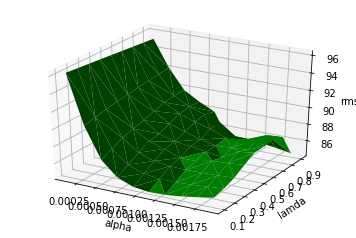

In [27]:
#3D plot of lamda vs Alpha vs RMSE
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(result['alpha'],result['lamda'],result['rmse'],linewidth=0.1,color = 'green')
ax.set_xlabel('alpha')
ax.set_ylabel('lamda')
ax.set_zlabel('rmse')

plt.show()

In [28]:
#Choosing optimal alpha and lamda with least RMSE
optimal = result.iloc[result['rmse'].idxmin()]
alphaOptimal = optimal['alpha']
lamdaOptimal = optimal['lamda']
print("Optimal alpha : ",alphaOptimal,"\nOptimal lambda : ",lamdaOptimal)

Optimal alpha :  0.0011 
Optimal lambda :  0.1


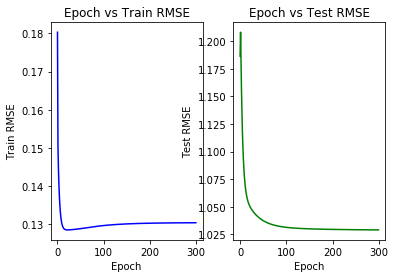

In [29]:
#Calling miniGD ridge regression for optimal alpha and lamda
ii_4,rmse_4,rmseTest_4 = mini_BGD(train,xTest,yTest,alphaOptimal,lamdaOptimal,50,300)
plot(ii_4,rmse_4,rmseTest_4)